In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import scipy.stats as sps
from IPython.display import display
import os

In [2]:
from qfin.models import *

In [3]:
models = BlackScholesModel, HestonModel, VarianceGammaModel, SVJModel, SVCJModel, CGMYModel, MertonModel
models = [model.name for model in models]

In [4]:
# plot style matters
lss = '-', '--', '-.', ':', '-', '--', '-.'
colors = 'blue', 'red', 'green', 'orange', 'purple', 'pink', 'brown'
ps_dict = dict(zip(models, zip(lss, colors)))
ps_dict

{'BLACK_SCHOLES': ('-', 'blue'),
 'HESTON': ('--', 'red'),
 'VARIANCE_GAMMA': ('-.', 'green'),
 'SVJ': (':', 'orange'),
 'SVCJ': ('-', 'purple'),
 'CGMY': ('--', 'pink'),
 'MERTON': ('-.', 'brown')}

In [5]:
DIRECTORY = "20210228_021905"

In [6]:
bounds_dict = {
    
    # SVCJ DeltaHedge
    'PNL__SVCJ__DeltaHedge__BULLISH__4000__30': (-1, 1),
    'PNL__SVCJ__DeltaHedge__CALM__8000__30': (-1, 1),
    'PNL__SVCJ__DeltaHedge__COVID__10000__30': (-1, 1),

    # SVCJ DeltaGammaHedge
    'PNL__SVCJ__DeltaGammaHedge__BULLISH__4000__30': (-1, 1),
    'PNL__SVCJ__DeltaGammaHedge__CALM__8000__30': (-1, 1),
    'PNL__SVCJ__DeltaGammaHedge__COVID__10000__30': (-1, 1),

    # SVCJ DeltaGammaHedge
    'PNL__SVCJ__DeltaVegaHedge__BULLISH__4000__30': (-1, 1),
    'PNL__SVCJ__DeltaVegaHedge__CALM__8000__30': (-1, 1),
    'PNL__SVCJ__DeltaVegaHedge__COVID__10000__30': (-1, 1),

    # SVCJ MinimumVarianceHedge
    'PNL__SVCJ__MinimumVarianceHedge__BULLISH__4000__30': (-2, 2),
    'PNL__SVCJ__MinimumVarianceHedge__CALM__8000__30': (-2, 2),
    'PNL__SVCJ__MinimumVarianceHedge__COVID__10000__30': (-2, 2),

    # KDE DeltaHedge
    'PNL__KDE__DeltaHedge__BULLISH__4000__30': (-1.5, 1.5),
    'PNL__KDE__DeltaHedge__CALM__8000__30': (-1.5, 1.5),
    'PNL__KDE__DeltaHedge__COVID__10000__30': (-1.5, 1.5),

    # KDE DeltaGammaHedge
    'PNL__KDE__DeltaGammaHedge__BULLISH__4000__30': (-1.5, 1.5),
    'PNL__KDE__DeltaGammaHedge__CALM__8000__30': (-1.5, 1.5),
    'PNL__KDE__DeltaGammaHedge__COVID__10000__30': (-1.5, 1.5),

    # KDE DeltaGammaHedge
    'PNL__KDE__DeltaVegaHedge__BULLISH__4000__30': (-1.5, 1.5),
    'PNL__KDE__DeltaVegaHedge__CALM__8000__30': (-1.5, 1.5),
    'PNL__KDE__DeltaVegaHedge__COVID__10000__30': (-1.5, 1.5),

    # KDE MinimumVarianceHedge
    'PNL__KDE__MinimumVarianceHedge__BULLISH__4000__30': (-2, 2),
    'PNL__KDE__MinimumVarianceHedge__CALM__8000__30': (-2, 2),
    'PNL__KDE__MinimumVarianceHedge__COVID__10000__30': (-2, 2),

}

In [7]:
def plot_hedge(paths, models, hedge, period, strike, maturity, price, bounds=(-2, 2)):

    pnls = []
    columns = []

    for model in models:

        fname = f'PNL__{paths}__{model}__{hedge}__{period}__{strike}__{maturity}__100000.csv'
        path = f'_output/hedges/pnl/{DIRECTORY}/{fname}'
                
        if not os.path.exists(path):
            continue

        pnl = pd.read_csv(path, header=None)[0].to_numpy()
        pnl = np.array([x for x in pnl if not np.isnan(x)])
        pnls.append(pnl)
        columns += [model]

    size = np.min([len(pnl) for pnl in pnls])
    pnls = [pnl[:size] for pnl in pnls]
    pnls = np.array(pnls)
    df = pd.DataFrame(pnls.T, columns=columns)
    df = df[~df.isna().any(axis=1)]
    df /= price

    fname = f"PNL__{paths}__{hedge}__{period}__{strike}__{maturity}.csv"
    path = f"_output/hedges/figures/{DIRECTORY}/{fname}"
    os.makedirs(os.path.dirname(path), exist_ok=True)
    df.describe().T.to_csv(path)
    
#     if fname[:-4] in bounds_dict:
#         bounds = bounds_dict[fname[:-4]]

    display(df.describe())

    fig, ax = plt.subplots(figsize=(20, 5))

    for x, ls in zip(df, lss):
        pnl = df[x]
        density = sps.gaussian_kde(pnl)
        xs = np.linspace(bounds[0], bounds[1], 401)
        linestyle, color = ps_dict[x]
        ax.plot(xs, density(xs), linestyle=linestyle, label=x, color=color)
        title = f"PNL {paths} {hedge} {period} STRIKE = {strike} MATURITY = {maturity}D"
        ax.set_title(title)
        ax.legend()
    
    fname = f"PNL__{paths}__{hedge}__{period}__{strike}__{maturity}.pdf"
    path = f"_output/hedges/figures/{DIRECTORY}/{fname}"
    os.makedirs(os.path.dirname(path), exist_ok=True)
    fig.savefig(path)


BLACK_SCHOLES         HESTON  VARIANCE_GAMMA            SVJ  \
count  100000.000000  100000.000000   100000.000000  100000.000000   
mean        0.102972       0.102932        0.102976       0.102926   
std         0.567020       0.565291        0.565358       0.565505   
min       -15.580863     -16.048187      -15.515143     -16.044250   
25%        -0.054206      -0.045770       -0.043725      -0.045936   
50%         0.150084       0.151355        0.158849       0.151469   
75%         0.369543       0.360520        0.356629       0.360812   
max         8.607543       8.674010        8.659225       8.672413   

                SVCJ           CGMY         MERTON  
count  100000.000000  100000.000000  100000.000000  
mean        0.102913       0.102979       0.102878  
std         0.566418       0.563493       0.560501  
min       -16.090098     -15.623623     -16.290255  
25%        -0.042898      -0.044262      -0.032159  
50%         0.151364       0.156646       0.163960  
75%         0.357837       0.354492       0.353454  
max         8.716668       8.644509       8.639978

BLACK_SCHOLES         HESTON  VARIANCE_GAMMA            SVJ  \
count  100000.000000  100000.000000   100000.000000  100000.000000   
mean        0.457280       0.457273        0.457190       0.457249   
std         0.892157       0.894558        0.891876       0.894832   
min       -24.740615     -24.877763      -24.624672     -24.866073   
25%         0.196563       0.202730        0.197413       0.202291   
50%         0.586183       0.589308        0.585806       0.589188   
75%         0.951716       0.951765        0.951072       0.952161   
max        13.017988      13.017774       13.029988      13.016110   

                SVCJ           CGMY         MERTON  
count  100000.000000  100000.000000  100000.000000  
mean        0.457162       0.457148       0.457217  
std         0.894382       0.891053       0.887091  
min       -24.927300     -24.668053     -24.659372  
25%         0.203262       0.196623       0.217141  
50%         0.587931       0.585895       0.591313  
75%         0.950225       0.950946       0.941448  
max        13.099544      13.044234      12.896218

BLACK_SCHOLES         HESTON  VARIANCE_GAMMA            SVJ  \
count  100000.000000  100000.000000   100000.000000  100000.000000   
mean       -0.042606      -0.042513       -0.042362      -0.042492   
std         0.676118       0.682872        0.698027       0.694776   
min        -7.929442      -7.920810       -7.948155      -7.855058   
25%        -0.164979      -0.175854       -0.187313      -0.175944   
50%         0.074808       0.079822        0.075916       0.070897   
75%         0.231580       0.236206        0.242777       0.233937   
max         9.279861       9.311662        9.305206       9.301225   

                SVCJ           CGMY         MERTON  
count  100000.000000  100000.000000  100000.000000  
mean       -0.042850      -0.042337      -0.042162  
std         0.702978       0.697872       0.678499  
min        -7.756858      -7.905680      -7.857826  
25%        -0.174061      -0.185829      -0.187223  
50%         0.065184       0.075425       0.089315  
75%         0.230092       0.241842       0.250877  
max         9.372145       9.309268       9.295309

BLACK_SCHOLES         HESTON  VARIANCE_GAMMA            SVJ  \
count  100000.000000  100000.000000   100000.000000  100000.000000   
mean       -0.101239      -0.101261       -0.101521      -0.101252   
std         0.926437       0.939119        0.942118       0.943861   
min       -30.873364     -30.854657      -26.630833     -30.892981   
25%        -0.363628      -0.379006       -0.371405      -0.375820   
50%         0.123653       0.128890        0.125419       0.126000   
75%         0.334435       0.348773        0.340051       0.345058   
max        17.488666      17.483802       16.395790      17.533977   

                SVCJ           CGMY         MERTON  
count  100000.000000  100000.000000  100000.000000  
mean       -0.101316      -0.101537      -0.101279  
std         0.949938       0.940138       0.947210  
min       -30.971113     -23.729379     -31.051283  
25%        -0.365195      -0.370651      -0.420449  
50%         0.119634       0.125516       0.134550  
75%         0.337242       0.338428       0.395427  
max        17.549370      16.717618      17.496192

BLACK_SCHOLES         HESTON  VARIANCE_GAMMA            SVJ  \
count  100000.000000  100000.000000   100000.000000  100000.000000   
mean       -0.076121      -0.076094       -0.076003      -0.075787   
std         0.885654       0.888434        0.889365       0.880681   
min       -20.074230     -19.893739      -19.745527     -19.866315   
25%        -0.141156      -0.151566       -0.159944      -0.179459   
50%         0.105359       0.113440        0.116924       0.132022   
75%         0.312252       0.302086        0.306111       0.307545   
max         5.626287       5.688255        5.636168       5.683372   

                SVCJ           CGMY         MERTON  
count  100000.000000  100000.000000  100000.000000  
mean       -0.076267      -0.076055      -0.075725  
std         0.908645       0.888267       0.873307  
min       -19.463624     -19.821805     -19.964016  
25%        -0.146497      -0.159933      -0.205436  
50%         0.100064       0.116931       0.146777  
75%         0.298038       0.305036       0.321680  
max         5.622677       5.631541       5.643188

BLACK_SCHOLES         HESTON  VARIANCE_GAMMA            SVJ  \
count  100000.000000  100000.000000   100000.000000  100000.000000   
mean       -0.186794      -0.186796       -0.186582      -0.185132   
std         1.727539       1.736162        1.752369       1.779947   
min       -16.013290     -15.893195      -15.878998     -16.102921   
25%        -0.756028      -0.722765       -0.715864      -0.681188   
50%         0.420725       0.415362        0.428099       0.426063   
75%         0.912755       0.904957        0.914278       0.918410   
max        21.104917      21.145814       20.937032      21.452205   

                SVCJ           CGMY         MERTON  
count  100000.000000  100000.000000  100000.000000  
mean       -0.185783      -0.186569      -0.186132  
std         1.791287       1.759338       1.733933  
min       -16.139836     -16.041124     -15.568881  
25%        -0.642231      -0.710878      -0.743508  
50%         0.435520       0.429050       0.391611  
75%         0.922392       0.917931       0.913283  
max        20.379196      20.821137      20.964486

BLACK_SCHOLES         HESTON  VARIANCE_GAMMA            SVJ  \
count  100000.000000  100000.000000   100000.000000  100000.000000   
mean        0.027891       0.033173        0.101288       0.028676   
std         0.514276       0.512071        0.525581       0.512397   
min       -10.896985     -10.693878      -11.689379     -10.695863   
25%        -0.066052      -0.080125       -0.034471      -0.085808   
50%         0.080806       0.089492        0.159736       0.085187   
75%         0.216664       0.224029        0.285407       0.220739   
max        19.613634      18.560239       30.061825      18.547789   

                SVCJ           CGMY         MERTON  
count  100000.000000  100000.000000  100000.000000  
mean        0.085028       0.063746       0.153413  
std         0.511078       0.508706       0.507288  
min       -10.780457     -11.629050     -10.872509  
25%        -0.035139      -0.065517       0.020848  
50%         0.138236       0.115149       0.208586  
75%         0.279624       0.242419       0.351215  
max        18.601112      22.783557      20.514927

BLACK_SCHOLES        HESTON  VARIANCE_GAMMA           SVJ  \
count   99995.000000  99995.000000    99995.000000  99995.000000   
mean        0.121926      0.125289        0.144687      0.121726   
std         0.538470      0.535557        0.539807      0.536039   
min       -11.590701    -11.564496      -11.612267    -11.577364   
25%         0.023378      0.046624        0.042941      0.041737   
50%         0.146608      0.147027        0.164986      0.142556   
75%         0.280358      0.282419        0.306248      0.282156   
max        13.517327     13.535598       13.529197     13.528725   

               SVCJ          CGMY        MERTON  
count  99995.000000  99995.000000  99995.000000  
mean       0.146654      0.122430      0.159159  
std        0.537018      0.538444      0.535065  
min      -11.534350    -11.608710     -8.356237  
25%        0.058882      0.011538      0.068851  
50%        0.161174      0.155337      0.180807  
75%        0.311814      0.282698      0.311378  
max       13.596673     13.530378     13.614379

BLACK_SCHOLES        HESTON  VARIANCE_GAMMA           SVJ  \
count   99948.000000  99948.000000    99948.000000  99948.000000   
mean       -0.003458     -0.014960       -0.070907     -0.018278   
std         0.468383      0.484216        0.528392      0.494526   
min        -6.397511     -6.510301       -4.453920     -6.298133   
25%        -0.111529     -0.144508       -0.262568     -0.150302   
50%         0.012655     -0.020621       -0.039472     -0.028767   
75%         0.116679      0.131444        0.068878      0.135841   
max        11.817210     13.173518       13.663604     13.139055   

               SVCJ          CGMY        MERTON  
count  99948.000000  99948.000000  99948.000000  
mean      -0.030883     -0.084608     -0.027573  
std        0.503833      0.543967      0.493075  
min       -9.159771     -4.594764     -6.803504  
25%       -0.171382     -0.276130     -0.187525  
50%       -0.050081     -0.048971     -0.037491  
75%        0.126560      0.060762      0.106460  
max       14.373965     16.441016     15.761598

BLACK_SCHOLES        HESTON  VARIANCE_GAMMA           SVJ  \
count   95489.000000  95489.000000    95489.000000  95489.000000   
mean       -0.018316     -0.023528       -0.027765     -0.021319   
std         0.592819      0.655681        0.699880      0.653758   
min       -12.174924    -28.693421      -29.105556    -28.691658   
25%        -0.108337     -0.116140       -0.168069     -0.119466   
50%        -0.015271     -0.019429        0.006280     -0.022243   
75%         0.035980      0.020932        0.121655      0.026438   
max        12.413663     17.634701       17.854163     17.628386   

               SVCJ          CGMY        MERTON  
count  95489.000000  95489.000000  95489.000000  
mean      -0.032571      0.010566      0.037063  
std        0.649988      0.739954      0.662447  
min      -28.830272    -29.366563    -28.655943  
25%       -0.138192     -0.184037     -0.089537  
50%       -0.032177      0.008751      0.043338  
75%        0.018213      0.164726      0.139582  
max       17.646222     17.914406     17.668416

BLACK_SCHOLES        HESTON  VARIANCE_GAMMA           SVJ  \
count   99977.000000  99977.000000    99977.000000  99977.000000   
mean       -0.070972     -0.083191       -0.098485     -0.095598   
std         0.536579      0.561247        0.581808      0.577414   
min       -16.976548    -16.912240      -17.117587    -16.826035   
25%        -0.164943     -0.162597       -0.202709     -0.178920   
50%        -0.015081     -0.048708       -0.059053     -0.083398   
75%         0.070484      0.055095        0.046453      0.044577   
max         8.692358      8.820754       11.532660     10.691878   

               SVCJ          CGMY        MERTON  
count  99977.000000  99977.000000  99977.000000  
mean      -0.089341     -0.093304     -0.104377  
std        0.597063      0.562005      0.582879  
min      -20.359174    -26.641617    -17.172964  
25%       -0.167254     -0.201946     -0.208896  
50%       -0.067150     -0.055533     -0.106456  
75%        0.057425      0.032715      0.046766  
max       10.447949     10.179525     12.017725

BLACK_SCHOLES        HESTON  VARIANCE_GAMMA           SVJ  \
count   99693.000000  99693.000000    99693.000000  99693.000000   
mean       -0.081922     -0.057720       -0.095205     -0.063058   
std         0.684423      0.745234        0.738476      0.844319   
min       -11.851877    -31.470112      -30.925351    -11.586410   
25%        -0.215799     -0.180256       -0.203401     -0.223573   
50%         0.026127      0.056969        0.000365     -0.047075   
75%         0.119946      0.148482        0.084588      0.144115   
max        23.928846     23.940851       23.909377     24.281199   

               SVCJ          CGMY        MERTON  
count  99693.000000  99693.000000  99693.000000  
mean      -0.079306     -0.097722     -0.058160  
std        0.847099      0.747463      0.784142  
min      -11.812895    -30.587512    -22.535217  
25%       -0.256070     -0.207948     -0.157383  
50%       -0.055503     -0.002032      0.035225  
75%        0.151800      0.083204      0.124835  
max       24.681525     26.845878     24.076339

BLACK_SCHOLES        HESTON           SVJ          SVCJ        MERTON
count   99991.000000  99991.000000  99991.000000  99991.000000  99991.000000
mean        0.027679      0.040288      0.037688      0.093408      0.074717
std         0.513252      0.518180      0.519145      0.516916      0.512135
min       -10.905615    -10.822162    -10.820486    -10.765758    -10.928157
25%        -0.066159     -0.072891     -0.076705     -0.025707     -0.048729
50%         0.080297      0.096153      0.093897      0.146073      0.132073
75%         0.216517      0.230901      0.229435      0.286198      0.267514
max        19.409004     23.004108     23.011397     18.129557     23.605282

BLACK_SCHOLES        HESTON           SVJ          SVCJ        MERTON
count   99758.000000  99758.000000  99758.000000  99758.000000  99758.000000
mean        0.122463      0.123832      0.121401      0.153659      0.134426
std         0.538318      0.532034      0.529095      0.534726      0.537430
min       -11.591287    -11.547767    -11.556143    -11.495506    -11.527612
25%         0.024034      0.044576      0.041058      0.064630      0.044029
50%         0.147314      0.144244      0.141977      0.168394      0.156764
75%         0.281263      0.284856      0.284369      0.323078      0.289054
max        13.517368     13.541966     13.535626     13.608919     13.569826

BLACK_SCHOLES        HESTON           SVJ          SVCJ        MERTON
count   97880.000000  97880.000000  97880.000000  97880.000000  97880.000000
mean       -0.002121     -0.012950     -0.020312     -0.032167     -0.030868
std         0.468874      0.482721      0.485624      0.503390      0.495658
min        -6.397687     -6.366726     -6.335835     -4.022768     -6.410014
25%        -0.110647     -0.142152     -0.147768     -0.170995     -0.187155
50%         0.013887     -0.018954     -0.029074     -0.048903     -0.033246
75%         0.118099      0.134041      0.131236      0.124484      0.110340
max        11.656041     12.765870     12.724003     13.812924     14.958689

BLACK_SCHOLES        HESTON           SVJ          SVCJ        MERTON
count   89637.000000  89637.000000  89637.000000  89637.000000  89637.000000
mean       -0.017784     -0.027714     -0.028296     -0.035043     -0.015887
std         0.593821      0.581528      0.576130      0.648271      0.584897
min       -12.174951    -15.484844    -22.628848    -28.856394    -12.207985
25%        -0.108622     -0.114833     -0.120021     -0.151992     -0.137643
50%        -0.015347     -0.017452     -0.020312     -0.030349      0.000919
75%         0.035810      0.018923      0.020325      0.017000      0.126311
max        12.413590     12.404303     11.523868     17.624549     11.964365

BLACK_SCHOLES        HESTON           SVJ          SVCJ        MERTON
count   99724.000000  99724.000000  99724.000000  99724.000000  99724.000000
mean       -0.071255     -0.082190     -0.094342     -0.092753     -0.104359
std         0.536694      0.555733      0.570543      0.598791      0.584211
min       -16.978349    -21.160165    -16.826496    -17.235932    -17.089591
25%        -0.164991     -0.160800     -0.175602     -0.172089     -0.190844
50%        -0.015518     -0.045536     -0.081122     -0.063447     -0.087237
75%         0.070742      0.057967      0.047746      0.061168      0.050581
max         8.516751      8.475655      9.806921     11.449457      9.634401

BLACK_SCHOLES        HESTON           SVJ          SVCJ        MERTON
count   99375.000000  99375.000000  99375.000000  99375.000000  99375.000000
mean       -0.081929     -0.091130     -0.093054     -0.087116     -0.107153
std         0.684837      0.688820      0.840014      0.842059      0.764554
min       -11.852186     -9.608760    -11.585915    -11.819310    -11.873968
25%        -0.215859     -0.212984     -0.250575     -0.280028     -0.212082
50%         0.026401      0.020095     -0.077250     -0.050024     -0.001660
75%         0.120239      0.108042      0.117200      0.150662      0.095197
max        23.929310      7.743809     24.179098     23.811730     23.946768

HESTON  VARIANCE_GAMMA            SVJ           SVCJ  \
count  100000.000000   100000.000000  100000.000000  100000.000000   
mean        0.102960        0.104602       0.102959       0.102987   
std         0.565534        0.765262       0.565216       0.569636   
min       -15.950150      -10.658235     -15.953573     -16.012371   
25%        -0.050629       -0.273725      -0.050398      -0.045427   
50%         0.150280        0.167506       0.149931       0.153215   
75%         0.362964        0.574591       0.362472       0.361403   
max         8.668819        8.614616       8.670081       8.707619   

              MERTON  
count  100000.000000  
mean        0.044086  
std         0.704351  
min       -10.997474  
25%        -0.339711  
50%         0.077426  
75%         0.464054  
max        11.012668

HESTON  VARIANCE_GAMMA            SVJ           SVCJ  \
count  100000.000000   100000.000000  100000.000000  100000.000000   
mean        0.457092        0.458957       0.457074       0.457098   
std         0.885929        1.013882       0.885319       0.891424   
min       -24.575445      -24.473481     -24.597017     -24.614218   
25%         0.182238        0.016863       0.183644       0.185534   
50%         0.576905        0.578997       0.576984       0.581601   
75%         0.952093        1.080450       0.950970       0.953154   
max        13.115120       13.418802      13.111931      13.174671   

              MERTON  
count  100000.000000  
mean        0.170212  
std         1.262509  
min       -34.174164  
25%        -0.231192  
50%         0.346921  
75%         0.873037  
max        87.117359

HESTON  VARIANCE_GAMMA            SVJ           SVCJ  \
count  100000.000000   100000.000000  100000.000000  100000.000000   
mean       -0.042560       -0.043204      -0.042583      -0.043251   
std         0.682195        0.697697       0.704022       0.717448   
min        -7.933620       -8.036265      -7.813449      -7.712048   
25%        -0.177625       -0.203402      -0.175157      -0.169967   
50%         0.080613        0.054226       0.060150       0.049750   
75%         0.236641        0.279582       0.234162       0.228759   
max         9.313033        9.123301       9.313324       9.447683   

              MERTON  
count  100000.000000  
mean       -0.005759  
std         0.727099  
min        -6.352353  
25%        -0.399790  
50%         0.039390  
75%         0.455397  
max         8.426986

<ipython-input-7-eda4ada7037f>:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(20, 5))


HESTON  VARIANCE_GAMMA           SVJ          SVCJ        MERTON
count  95554.000000    95554.000000  95554.000000  95554.000000  95554.000000
mean      -0.100789       -0.116912     -0.100892     -0.101394     -0.018432
std        0.938697        1.251582      0.958384      0.971302      1.175098
min      -30.677715      -29.627262    -30.672796    -30.924982    -22.927034
25%       -0.366708       -0.735955     -0.357209     -0.338844     -0.803009
50%        0.114530        0.042079      0.094469      0.086280      0.052958
75%        0.330864        0.688388      0.324177      0.310330      0.801636
max       17.522240       17.323501     17.661366     17.826953     33.121148

HESTON  VARIANCE_GAMMA            SVJ           SVCJ  \
count  100000.000000   100000.000000  100000.000000  100000.000000   
mean       -0.076173       -0.078734      -0.075728      -0.076459   
std         0.898925        1.455970       0.886352       0.939296   
min       -19.686397      -16.881440     -19.790839     -19.059319   
25%        -0.140853       -0.463791      -0.175340      -0.144960   
50%         0.100719        0.198362       0.124164       0.073714   
75%         0.301161        0.742411       0.308168       0.310266   
max         5.753372        6.895131       5.686847       5.710175   

              MERTON  
count  100000.000000  
mean       -0.046245  
std         1.079206  
min       -16.389626  
25%        -0.485874  
50%         0.195013  
75%         0.653245  
max         6.097747

HESTON  VARIANCE_GAMMA            SVJ           SVCJ  \
count  100000.000000   100000.000000  100000.000000  100000.000000   
mean       -0.186475       -0.185739      -0.183929      -0.185319   
std         1.737893        2.000316       1.834061       1.837606   
min       -16.716386      -16.042129     -17.343485     -16.563906   
25%        -0.713741       -0.749005      -0.757337      -0.568416   
50%         0.425992        0.391661       0.432680       0.442884   
75%         0.904292        1.115867       0.969083       0.951551   
max        21.764696       23.832484      24.226987      20.722883   

              MERTON  
count  100000.000000  
mean       -0.361127  
std         1.621204  
min       -21.695611  
25%        -1.281223  
50%        -0.015110  
75%         0.819474  
max        11.085865

BLACK_SCHOLES         HESTON  VARIANCE_GAMMA            SVJ  \
count  100000.000000  100000.000000   100000.000000  100000.000000   
mean       -0.308895      -0.304389       -0.306430      -0.304959   
std         0.631224       0.631656        0.633955       0.631829   
min        -3.386851      -3.410194       -3.419669      -3.415661   
25%        -0.626219      -0.624805       -0.627968      -0.625491   
50%        -0.302228      -0.298224       -0.295638      -0.298470   
75%         0.024819       0.027531        0.024613       0.026940   
max         3.041154       3.082505        3.022017       3.082803   

                SVCJ           CGMY         MERTON  
count  100000.000000  100000.000000  100000.000000  
mean       -0.303025      -0.302903      -0.317316  
std         0.632244       0.632859       0.632184  
min        -3.425389      -3.389614      -3.438041  
25%        -0.625565      -0.624415      -0.638293  
50%        -0.297053      -0.295138      -0.302119  
75%         0.028476       0.027238       0.013747  
max         3.067505       3.044522       3.082072

BLACK_SCHOLES         HESTON  VARIANCE_GAMMA            SVJ  \
count  100000.000000  100000.000000   100000.000000  100000.000000   
mean       -0.357091      -0.370655       -0.355659      -0.371720   
std         2.062906       2.064838        2.063154       2.064767   
min       -12.529692     -12.518484      -12.524779     -12.523028   
25%        -1.352312      -1.371155       -1.350678      -1.372314   
50%        -0.386099      -0.393899       -0.386170      -0.394615   
75%         0.547336       0.536341        0.549022       0.535229   
max        18.449934      18.461910       18.455556      18.459039   

                SVCJ           CGMY         MERTON  
count  100000.000000  100000.000000  100000.000000  
mean       -0.362915      -0.352925      -0.384207  
std         2.065652       2.063088       2.064472  
min       -12.515233     -12.524398     -12.597188  
25%        -1.362953      -1.348734      -1.385956  
50%        -0.389438      -0.383526      -0.402969  
75%         0.545961       0.550885       0.521695  
max        18.509546      18.459496      18.415726

BLACK_SCHOLES         HESTON  VARIANCE_GAMMA            SVJ  \
count  100000.000000  100000.000000   100000.000000  100000.000000   
mean        0.431726       0.431854        0.431670       0.431427   
std         0.253081       0.253971        0.267019       0.254466   
min        -1.061254      -1.111432       -1.129226      -1.117645   
25%         0.318819       0.321399        0.313553       0.318540   
50%         0.424100       0.430549        0.435489       0.424605   
75%         0.544094       0.541723        0.551543       0.540876   
max         1.701999       1.739308        1.773697       1.771194   

                SVCJ           CGMY         MERTON  
count  100000.000000  100000.000000  100000.000000  
mean        0.431194       0.431637       0.432303  
std         0.255686       0.267739       0.258152  
min        -1.133733      -1.131575      -1.150956  
25%         0.314915       0.313709       0.319482  
50%         0.421997       0.435286       0.442316  
75%         0.539374       0.551875       0.549851  
max         1.796987       1.773997       1.740557

BLACK_SCHOLES         HESTON  VARIANCE_GAMMA            SVJ  \
count  100000.000000  100000.000000   100000.000000  100000.000000   
mean        0.806996       0.807040        0.806598       0.806704   
std         0.234757       0.224427        0.228116       0.224761   
min        -0.439270      -0.424616       -0.427784      -0.421658   
25%         0.652284       0.664249        0.658122       0.662290   
50%         0.800278       0.806991        0.804795       0.805504   
75%         0.957949       0.947041        0.950501       0.946521   
max         1.758928       1.786454        1.860084       1.825857   

                SVCJ           CGMY         MERTON  
count  100000.000000  100000.000000  100000.000000  
mean        0.806075       0.806590       0.808697  
std         0.221968       0.228047       0.233340  
min        -0.355994      -0.430765      -0.501226  
25%         0.662484       0.657841       0.668174  
50%         0.800150       0.805271       0.823588  
75%         0.939399       0.950462       0.961233  
max         1.834105       1.857891       1.762257

BLACK_SCHOLES         HESTON  VARIANCE_GAMMA            SVJ  \
count  100000.000000  100000.000000   100000.000000  100000.000000   
mean        0.226622       0.224959        0.225244       0.218375   
std         0.301629       0.294805        0.295966       0.298697   
min        -1.301137      -1.269906       -1.325825      -1.316858   
25%         0.058496       0.072983        0.070513       0.073494   
50%         0.213029       0.213844        0.221136       0.226441   
75%         0.401710       0.386759        0.387671       0.380003   
max         1.372053       1.370121        1.409512       1.412797   

                SVCJ           CGMY         MERTON  
count  100000.000000  100000.000000  100000.000000  
mean        0.231925       0.224844       0.212828  
std         0.294501       0.295383       0.302543  
min        -1.222490      -1.322592      -1.292944  
25%         0.069724       0.071571       0.067459  
50%         0.210455       0.220657       0.236515  
75%         0.393607       0.386348       0.379154  
max         1.411427       1.392729       1.407390

BLACK_SCHOLES         HESTON  VARIANCE_GAMMA            SVJ  \
count  100000.000000  100000.000000   100000.000000  100000.000000   
mean       -0.681956      -0.687222       -0.679363      -0.690629   
std         0.989335       1.016894        0.991704       1.023280   
min        -7.941426      -8.205012       -7.919085      -7.509104   
25%        -1.255867      -1.271885       -1.253020      -1.271321   
50%        -0.613311      -0.608180       -0.609567      -0.613752   
75%        -0.024989      -0.010222       -0.025648      -0.031323   
max         4.090295       4.013090        4.178955       4.707159   

                SVCJ           CGMY         MERTON  
count  100000.000000  100000.000000  100000.000000  
mean       -0.675757      -0.681346      -0.706566  
std         0.999979       0.992243       1.002576  
min        -8.144881      -7.932543      -8.028195  
25%        -1.241367      -1.250418      -1.284179  
50%        -0.613456      -0.609601      -0.627144  
75%        -0.030578      -0.030206      -0.039286  
max         4.725561       4.173371       3.944614

BLACK_SCHOLES         HESTON  VARIANCE_GAMMA            SVJ  \
count  100000.000000  100000.000000   100000.000000  100000.000000   
mean       -0.037747      -0.020559        0.076714      -0.026641   
std         0.598772       0.599507        0.612964       0.599395   
min        -2.443351      -2.497991       -2.417757      -2.513601   
25%        -0.309764      -0.295863       -0.219172      -0.301762   
50%        -0.031235      -0.016251        0.078542      -0.020810   
75%         0.236849       0.251615        0.358667       0.245089   
max         4.424098       4.698916        4.800828       4.693942   

                SVCJ           CGMY         MERTON  
count  100000.000000  100000.000000  100000.000000  
mean        0.040977       0.040535       0.128912  
std         0.601141       0.612340       0.608685  
min        -2.437975      -2.502642      -2.301250  
25%        -0.235314      -0.253732      -0.157567  
50%         0.041686       0.037383       0.122166  
75%         0.314732       0.323242       0.410170  
max         4.796516       5.265482       5.007408

BLACK_SCHOLES        HESTON  VARIANCE_GAMMA           SVJ  \
count   99934.000000  99934.000000    99934.000000  99934.000000   
mean        0.290809      0.295716        0.305355      0.288895   
std         2.059433      2.055999        2.059330      2.054608   
min       -12.038520    -12.046486      -12.027662    -12.049243   
25%        -0.656219     -0.648121       -0.641115     -0.655521   
50%         0.138310      0.146877        0.155349      0.142007   
75%         1.139888      1.138677        1.154794      1.131343   
max        19.100239     19.112676       19.104344     19.119391   

               SVCJ          CGMY        MERTON  
count  99934.000000  99934.000000  99934.000000  
mean       0.318600      0.296824      0.338286  
std        2.055715      2.059702      2.057580  
min      -12.007475    -12.030046    -11.964012  
25%       -0.624862     -0.650424     -0.606186  
50%        0.168954      0.141887      0.182957  
75%        1.164158      1.148252      1.189720  
max       19.182561     19.089837     19.219290

BLACK_SCHOLES         HESTON  VARIANCE_GAMMA            SVJ  \
count  100000.000000  100000.000000   100000.000000  100000.000000   
mean        0.052256       0.049191       -0.096707       0.053770   
std         0.238022       0.272522        0.353104       0.271447   
min        -1.222397      -1.292158       -5.909527      -1.310837   
25%        -0.035896      -0.078321       -0.256167      -0.078035   
50%         0.049139       0.010636       -0.088490       0.012745   
75%         0.130720       0.156888        0.027831       0.160372   
max         1.637237       2.545580        4.066074       2.536632   

                SVCJ           CGMY         MERTON  
count  100000.000000  100000.000000  100000.000000  
mean        0.039082      -0.117539       0.007073  
std         0.291738       0.388411       0.303834  
min        -1.326743      -5.837286      -1.447136  
25%        -0.106457      -0.272783      -0.141931  
50%        -0.020897      -0.093390      -0.042941  
75%         0.157230       0.021322       0.114966  
max         2.540474       4.165912       2.862535

BLACK_SCHOLES        HESTON  VARIANCE_GAMMA           SVJ  \
count   96112.000000  96112.000000    96112.000000  96112.000000   
mean        0.024125      0.018958        0.035807      0.024836   
std         0.154786      0.154531        0.205424      0.156309   
min        -0.833046     -0.812681       -1.785258     -0.817477   
25%        -0.019238     -0.025126       -0.076738     -0.027540   
50%         0.016134      0.003350        0.043862      0.005823   
75%         0.073030      0.053430        0.138910      0.061293   
max         1.160041      1.176188        2.203400      1.180403   

               SVCJ          CGMY        MERTON  
count  96112.000000  96112.000000  96112.000000  
mean       0.017043      0.123140      0.062534  
std        0.158635      0.374286      0.162474  
min       -0.849130     -1.709447     -0.783602  
25%       -0.040426     -0.093189     -0.005467  
50%       -0.008193      0.044108      0.054630  
75%        0.056986      0.231787      0.114715  
max        1.242315      2.766131      1.313626

BLACK_SCHOLES         HESTON  VARIANCE_GAMMA            SVJ  \
count  100000.000000  100000.000000   100000.000000  100000.000000   
mean       -0.024915      -0.029409       -0.051387      -0.044898   
std         0.252950       0.252835        0.277808       0.259286   
min        -1.273970      -1.231943       -1.742344      -1.222877   
25%        -0.100946      -0.102604       -0.165608      -0.143730   
50%        -0.010130      -0.037801       -0.055398      -0.065753   
75%         0.070312       0.060698        0.054807       0.048483   
max         1.126087       1.170163        2.117110       1.194206   

                SVCJ           CGMY         MERTON  
count  100000.000000  100000.000000  100000.000000  
mean       -0.022496      -0.056424      -0.055401  
std         0.257047       0.270362       0.263337  
min        -1.264474      -1.220810      -1.210394  
25%        -0.110248      -0.169373      -0.172079  
50%        -0.047294      -0.055554      -0.084535  
75%         0.073241       0.036325       0.048945  
max         1.177051       1.227566       1.209232

BLACK_SCHOLES        HESTON  VARIANCE_GAMMA           SVJ  \
count   99966.000000  99966.000000    99966.000000  99966.000000   
mean        0.048132      0.094132        0.022732      0.125105   
std         0.676430      0.679637        0.678914      0.735111   
min        -5.774605     -5.737761       -5.792240     -5.278037   
25%        -0.115771     -0.091952       -0.152878     -0.259910   
50%         0.005383      0.042419       -0.016142      0.004733   
75%         0.189856      0.249599        0.182518      0.422609   
max         5.858254      5.854282        5.804622      6.055685   

               SVCJ          CGMY        MERTON  
count  99966.000000  99966.000000  99966.000000  
mean       0.067542      0.019844      0.094076  
std        0.707369      0.679193      0.677845  
min       -5.814618     -5.813456     -5.702314  
25%       -0.242679     -0.154924     -0.091101  
50%       -0.025514     -0.019765      0.042178  
75%        0.320298      0.180563      0.236725  
max        5.909025      5.790764      5.991150

BLACK_SCHOLES        HESTON           SVJ          SVCJ        MERTON
count   99841.000000  99841.000000  99841.000000  99841.000000  99841.000000
mean       -0.038554     -0.019228     -0.023207      0.045565      0.038163
std         0.598710      0.597839      0.598348      0.600237      0.604651
min        -2.444632     -2.462354     -2.502957     -2.435575     -2.466883
25%        -0.310454     -0.293382     -0.297413     -0.229467     -0.244800
50%        -0.032299     -0.014699     -0.017445      0.045392      0.037954
75%         0.235842      0.252204      0.248071      0.318516      0.315137
max         4.911008      4.572475      4.567093      4.697075      4.836918

BLACK_SCHOLES        HESTON           SVJ          SVCJ        MERTON
count   96531.000000  96531.000000  96531.000000  96531.000000  96531.000000
mean        0.291955      0.287044      0.280102      0.319660      0.308807
std         2.061605      2.032399      2.036191      2.040310      2.062585
min       -12.038751    -11.720660    -12.040770    -11.704181    -11.994100
25%        -0.655509     -0.647876     -0.649788     -0.617658     -0.638970
50%         0.139453      0.137576      0.130135      0.169259      0.157812
75%         1.141339      1.124983      1.111856      1.161759      1.159048
max        18.990350     19.014530     19.010231     19.048758     19.062921

BLACK_SCHOLES        HESTON           SVJ          SVCJ        MERTON
count   99727.000000  99727.000000  99727.000000  99727.000000  99727.000000
mean        0.053434      0.051607      0.060138      0.043422      0.024945
std         0.237928      0.271173      0.269452      0.285374      0.302923
min        -1.222360     -1.291411     -1.307643     -1.319910     -1.311097
25%        -0.034420     -0.074719     -0.070842     -0.097369     -0.122314
50%         0.051012      0.014315      0.021004     -0.012664     -0.020882
75%         0.132068      0.159301      0.166235      0.159373      0.135774
max         1.633620      2.481228      2.476601      2.380656      3.102415

BLACK_SCHOLES        HESTON           SVJ          SVCJ        MERTON
count   93049.000000  93049.000000  93049.000000  93049.000000  93049.000000
mean        0.024397      0.026810      0.034103      0.033866      0.037980
std         0.154744      0.153621      0.149977      0.157861      0.159568
min        -0.832922     -0.800503     -0.821958     -0.842539     -0.803676
25%        -0.019040     -0.016561     -0.014689     -0.022253     -0.025285
50%         0.016667      0.011913      0.017648      0.009302      0.028988
75%         0.073520      0.062540      0.069571      0.075140      0.089167
max         1.159925      1.172661      1.176961      1.227546      1.226372

BLACK_SCHOLES        HESTON           SVJ          SVCJ        MERTON
count   99979.000000  99979.000000  99979.000000  99979.000000  99979.000000
mean       -0.024721     -0.024976     -0.040319     -0.015873     -0.033578
std         0.252939      0.252766      0.258825      0.256965      0.259508
min        -1.274023     -1.228849     -1.222106     -1.256887     -1.191388
25%        -0.100176     -0.097947     -0.137863     -0.104970     -0.140660
50%        -0.010477     -0.033706     -0.062083     -0.040472     -0.058615
75%         0.070681      0.065154      0.053623      0.080167      0.066698
max         1.125990      1.170862      1.191643      1.177808      1.196324

BLACK_SCHOLES        HESTON           SVJ          SVCJ        MERTON
count   97276.000000  97276.000000  97276.000000  97276.000000  97276.000000
mean        0.048277      0.052957      0.088145      0.054900      0.052402
std         0.677058      0.645200      0.730337      0.700173      0.679201
min        -5.774421     -5.803654     -5.316933     -5.797696     -5.799688
25%        -0.115878     -0.118387     -0.294389     -0.242237     -0.141999
50%         0.005258      0.004613     -0.032876     -0.036956     -0.003031
75%         0.190171      0.189004      0.383774      0.297378      0.202513
max         5.859071      4.923629      6.015693      5.917175      5.862822

HESTON  VARIANCE_GAMMA            SVJ           SVCJ  \
count  100000.000000   100000.000000  100000.000000  100000.000000   
mean       -0.301085       -0.174966      -0.300259      -0.305786   
std         0.631938        0.816229       0.631818       0.634002   
min        -3.430905       -3.744773      -3.431462      -3.468503   
25%        -0.622090       -0.688147      -0.621850      -0.626481   
50%        -0.297249       -0.167771      -0.296943      -0.298415   
75%         0.030795        0.337828       0.031629       0.026774   
max         3.101196        3.699050       3.099248       3.076335   

              MERTON  
count  100000.000000  
mean       -0.126841  
std         0.752731  
min        -3.465765  
25%        -0.604560  
50%        -0.119845  
75%         0.339026  
max         3.327947

HESTON  VARIANCE_GAMMA            SVJ           SVCJ  \
count  100000.000000   100000.000000  100000.000000  100000.000000   
mean       -0.297643       -0.190784      -0.297508      -0.311716   
std         2.062821        2.113336       2.062853       2.063726   
min       -12.476794      -12.506085     -12.480840     -12.535237   
25%        -1.286515       -1.289350      -1.285648      -1.306655   
50%        -0.349042       -0.245106      -0.349032      -0.360232   
75%         0.611034        0.807346       0.611161       0.598283   
max        18.535948       18.953173      18.531582      18.531589   

              MERTON  
count  100000.000000  
mean       -0.177239  
std         2.076435  
min       -16.659535  
25%        -1.216585  
50%        -0.245114  
75%         0.764632  
max        18.147405

HESTON  VARIANCE_GAMMA            SVJ           SVCJ  \
count  100000.000000   100000.000000  100000.000000  100000.000000   
mean        0.431928        0.431346       0.431080       0.430713   
std         0.253891        0.277076       0.256790       0.259092   
min        -1.104457       -1.094170      -1.112099      -1.141215   
25%         0.320896        0.263804       0.309570       0.303328   
50%         0.430298        0.422076       0.418219       0.414709   
75%         0.541594        0.581794       0.544107       0.544195   
max         1.735914        1.755686       1.807618       1.856352   

              MERTON  
count  100000.000000  
mean        0.429467  
std         0.406336  
min        -1.304554  
25%         0.161136  
50%         0.427472  
75%         0.690848  
max         2.210850

HESTON  VARIANCE_GAMMA           SVJ          SVCJ        MERTON
count  95088.000000    95088.000000  95088.000000  95088.000000  95088.000000
mean       0.806769        0.778945      0.805320      0.804159      0.768487
std        0.226930        0.547227      0.239403      0.245337      0.646026
min       -0.374665       -1.723270     -0.332055     -0.227295     -1.690044
25%        0.656357        0.450918      0.641190      0.633679      0.345482
50%        0.800478        0.831801      0.798984      0.792021      0.869336
75%        0.947521        1.153172      0.957997      0.958383      1.238446
max        1.805559        2.936120      1.904832      1.953210      2.901454

HESTON  VARIANCE_GAMMA            SVJ           SVCJ  \
count  100000.000000   100000.000000  100000.000000  100000.000000   
mean        0.229825        0.324869       0.220516       0.243241   
std         0.294999        0.688761       0.300470       0.308101   
min        -1.219494       -3.576928      -1.329781      -1.159477   
25%         0.066692       -0.051492       0.069246       0.044120   
50%         0.212093        0.425191       0.224021       0.213829   
75%         0.394052        0.797795       0.384511       0.424071   
max         1.385736        2.688571       1.426342       1.484220   

              MERTON  
count  100000.000000  
mean        0.343727  
std         0.610923  
min        -2.611484  
25%         0.047505  
50%         0.493632  
75%         0.761604  
max         1.896102

HESTON  VARIANCE_GAMMA            SVJ           SVCJ  \
count  100000.000000   100000.000000  100000.000000  100000.000000   
mean       -0.664891       -0.562487      -0.711014      -0.614256   
std         1.044025        1.126598       1.371546       1.032653   
min        -8.395018       -8.257143      -9.772371      -8.321184   
25%        -1.276394       -1.273404      -1.516938      -1.231108   
50%        -0.585221       -0.518010      -0.612975      -0.578479   
75%         0.032197        0.197726       0.189484       0.050330   
max         4.703920        4.679545       5.724064       5.147980   

              MERTON  
count  100000.000000  
mean       -0.497672  
std         1.145784  
min        -7.638051  
25%        -1.272247  
50%        -0.480970  
75%         0.288113  
max         5.437879

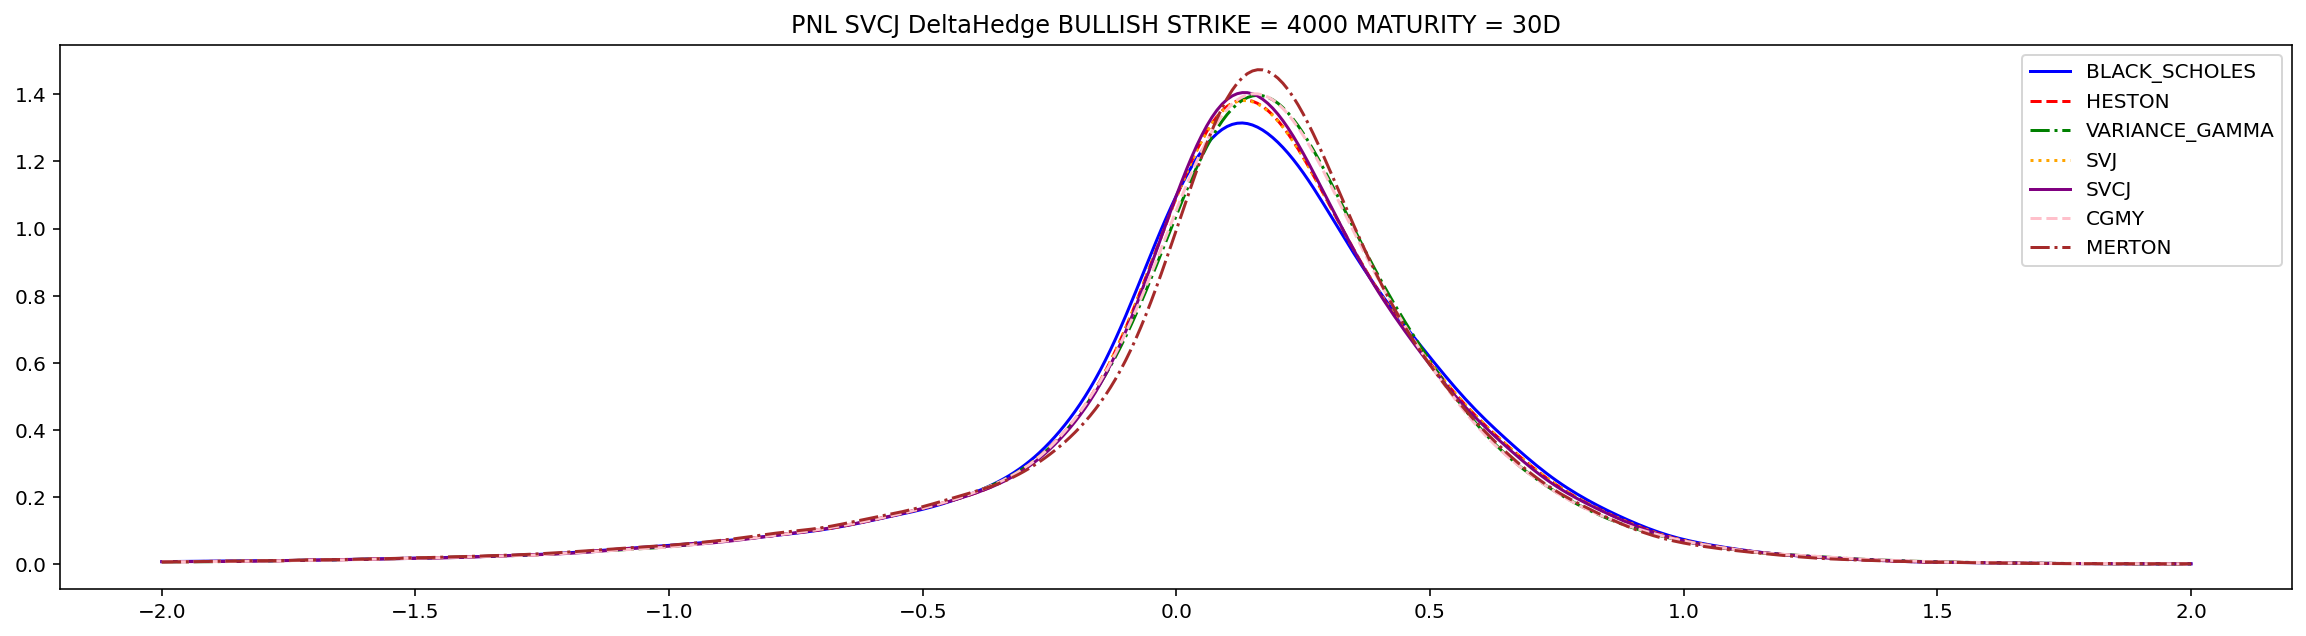

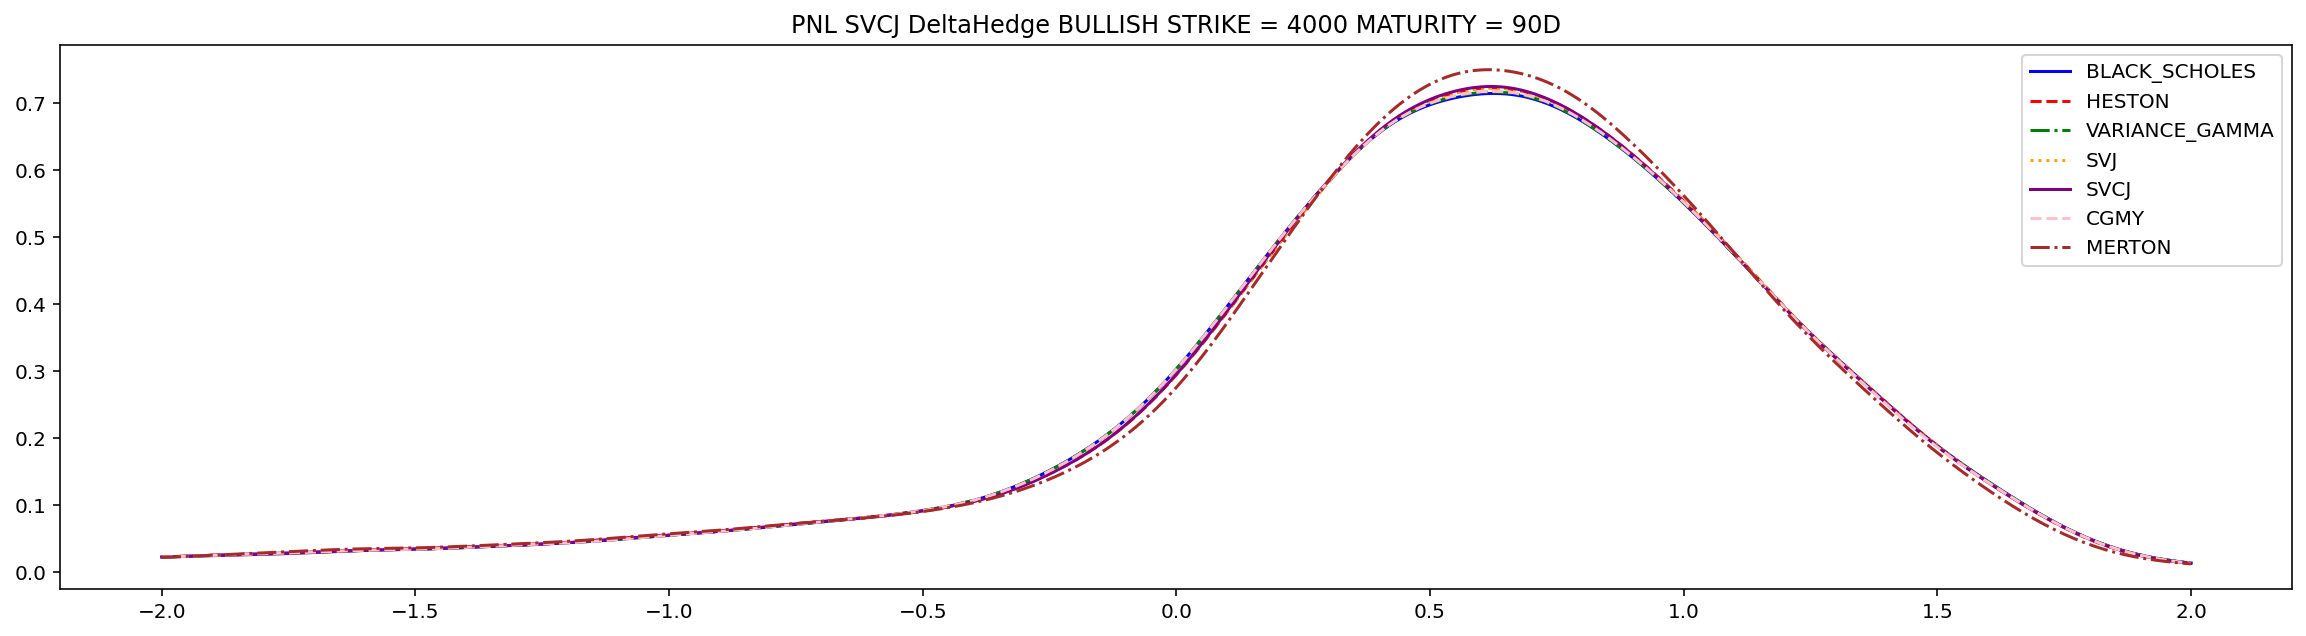

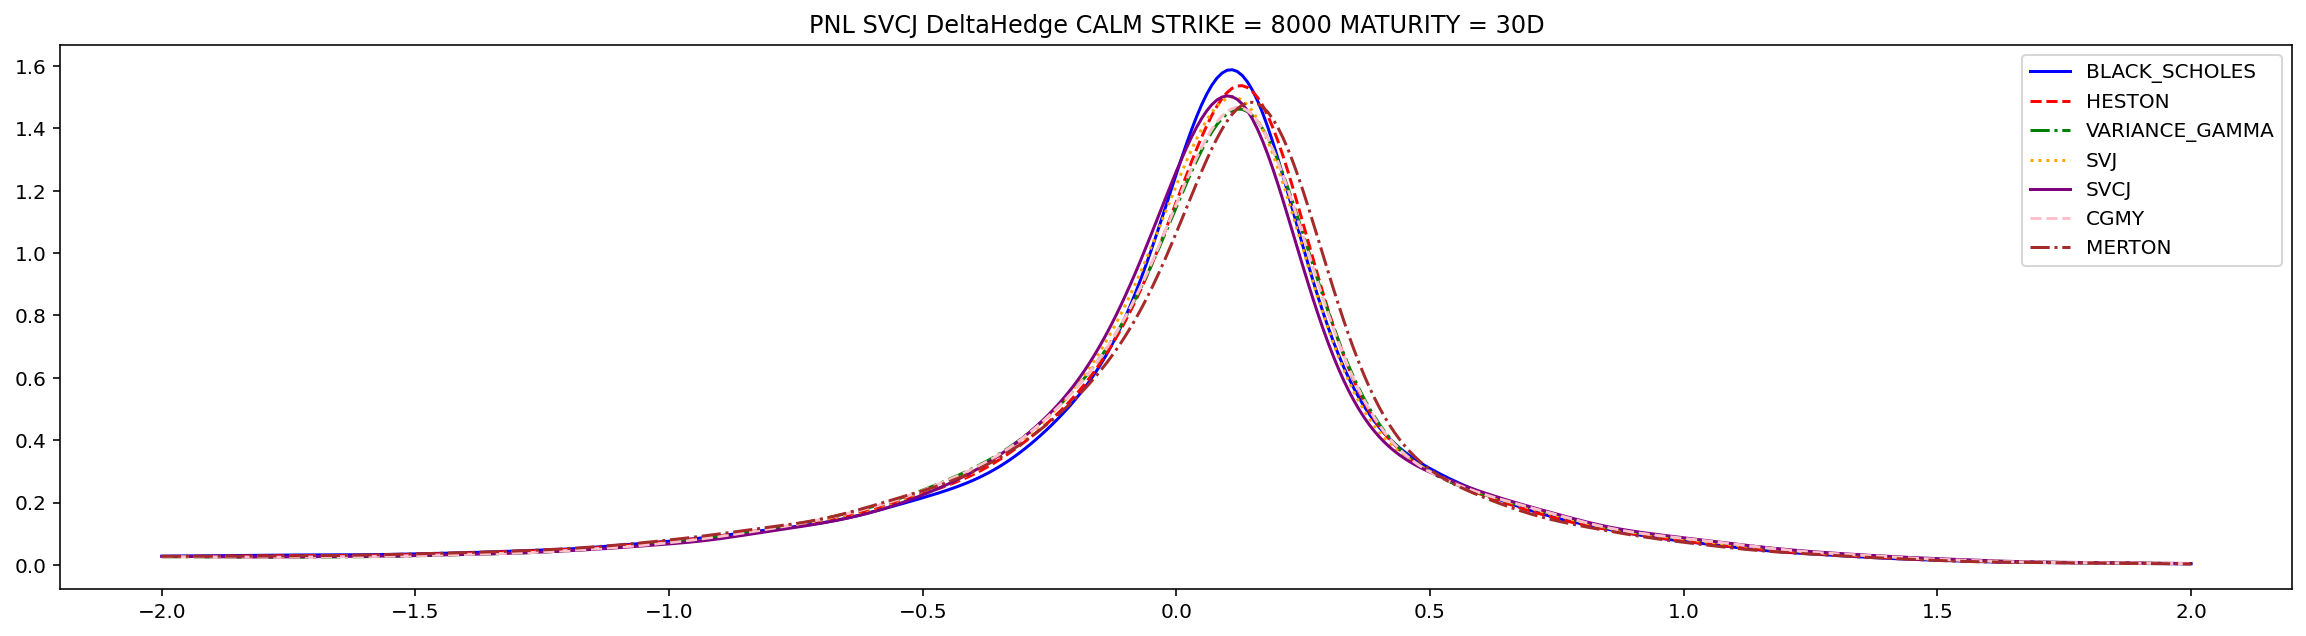

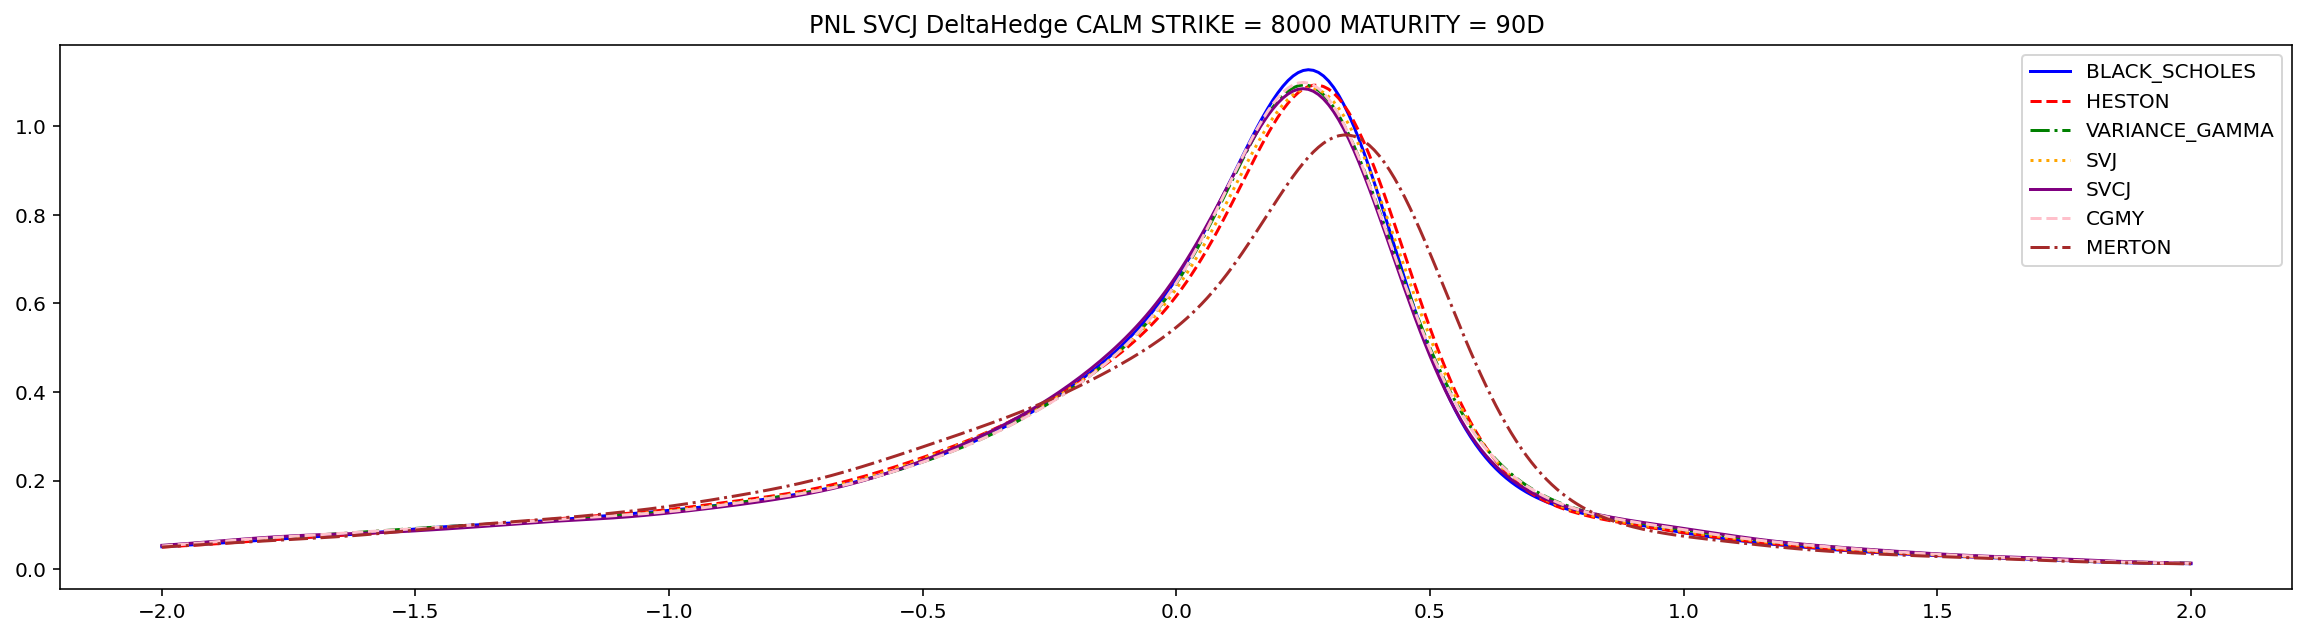

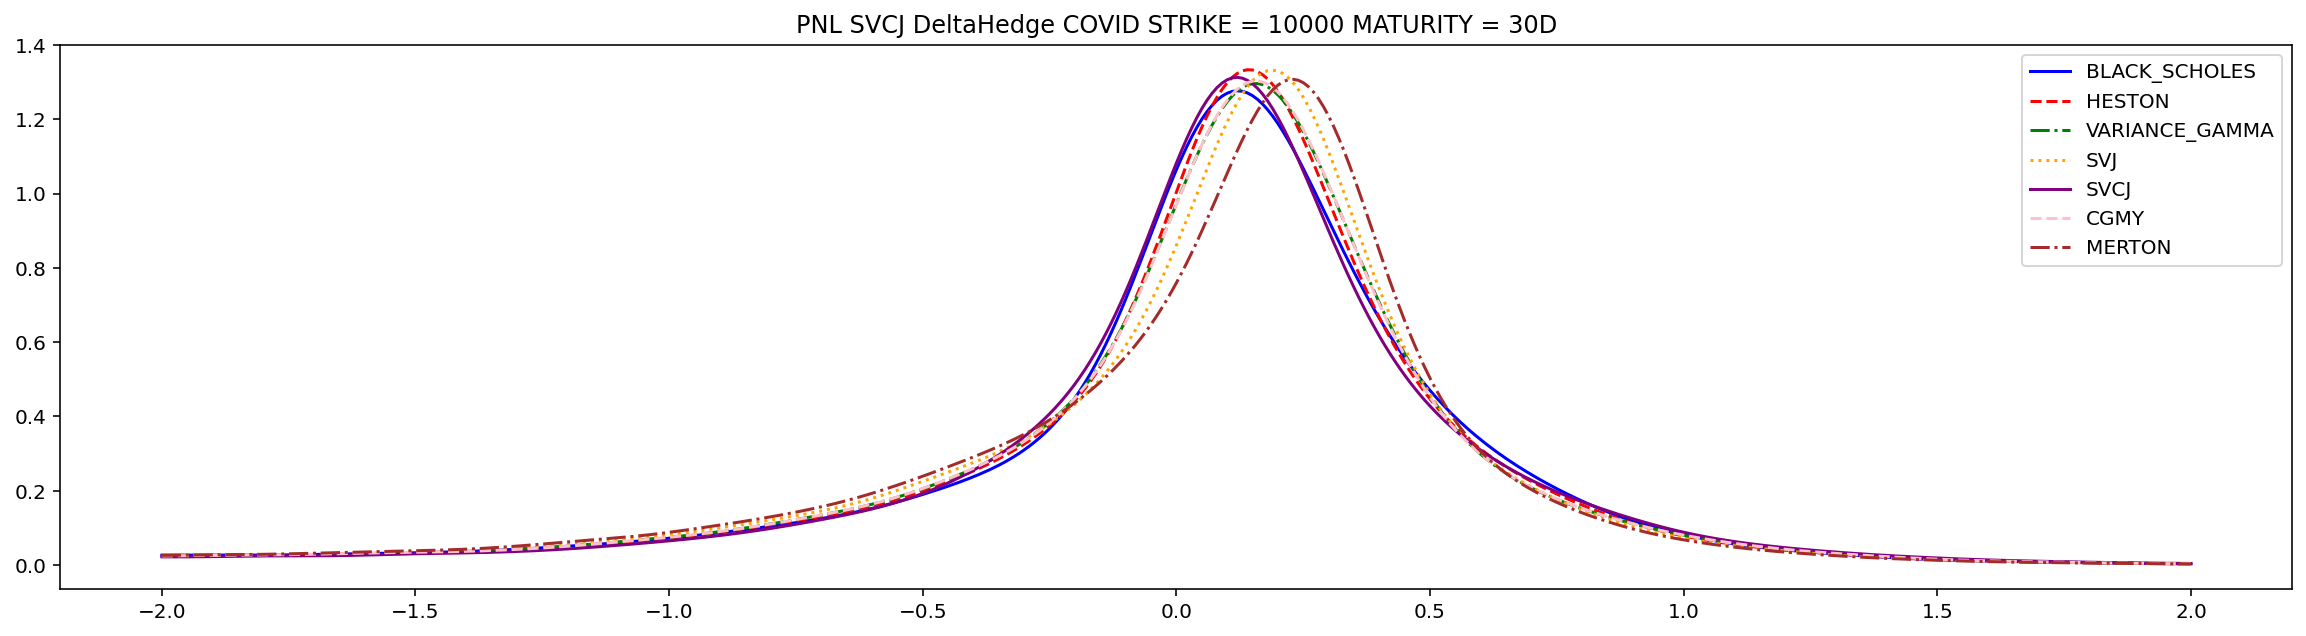

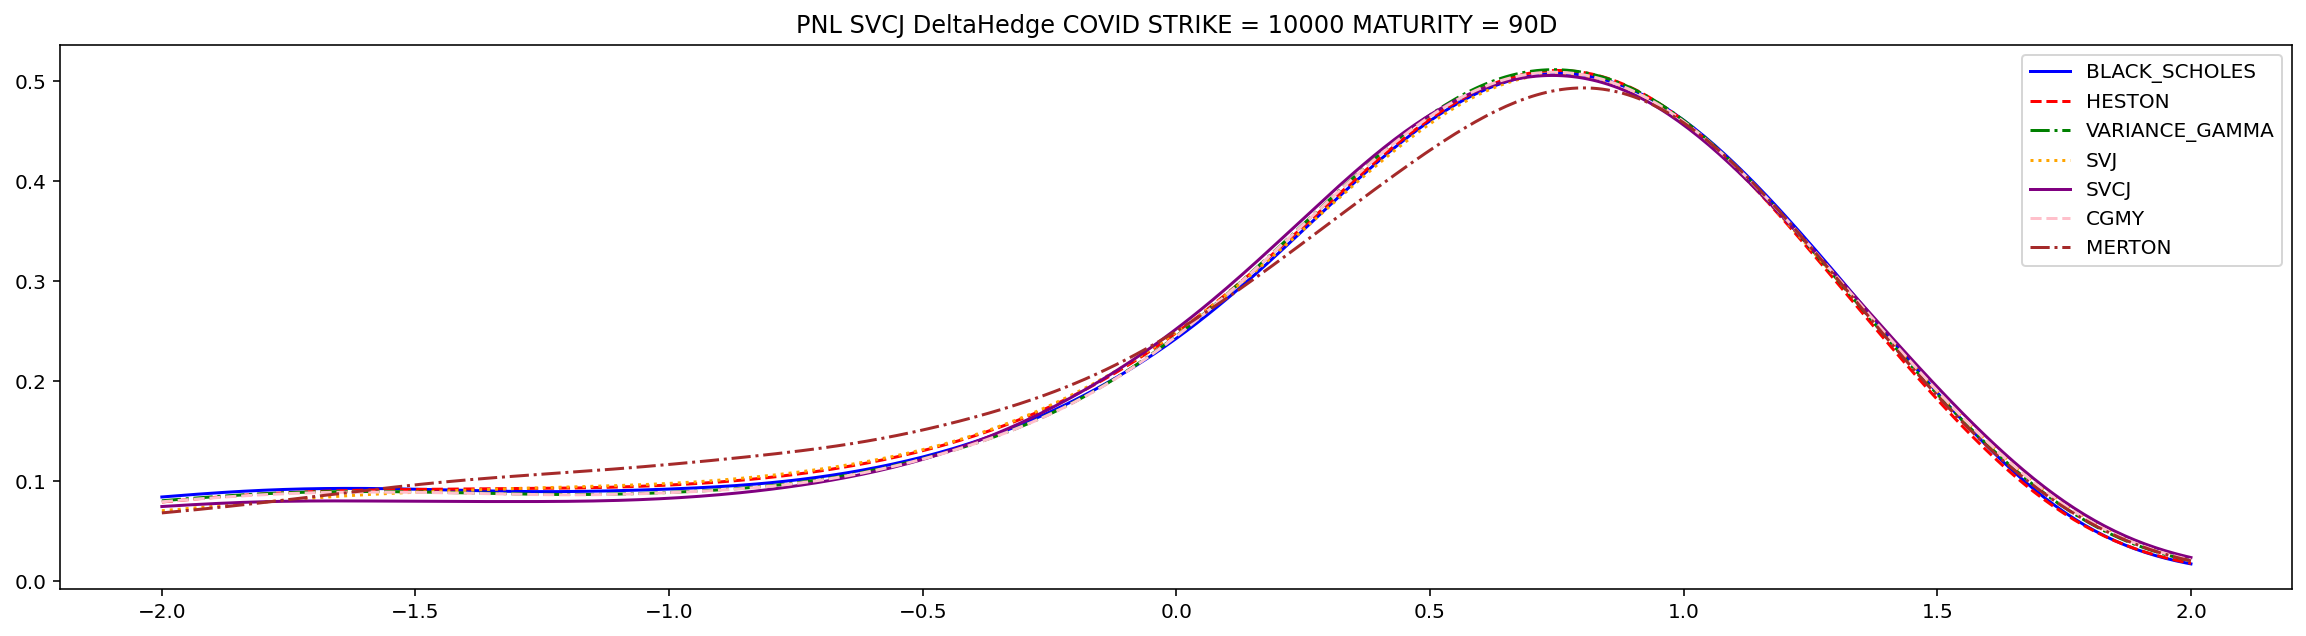

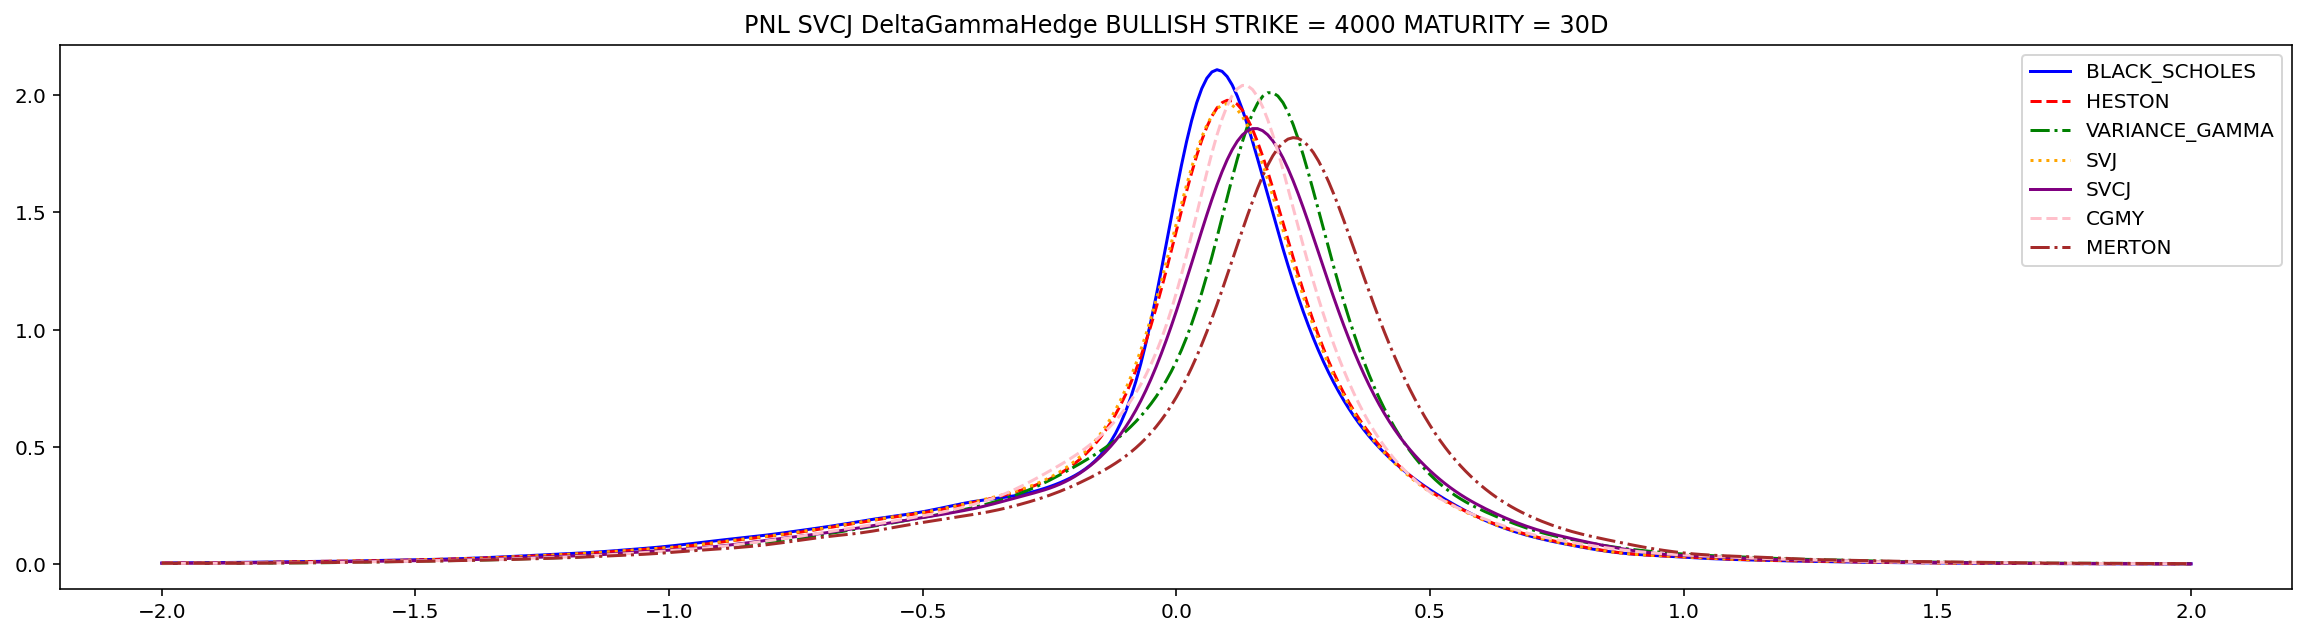

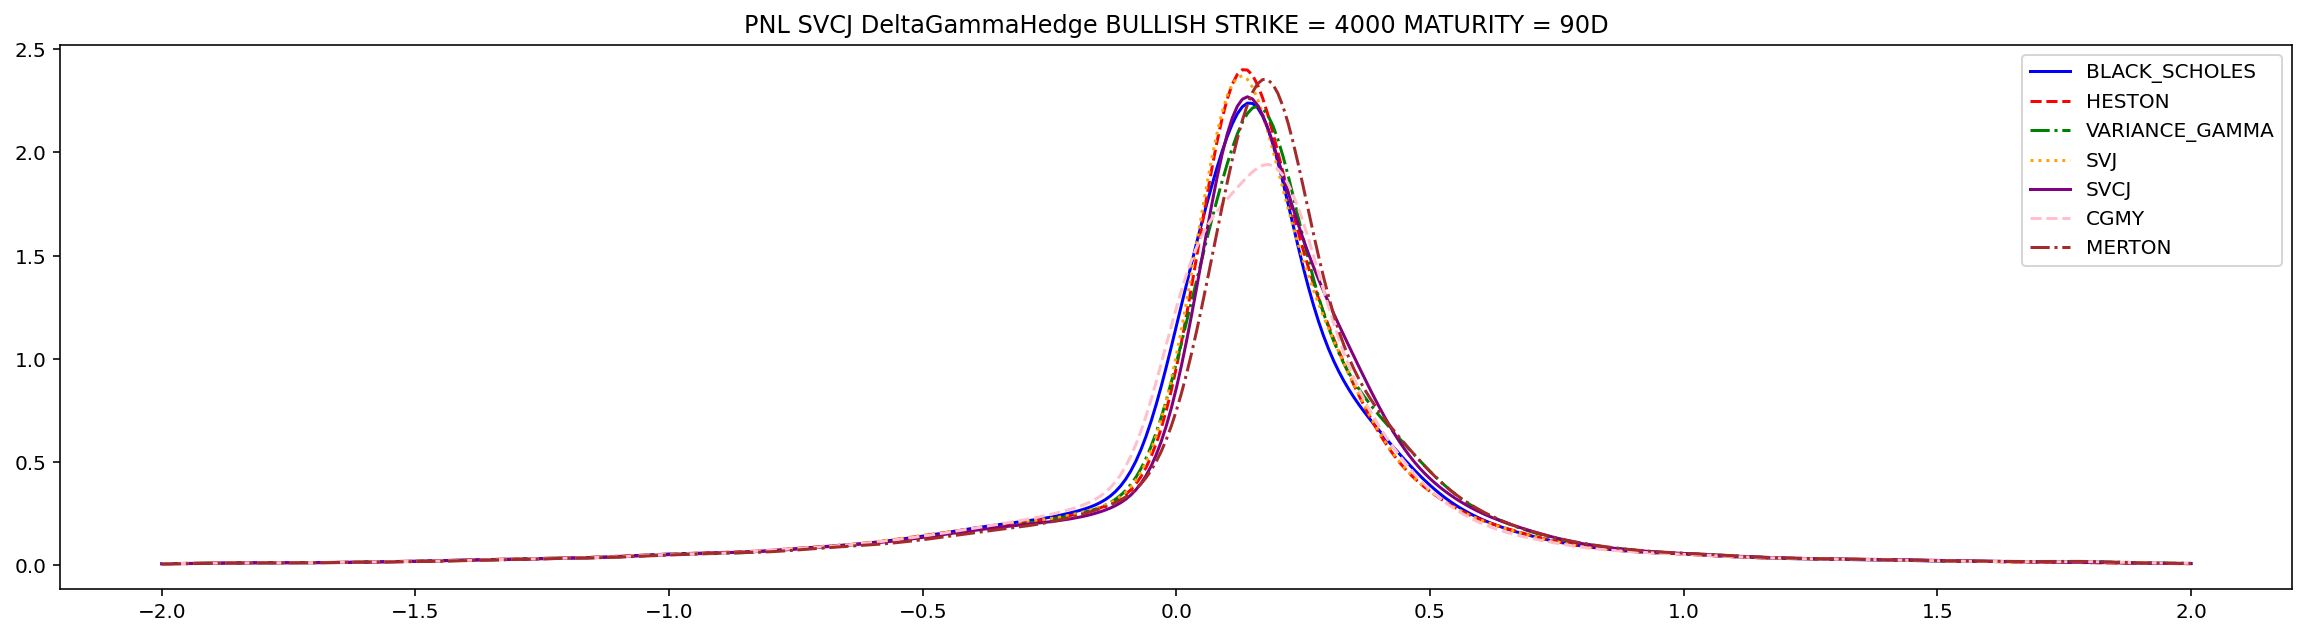

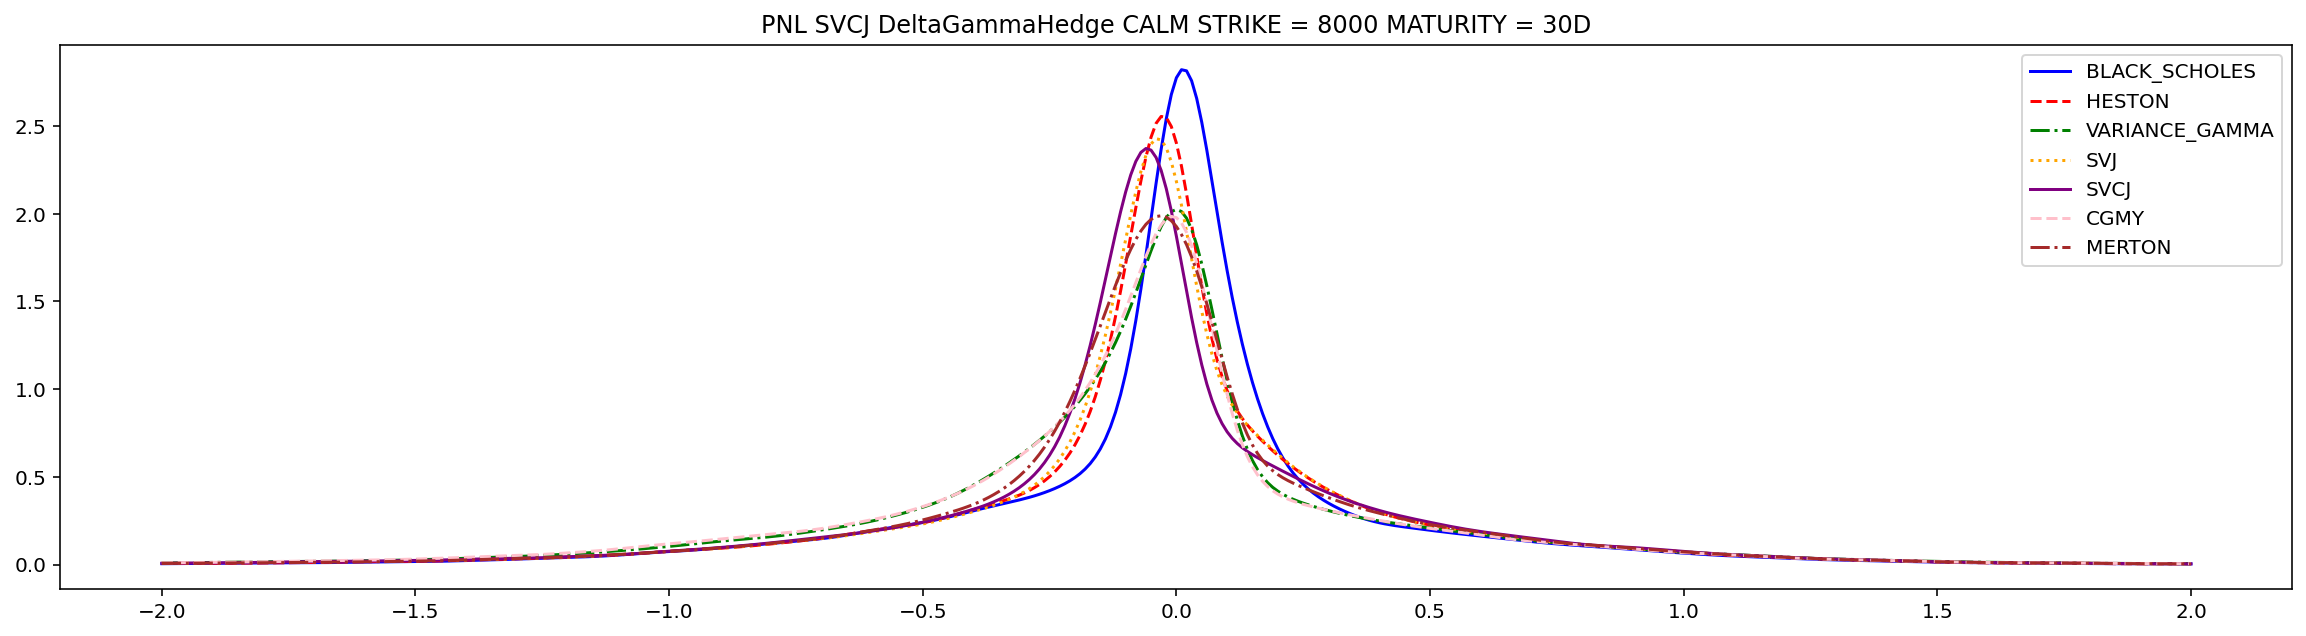

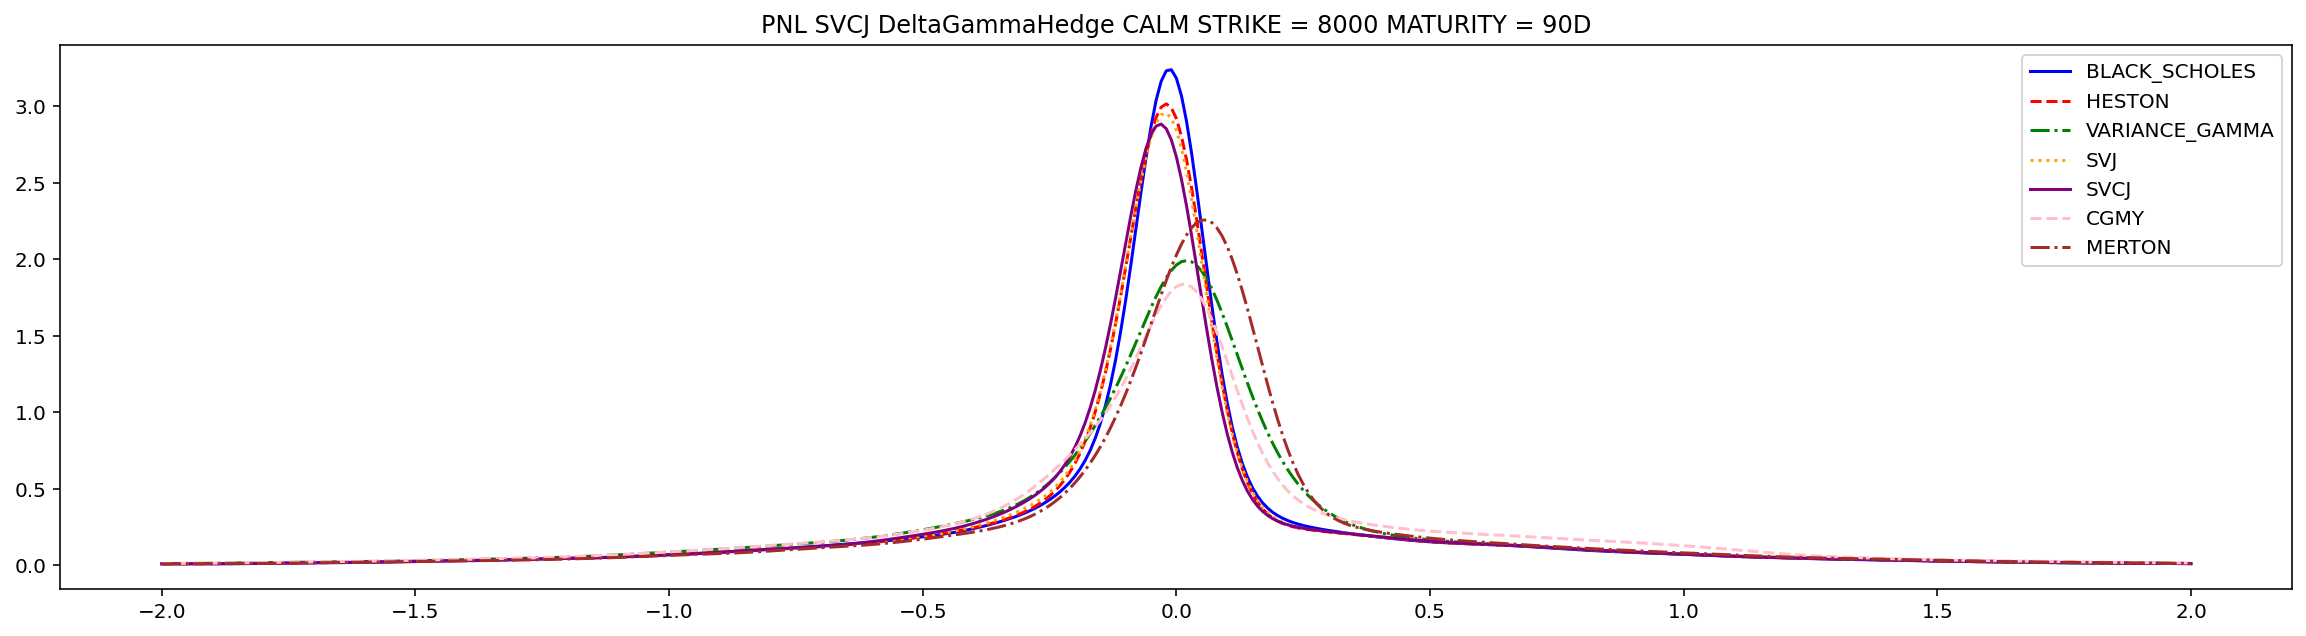

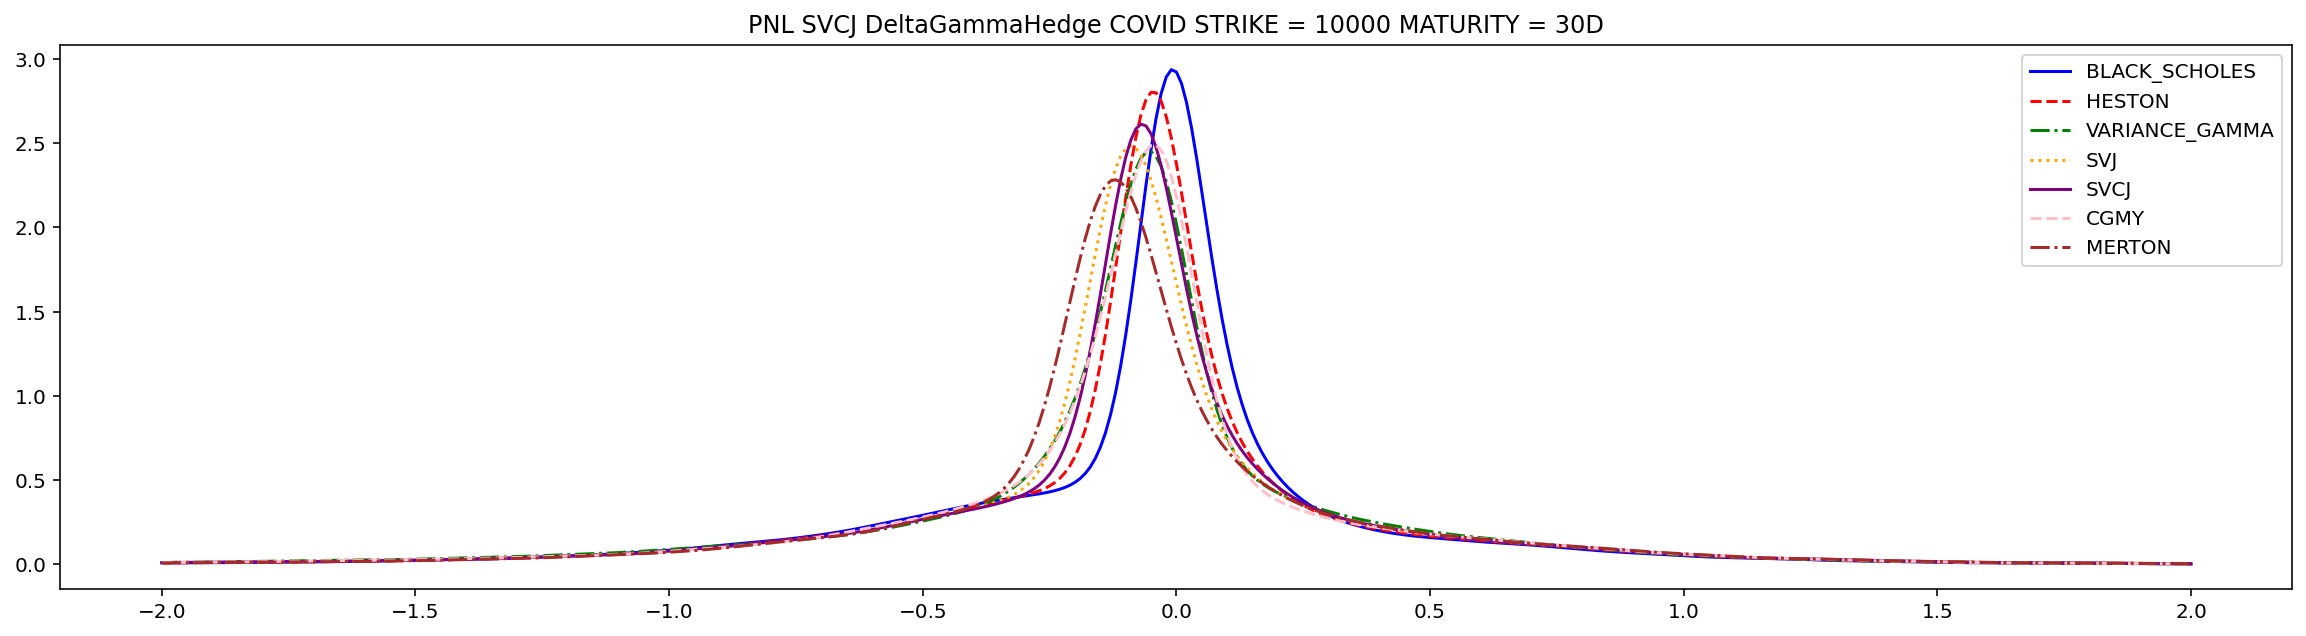

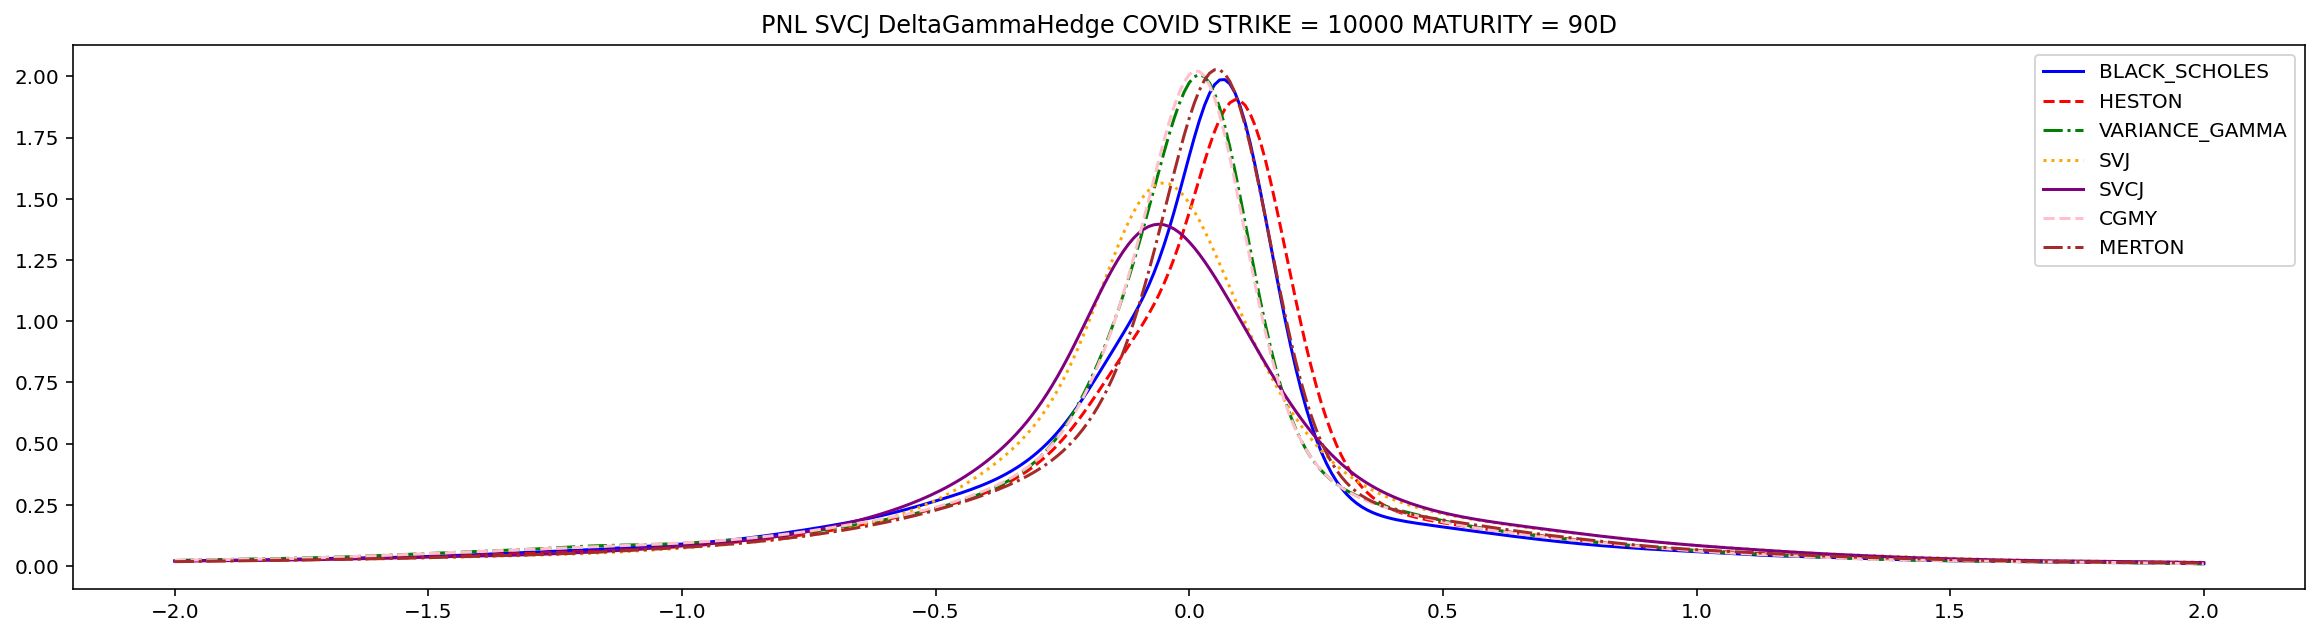

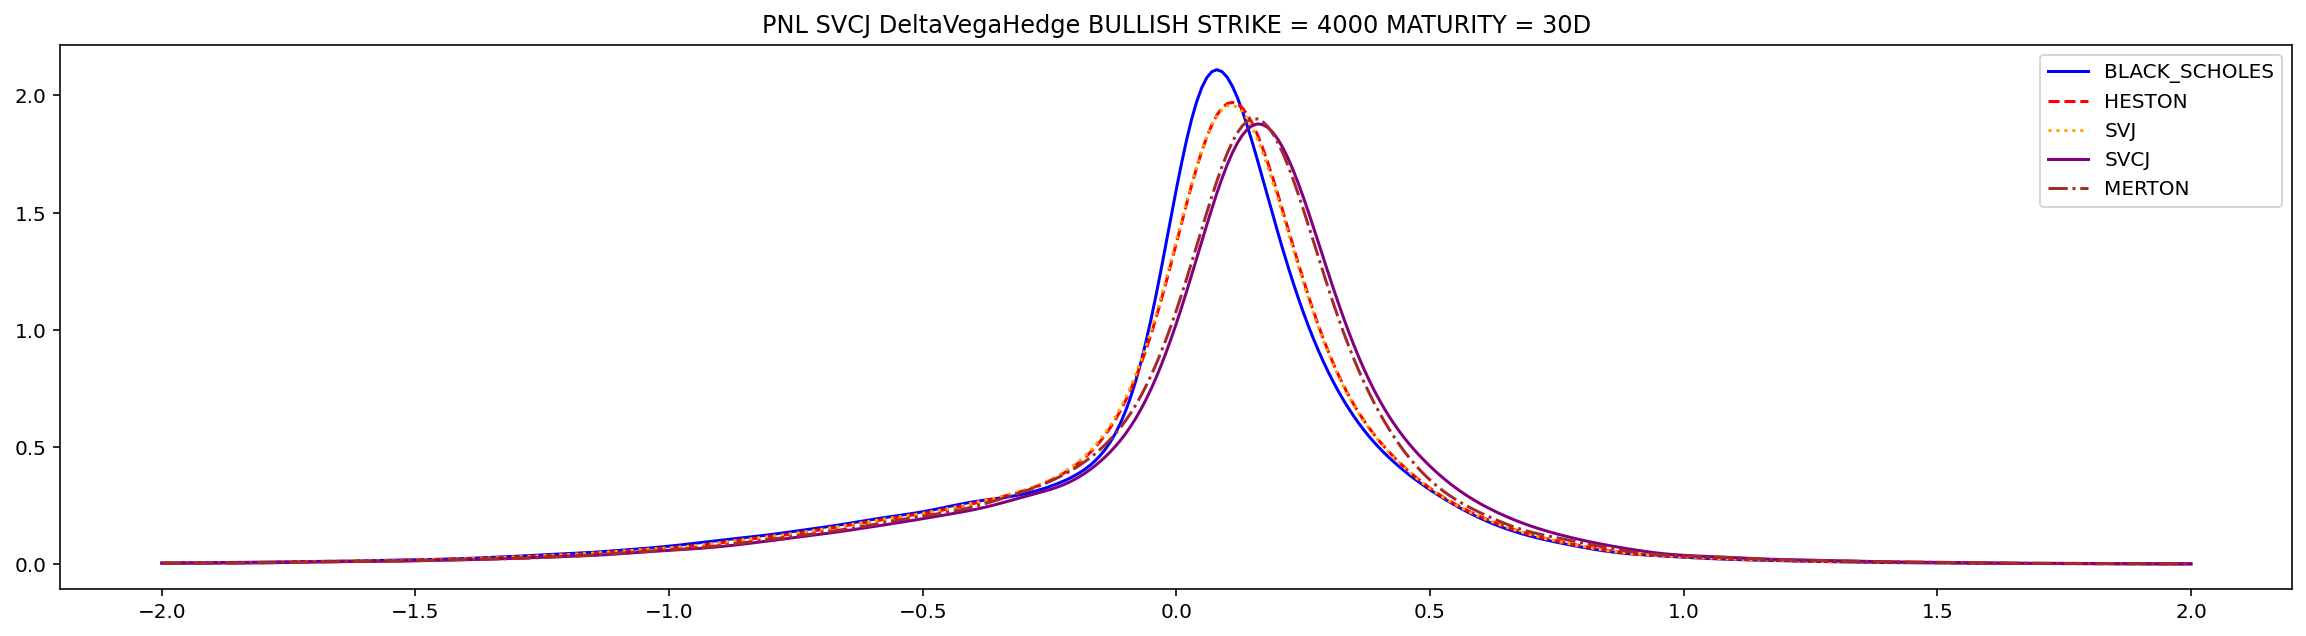

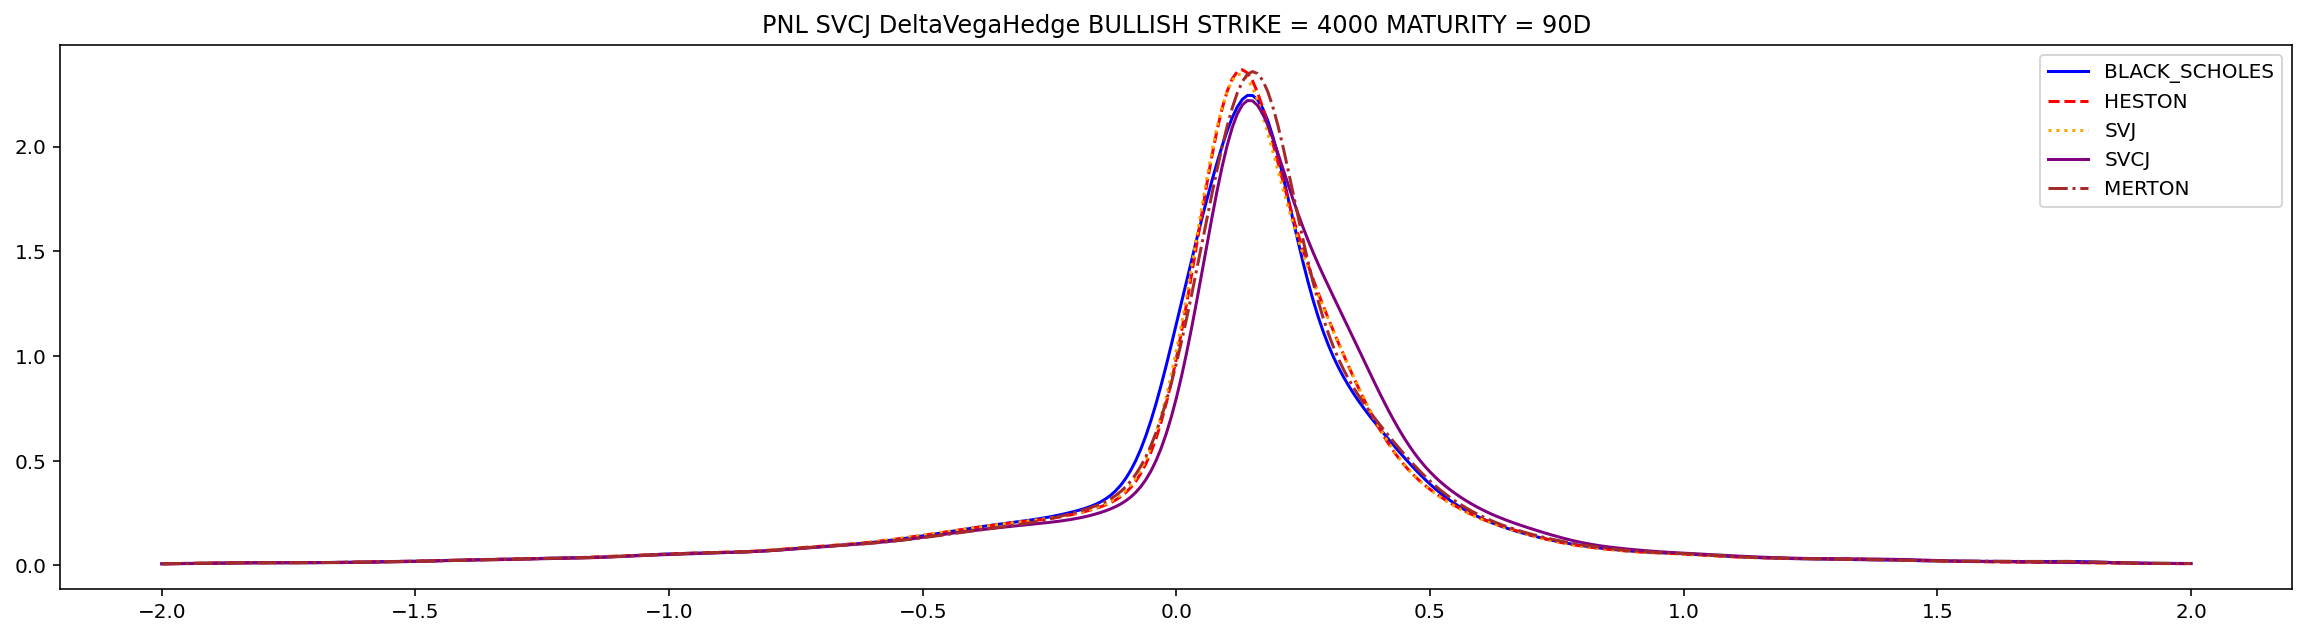

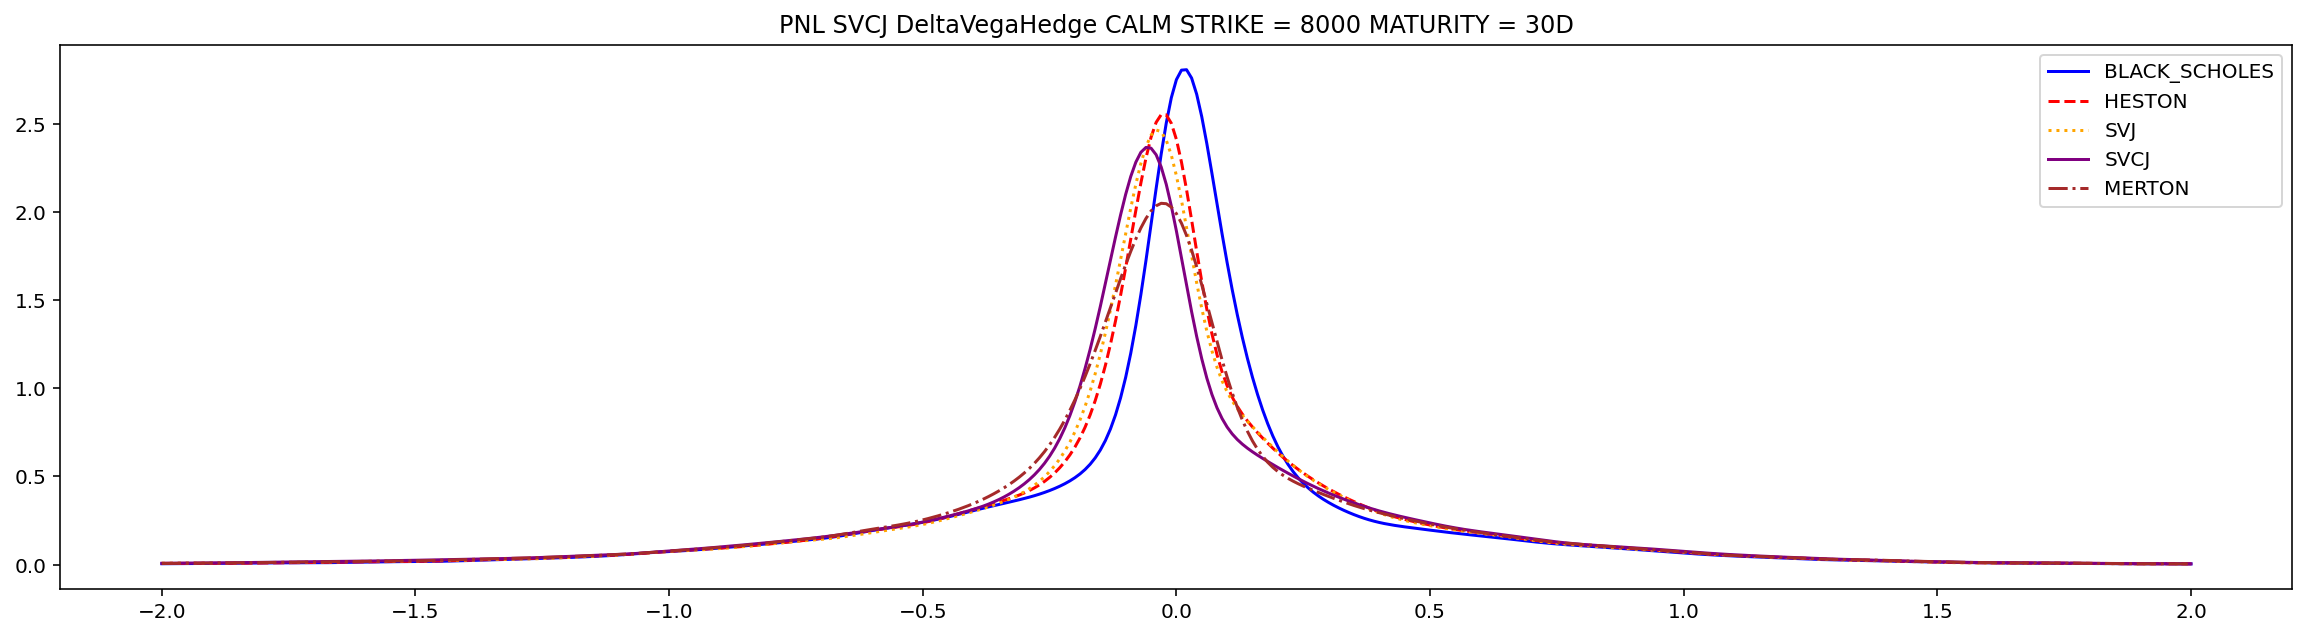

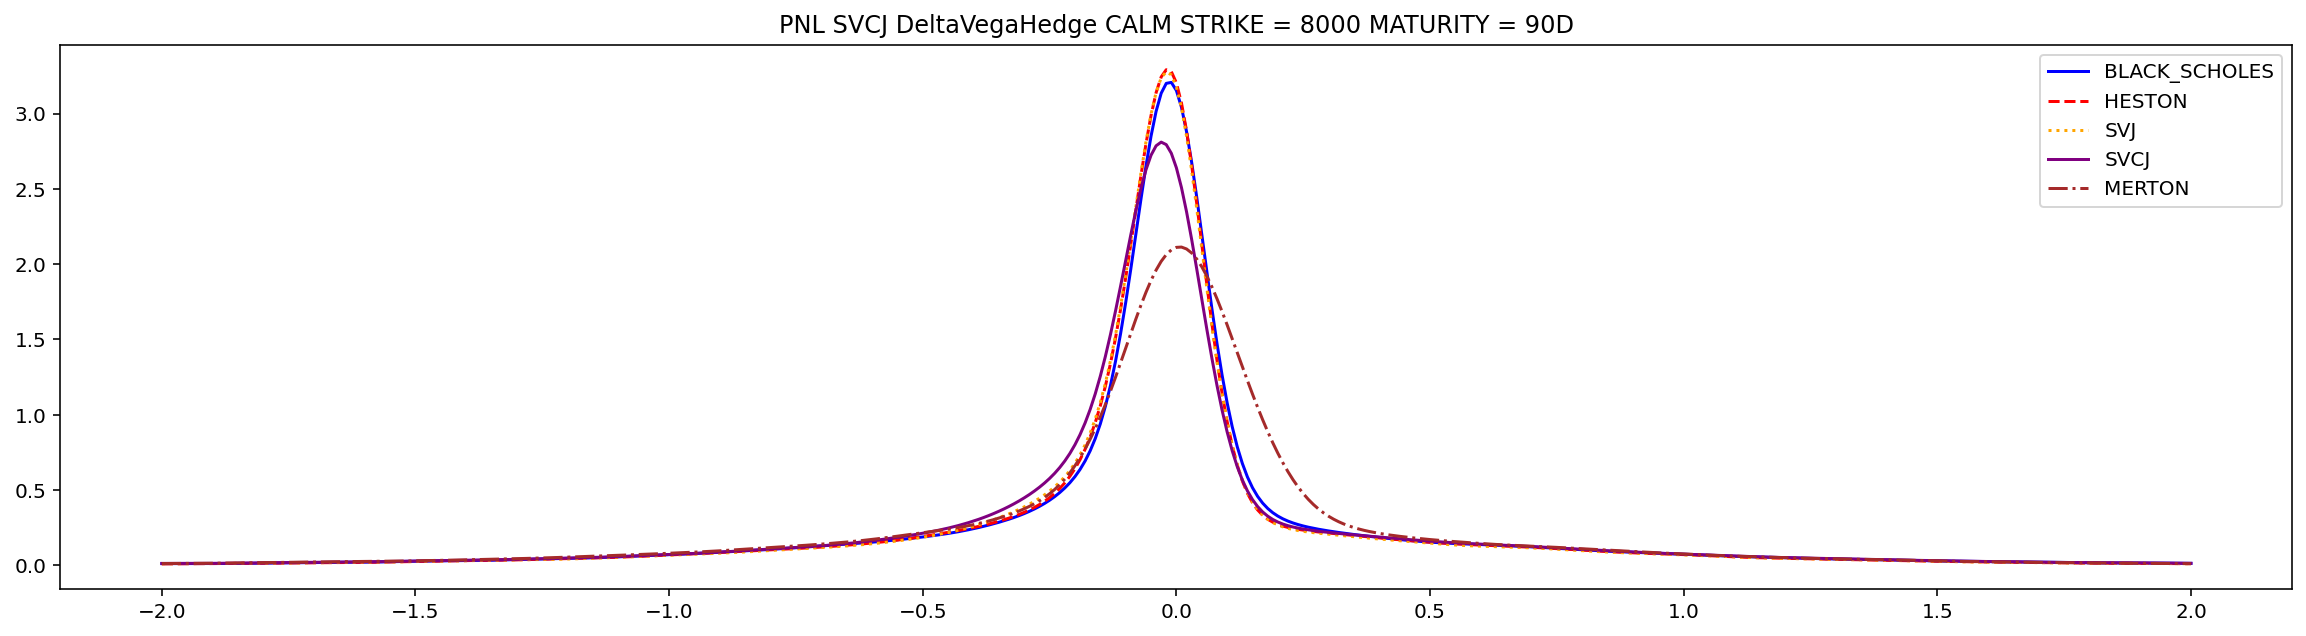

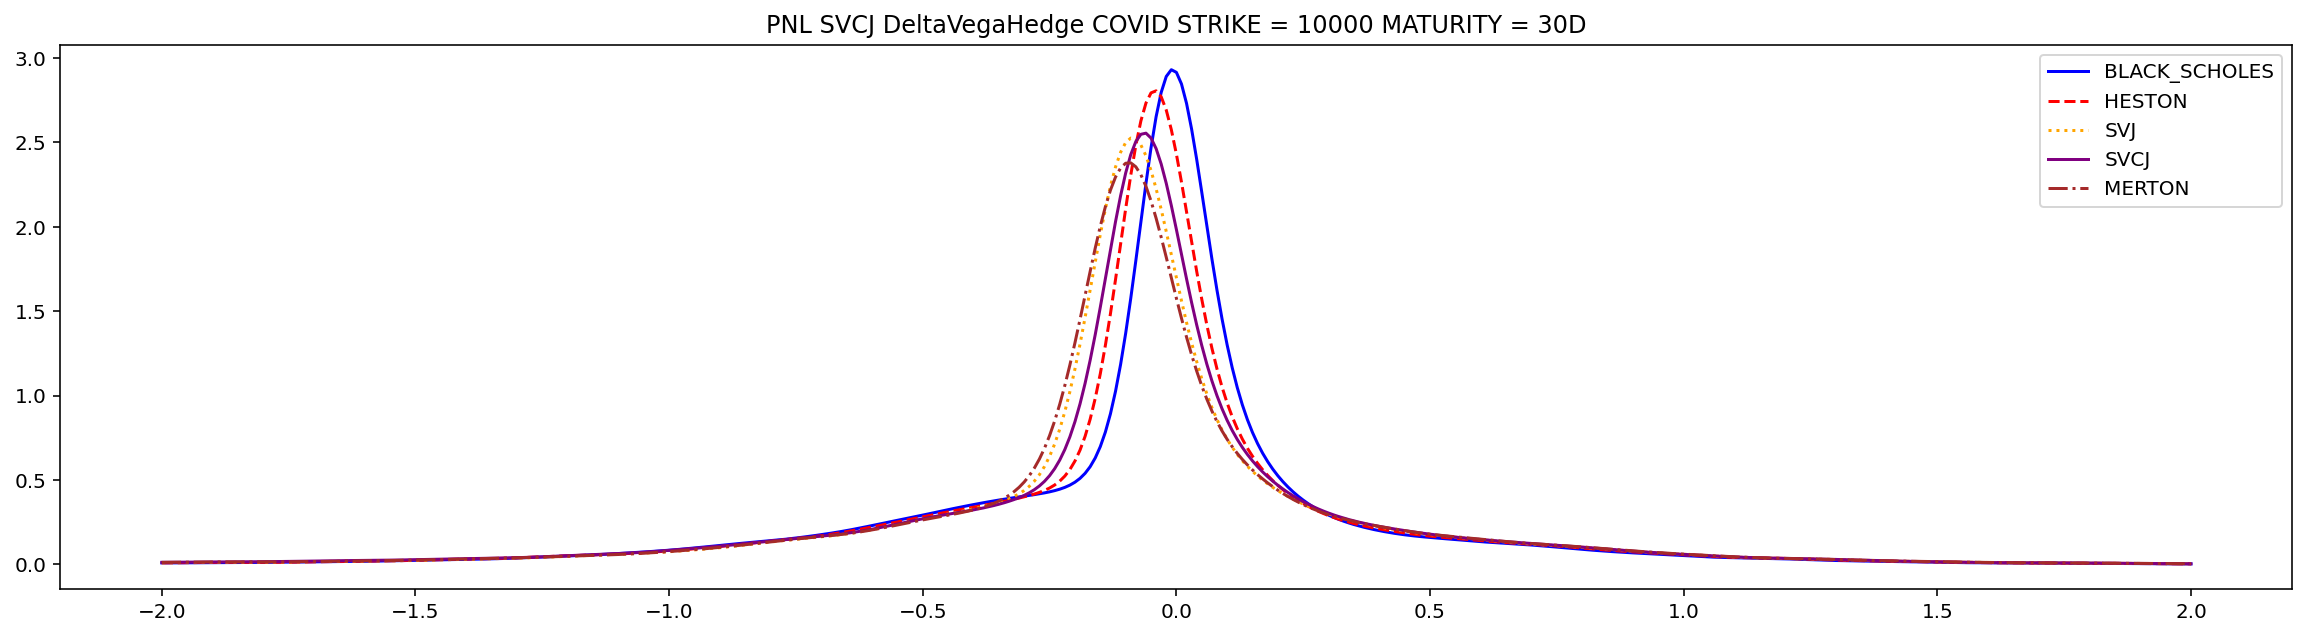

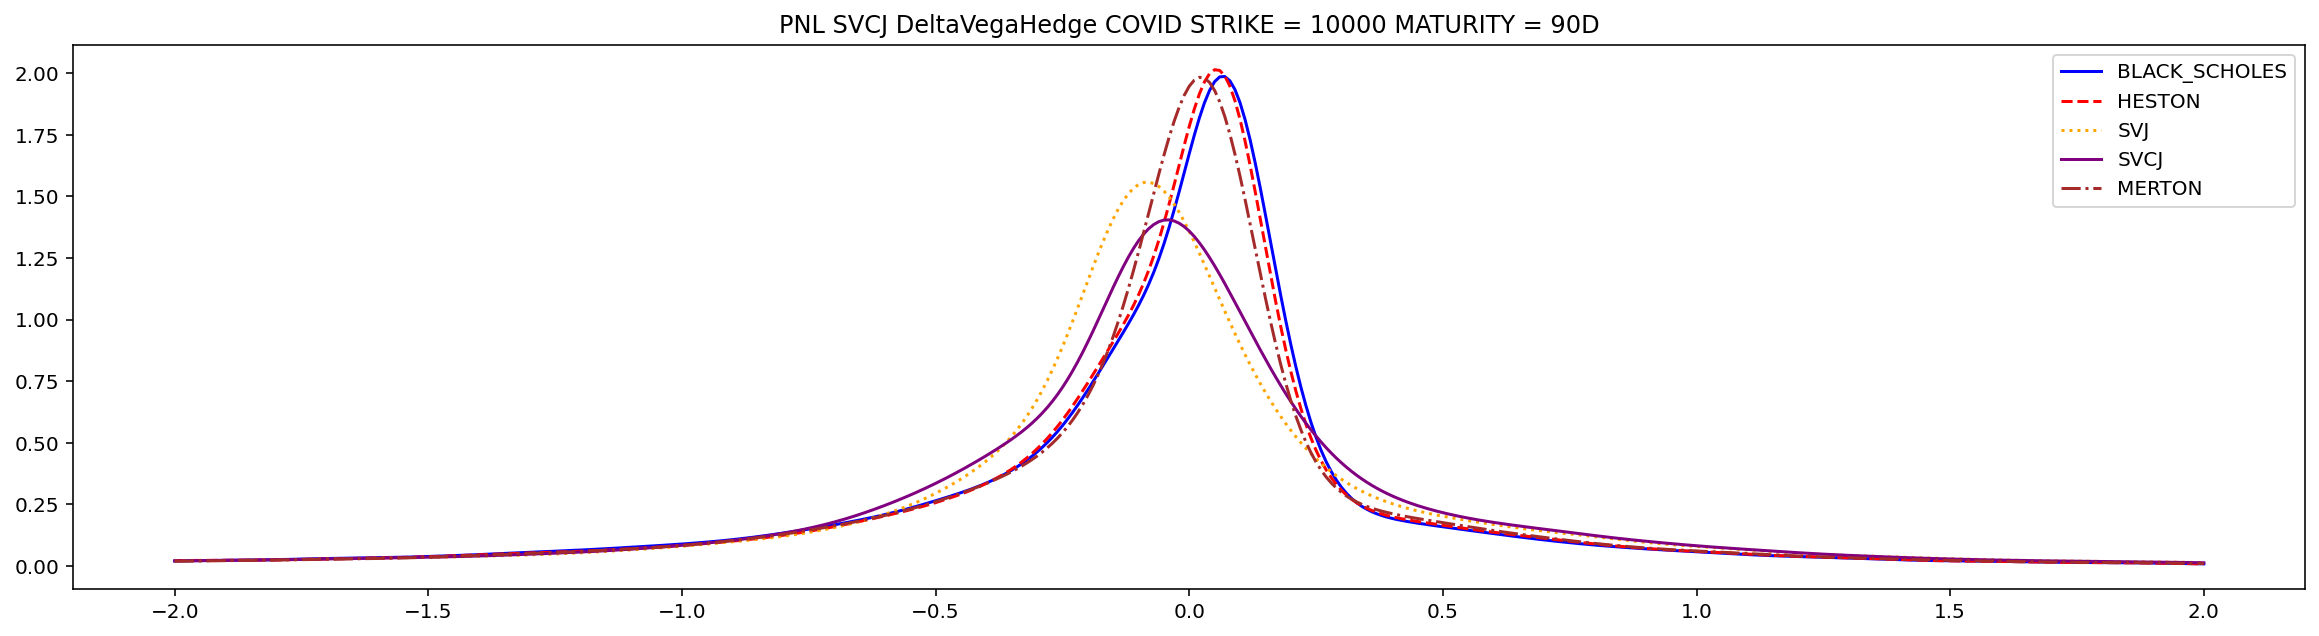

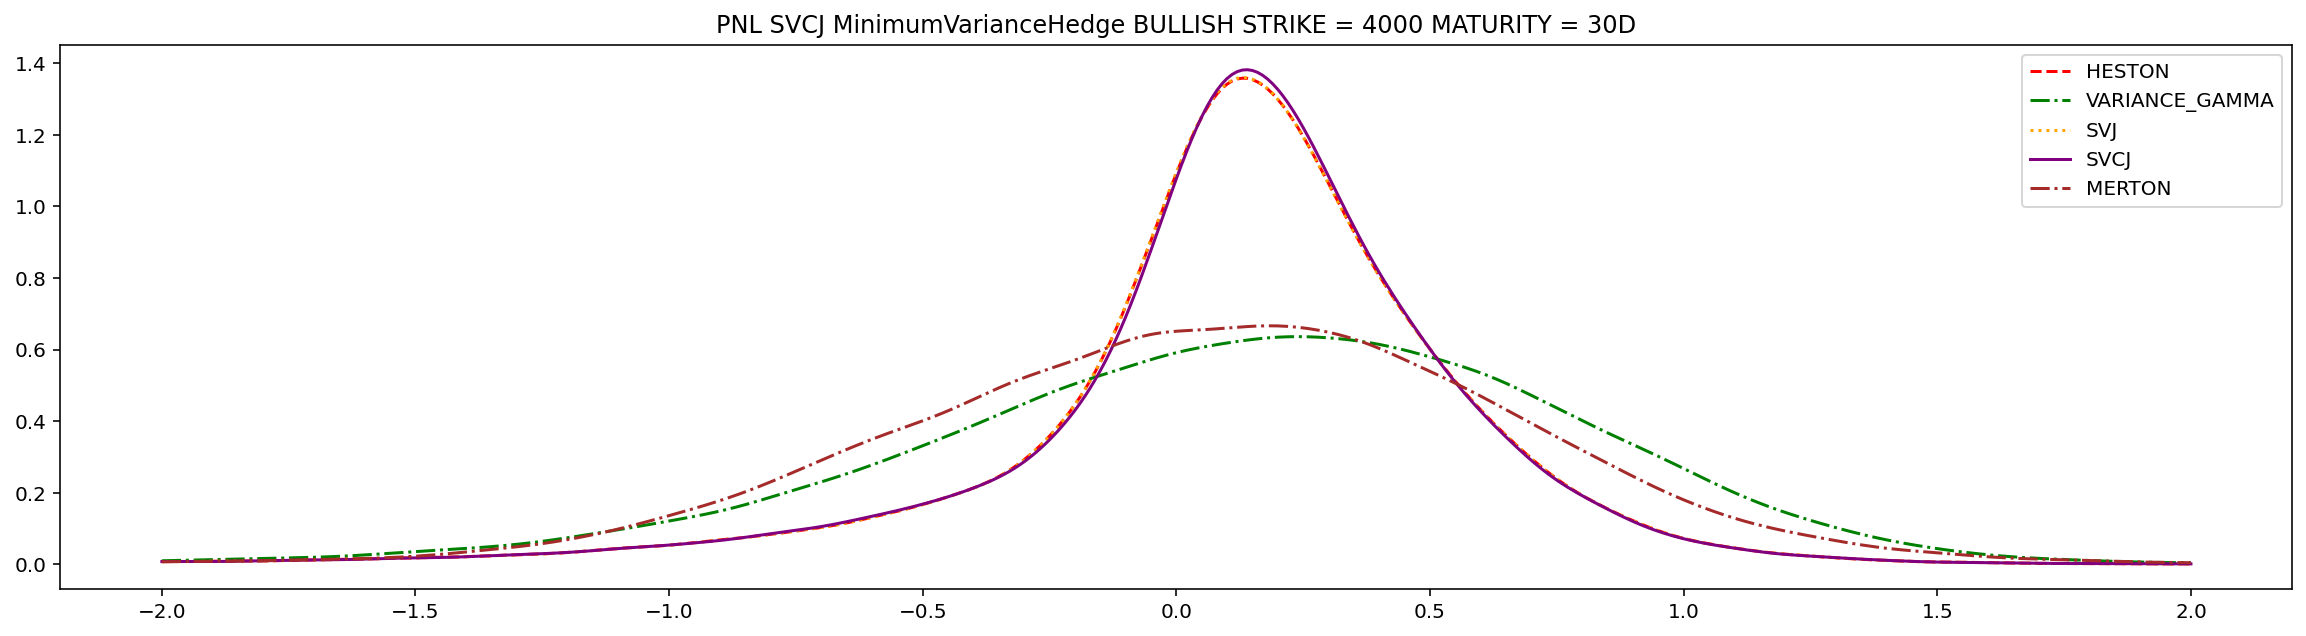

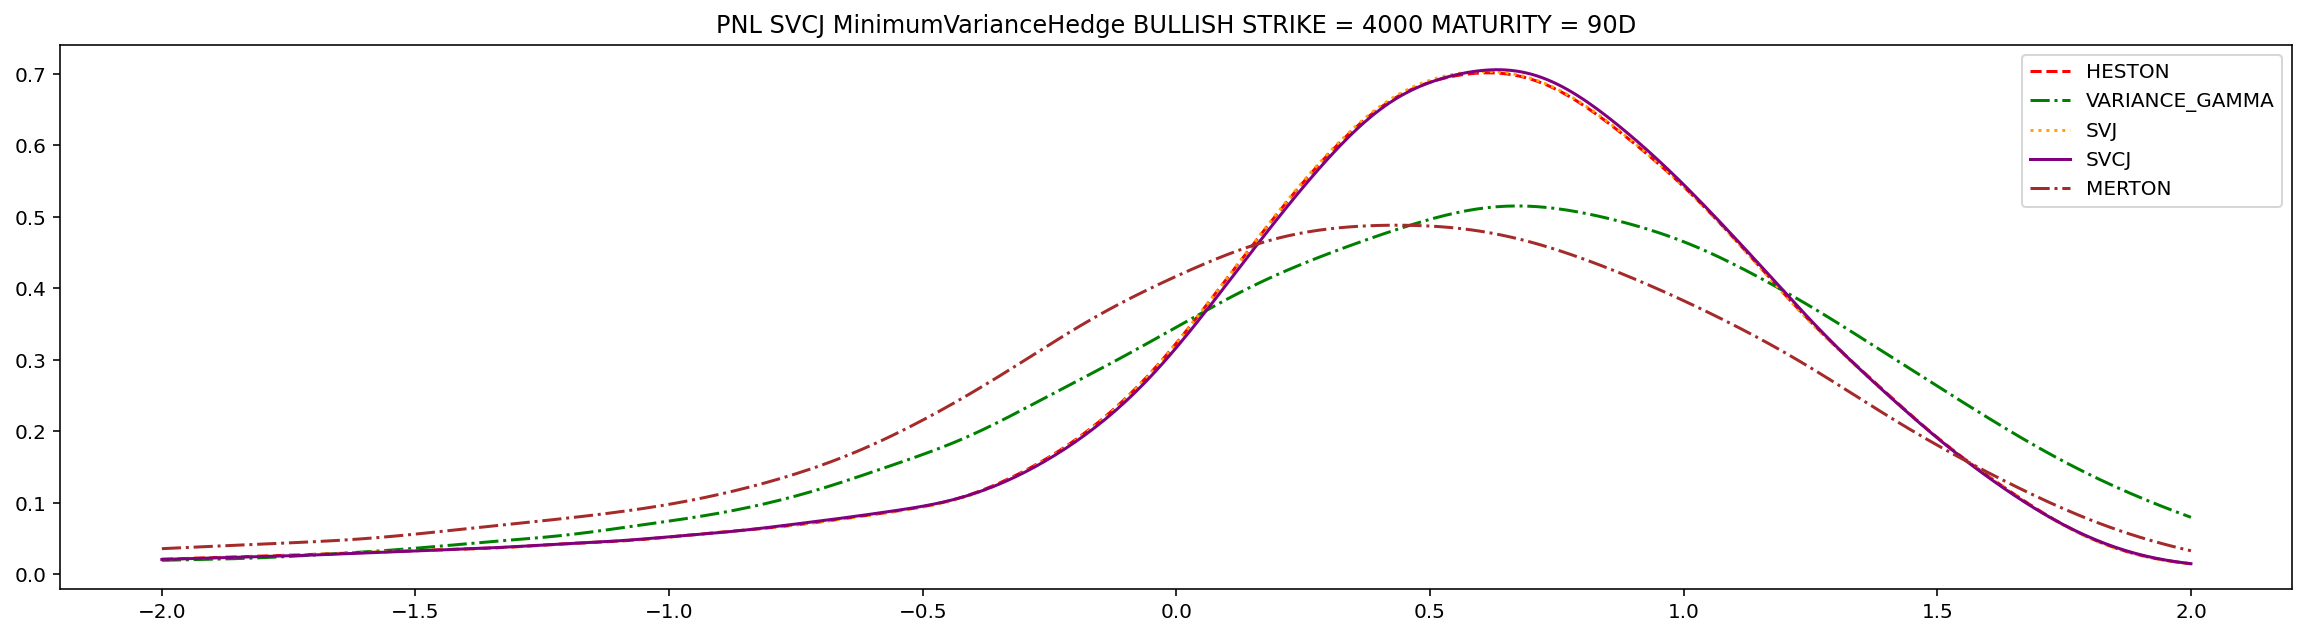

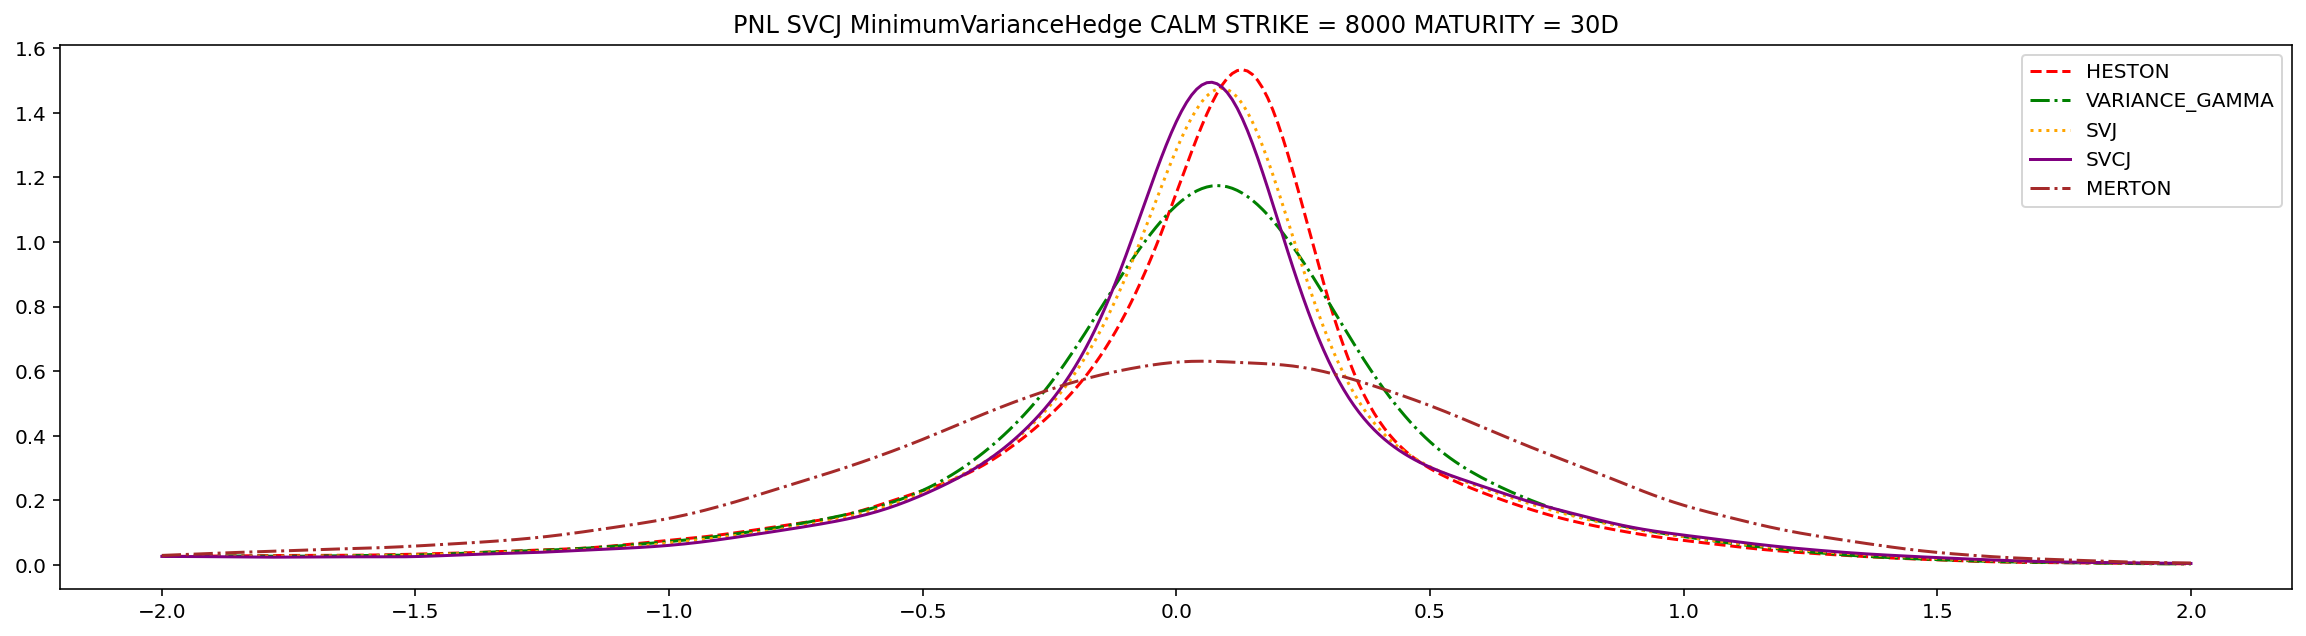

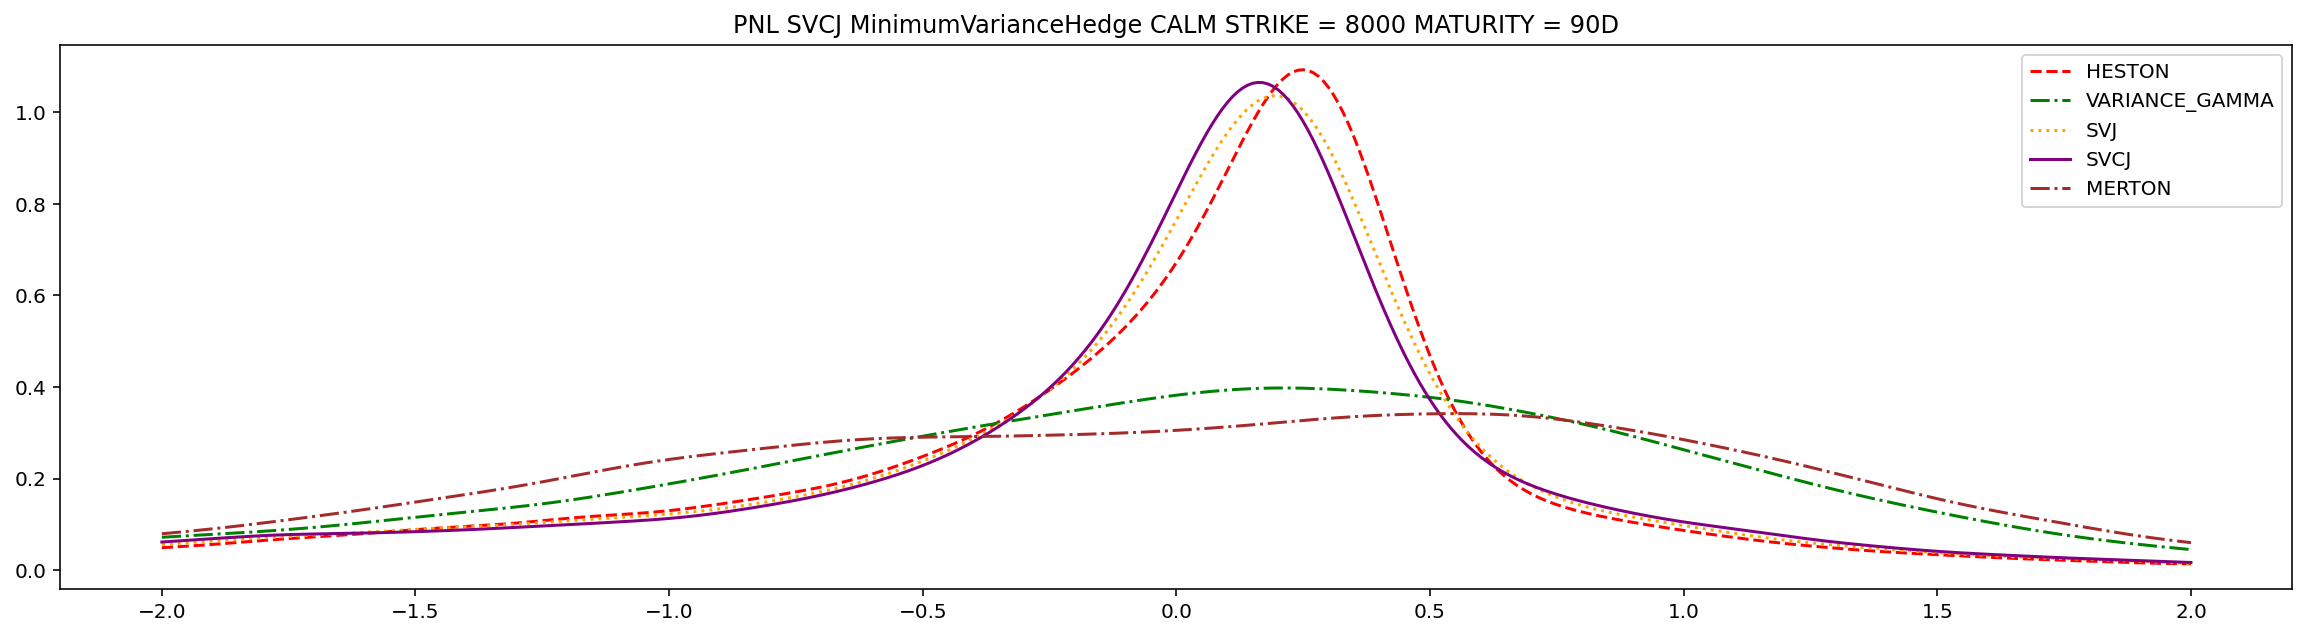

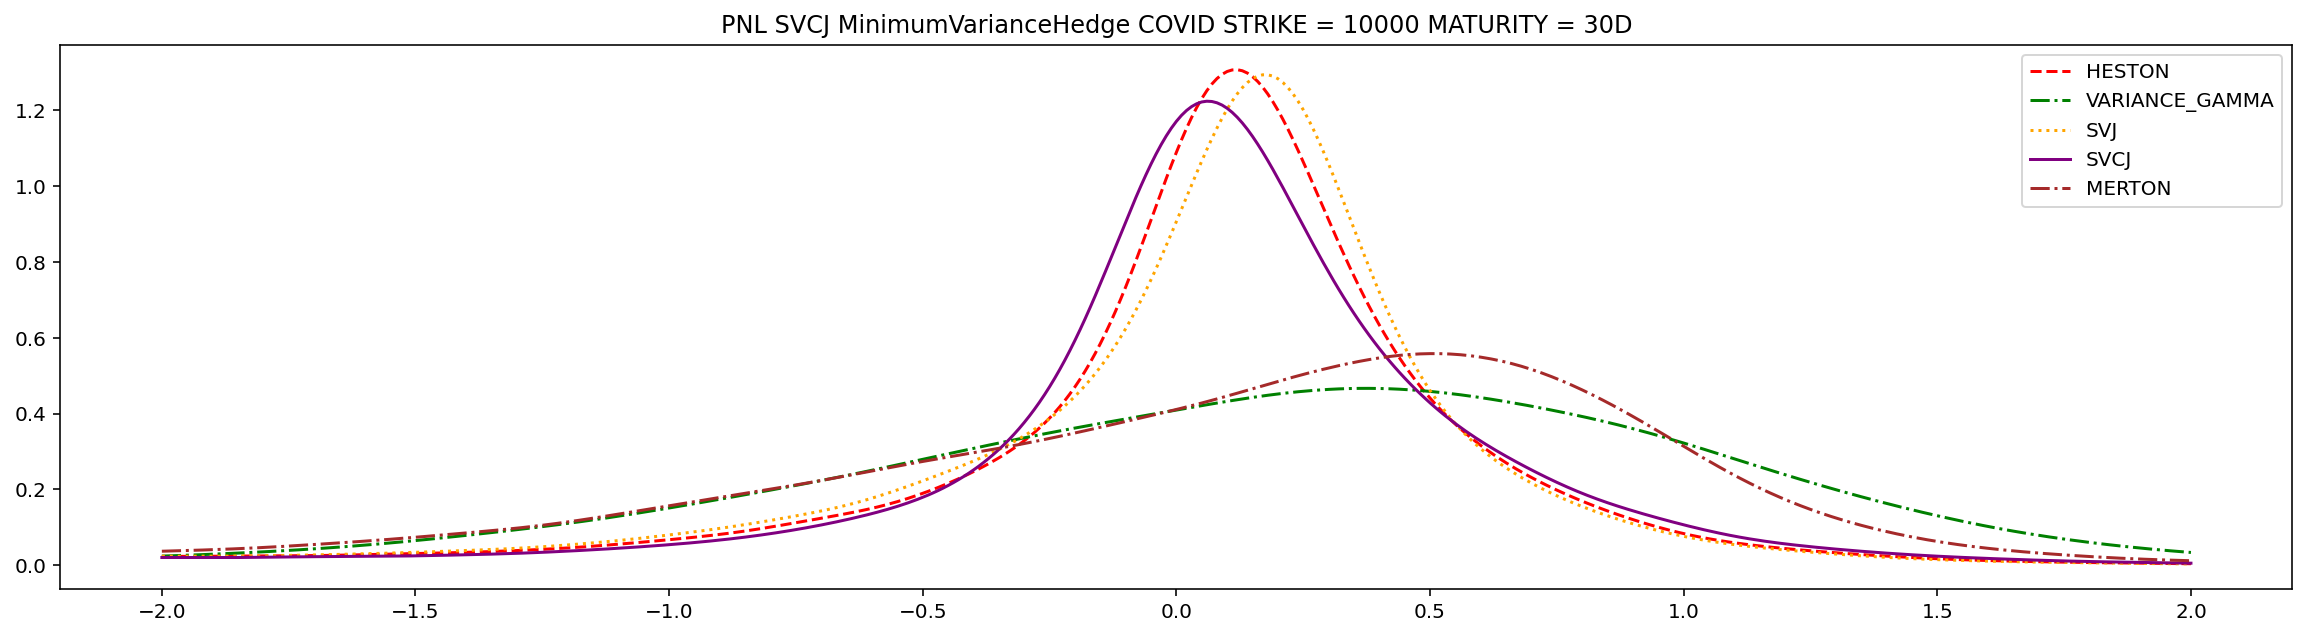

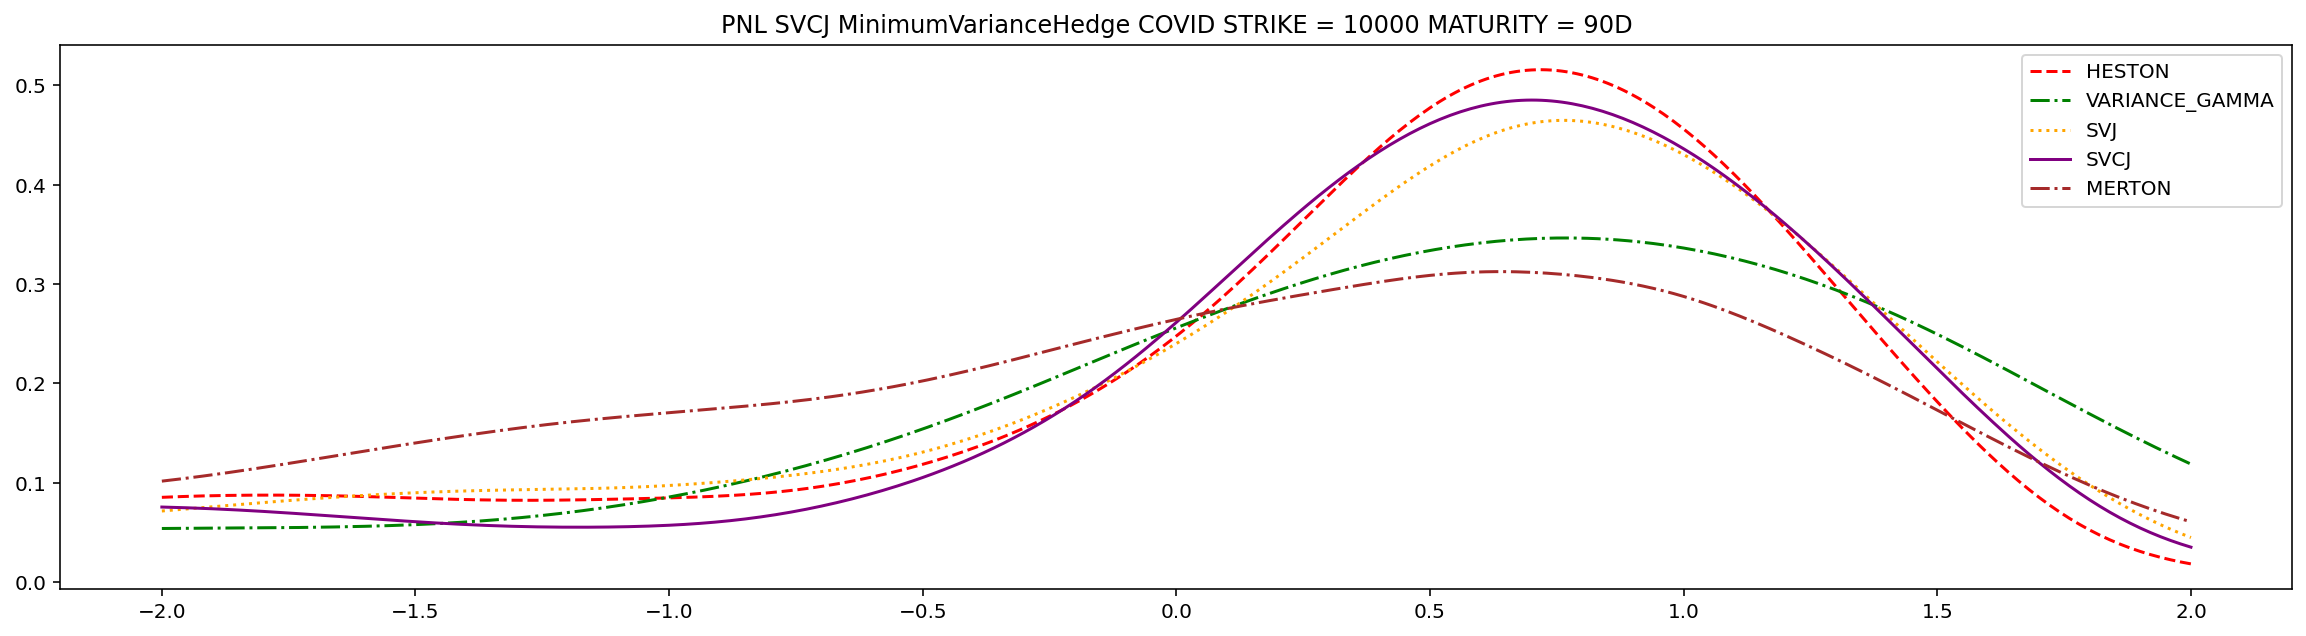

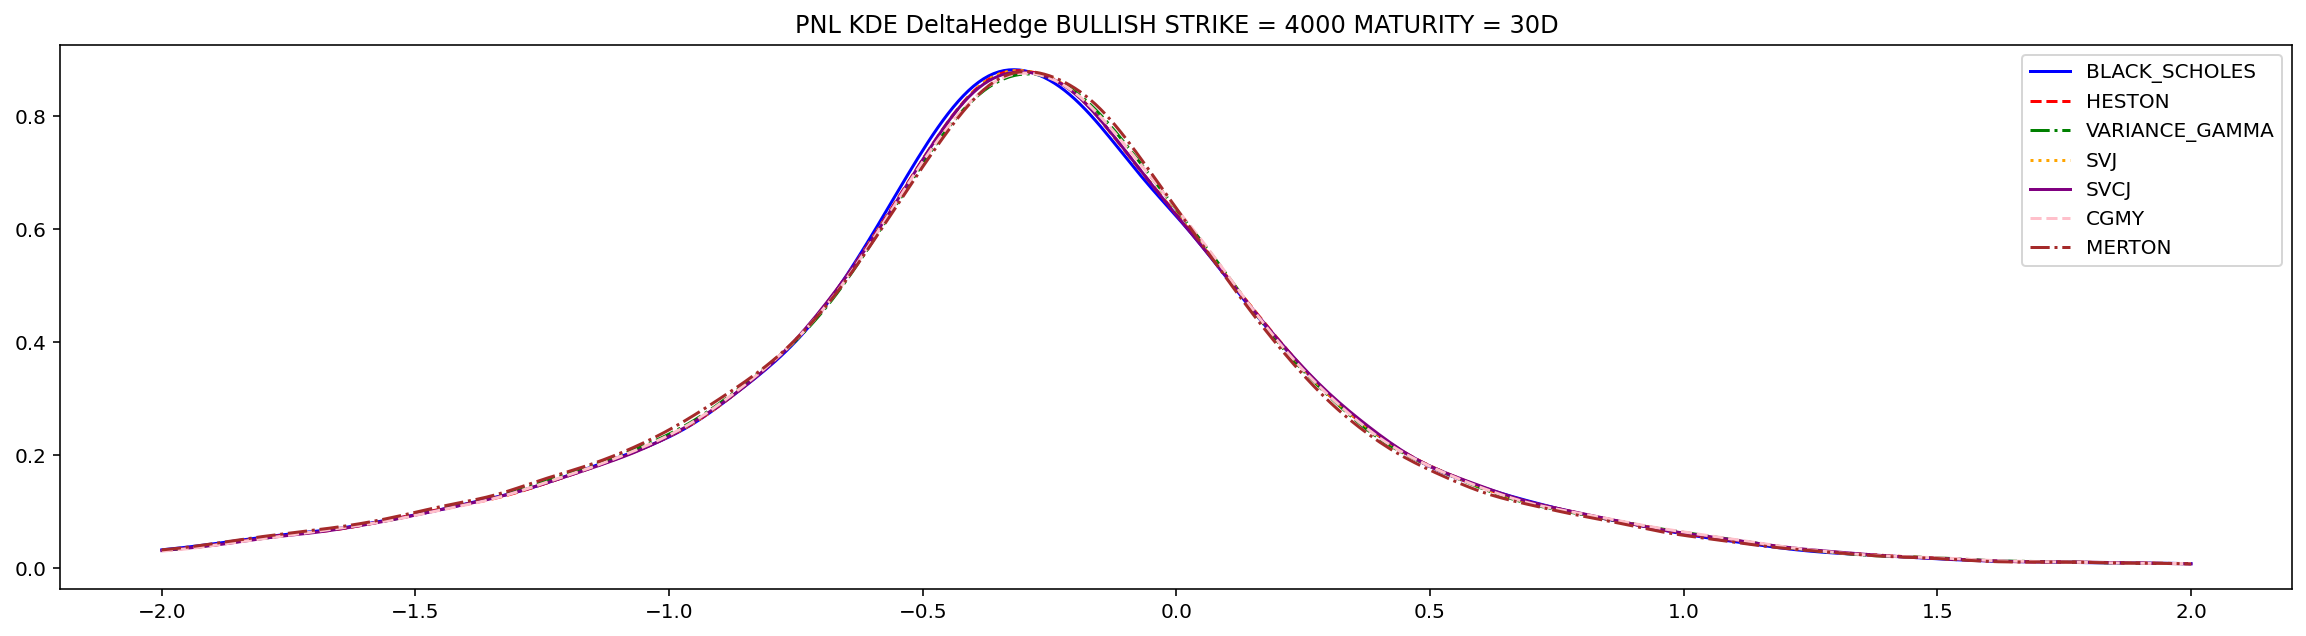

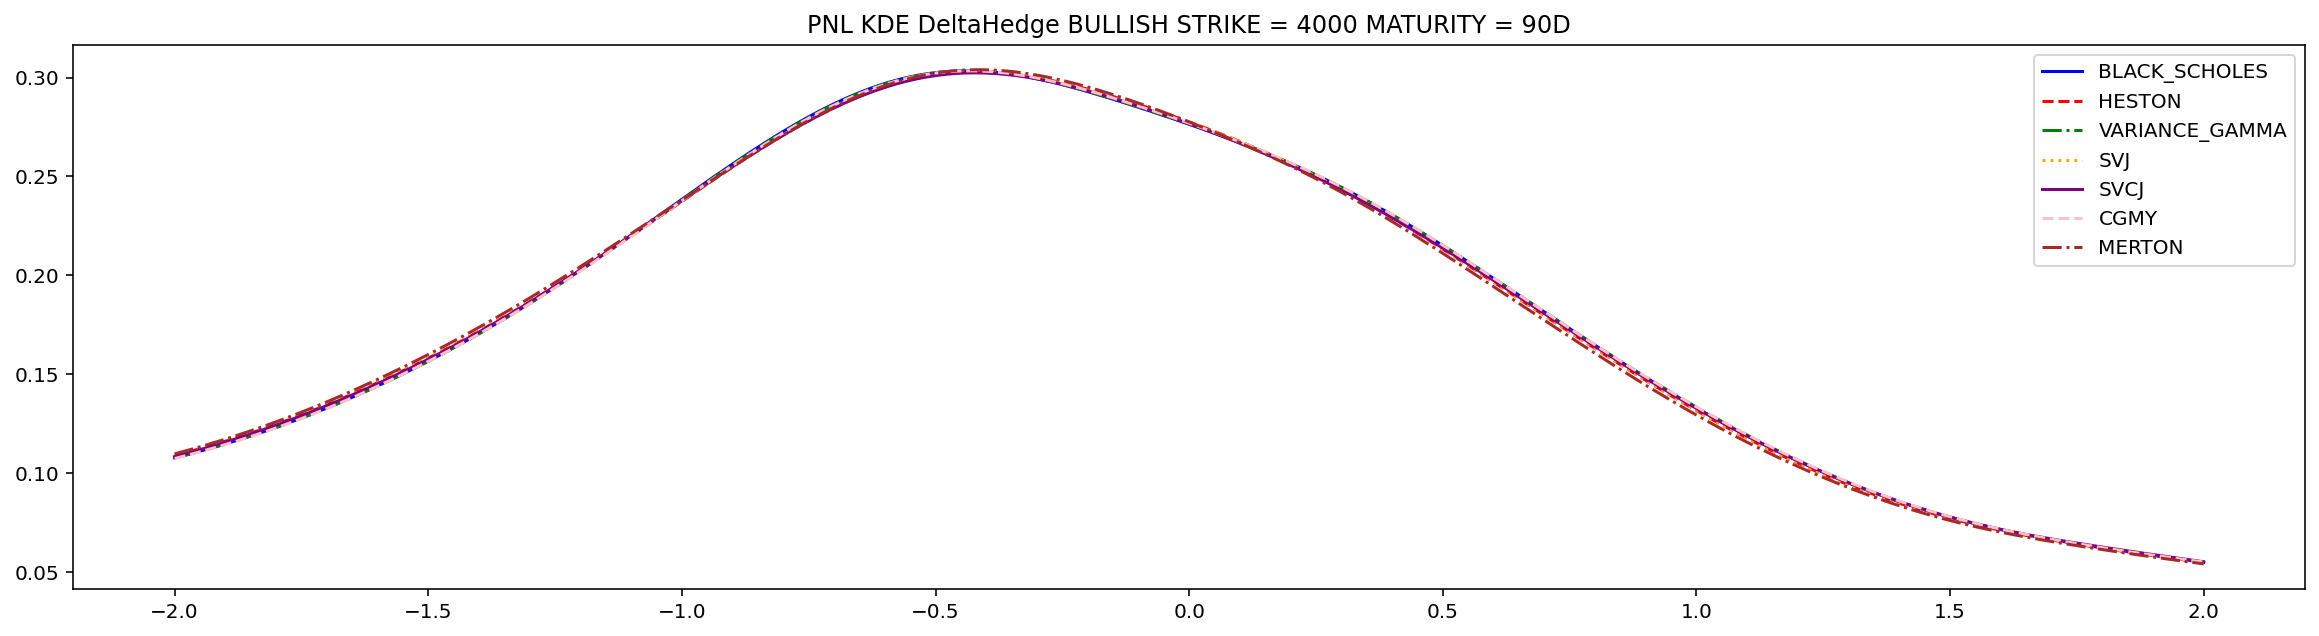

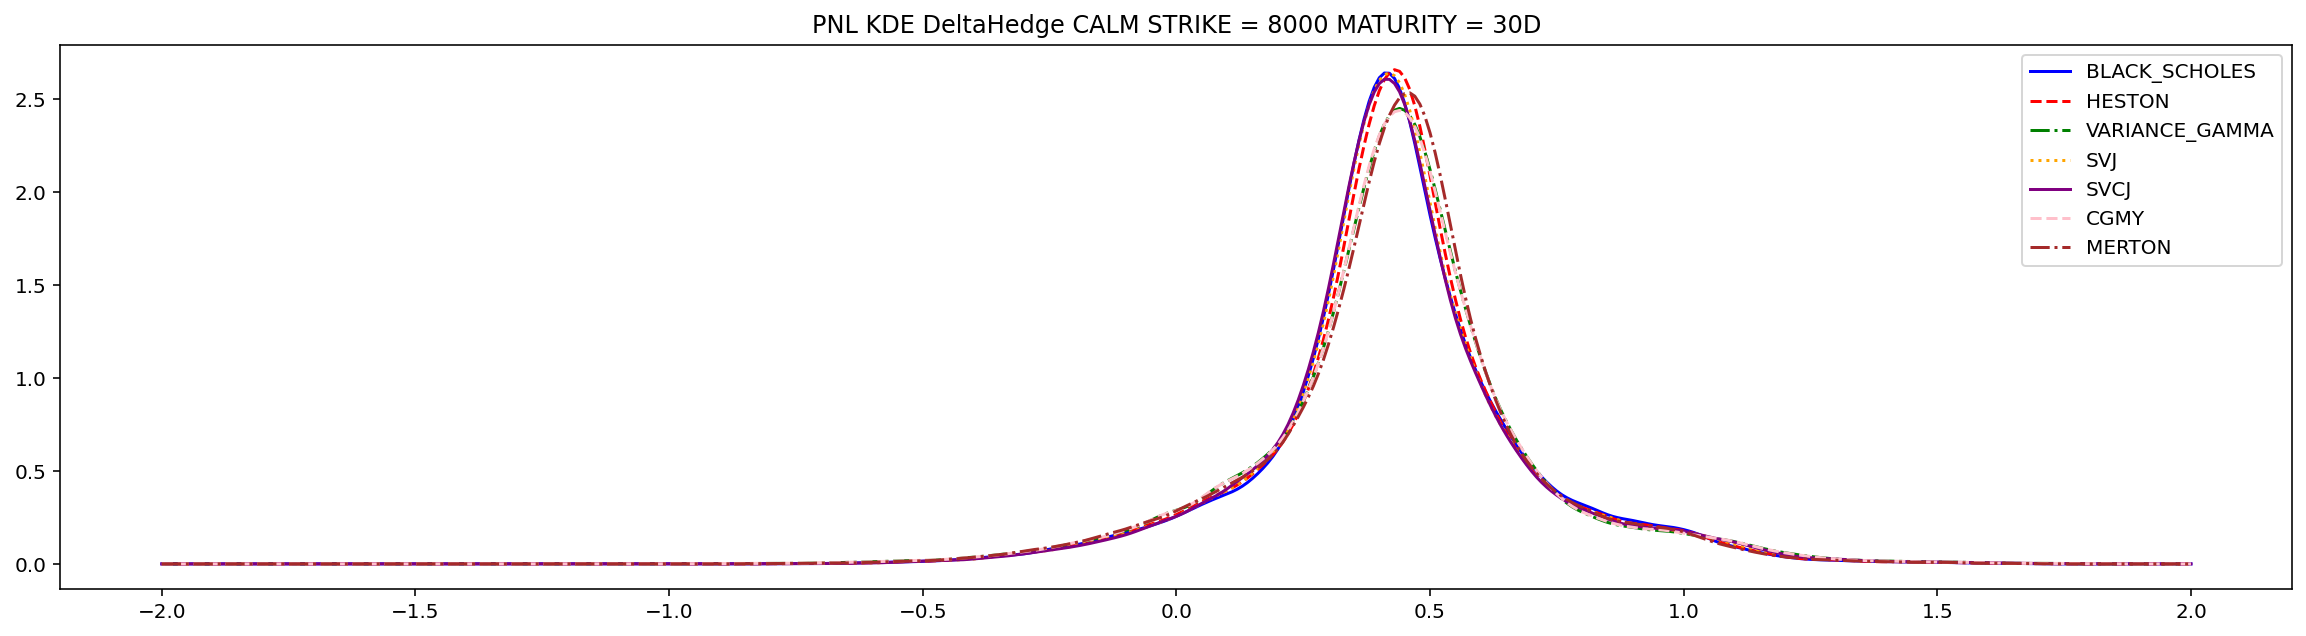

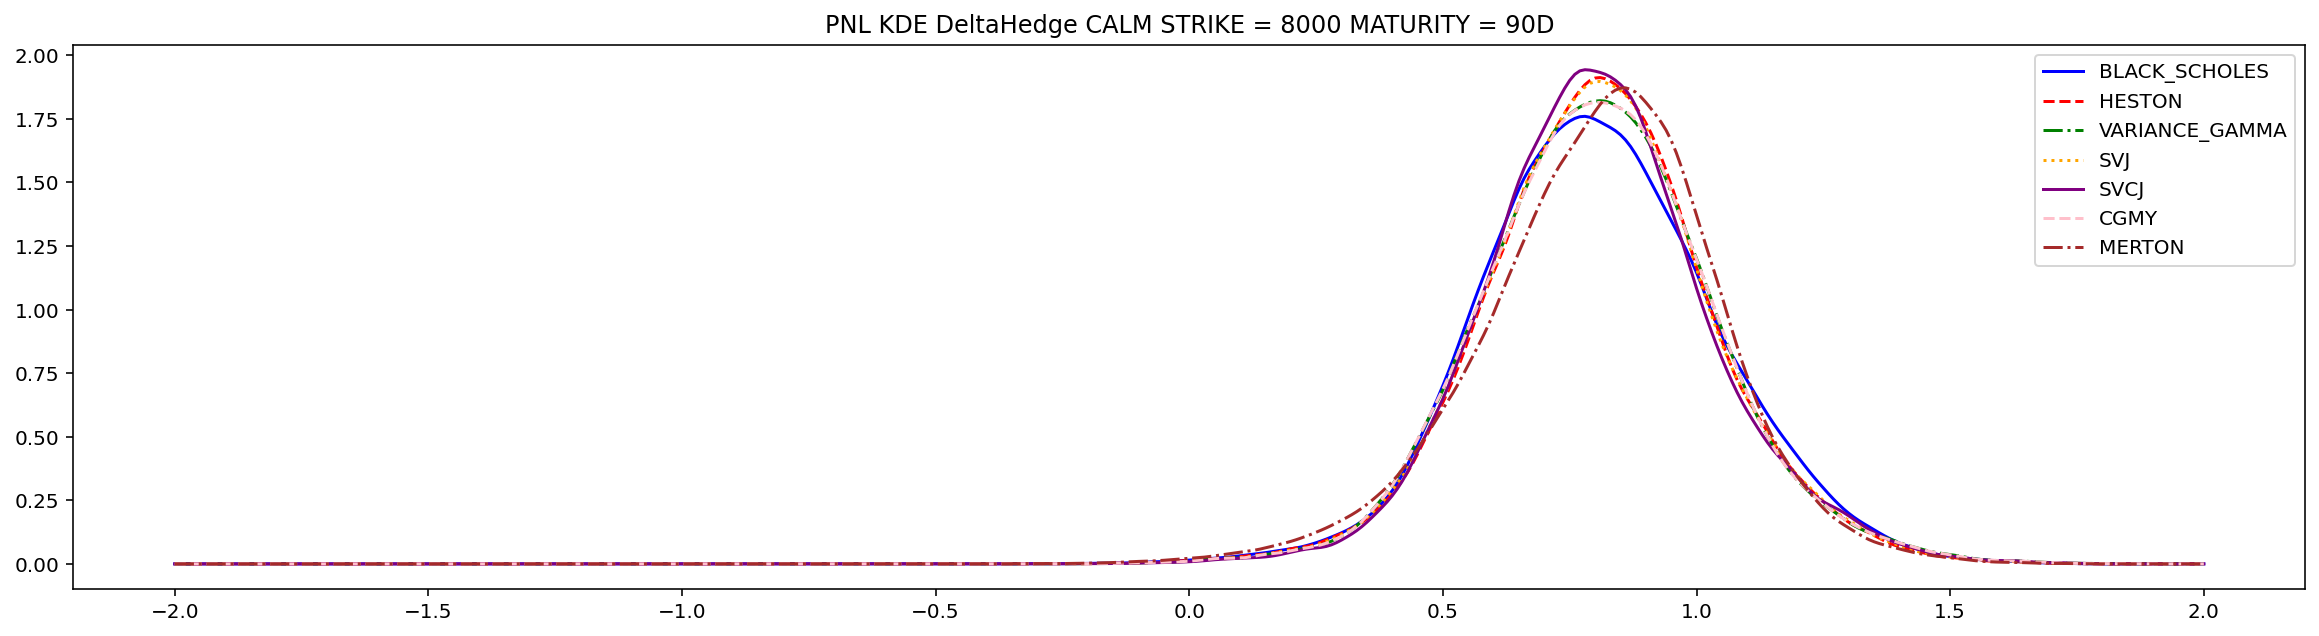

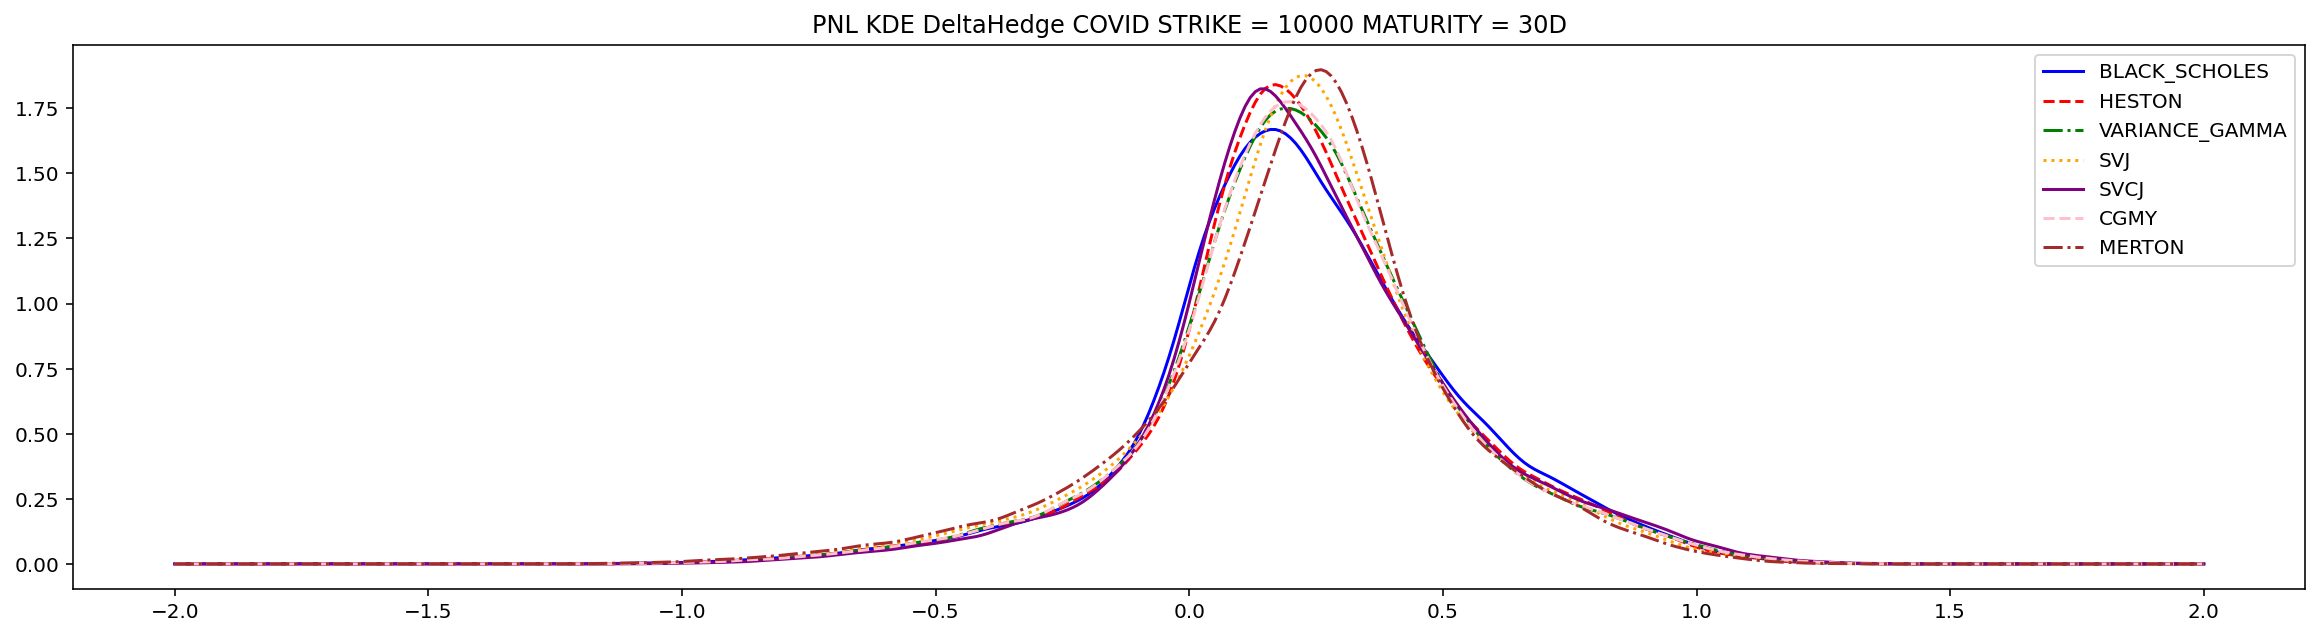

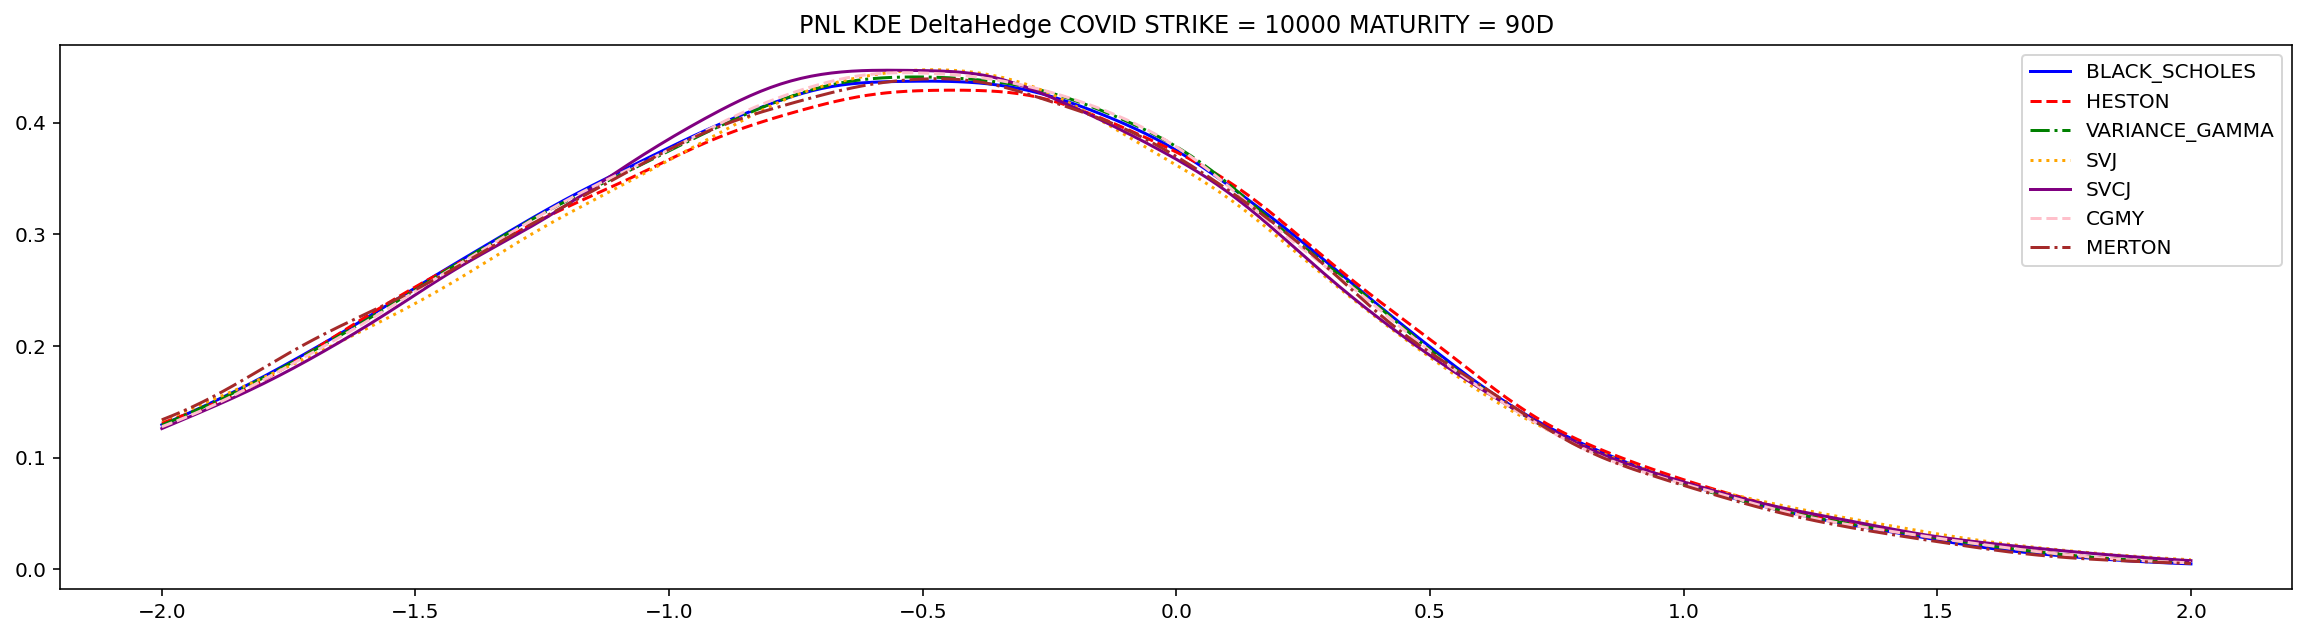

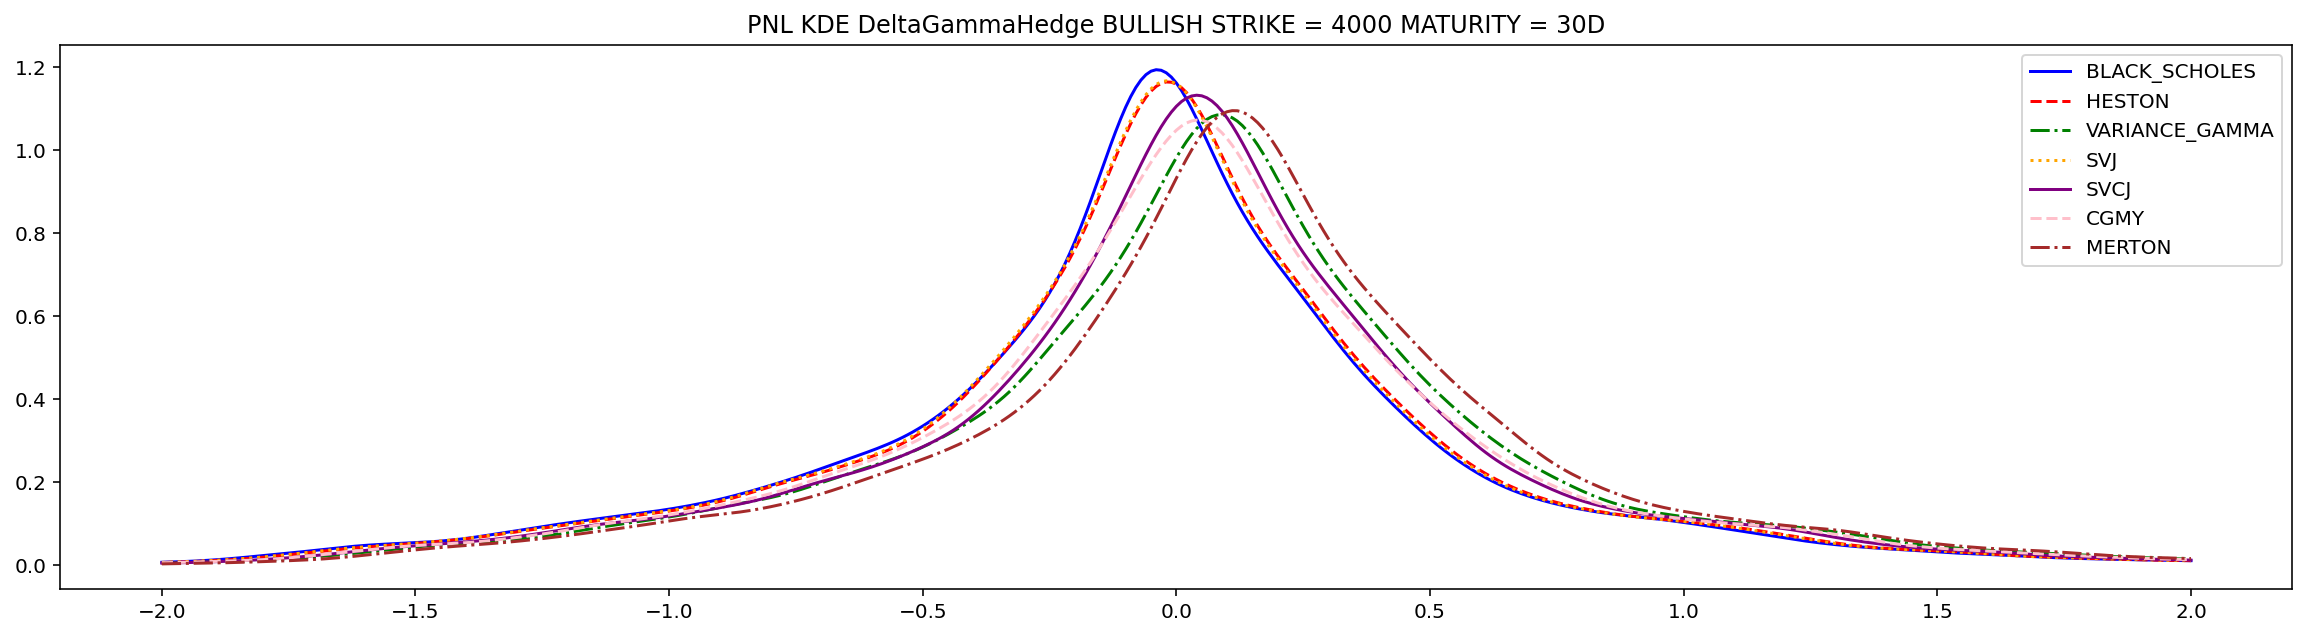

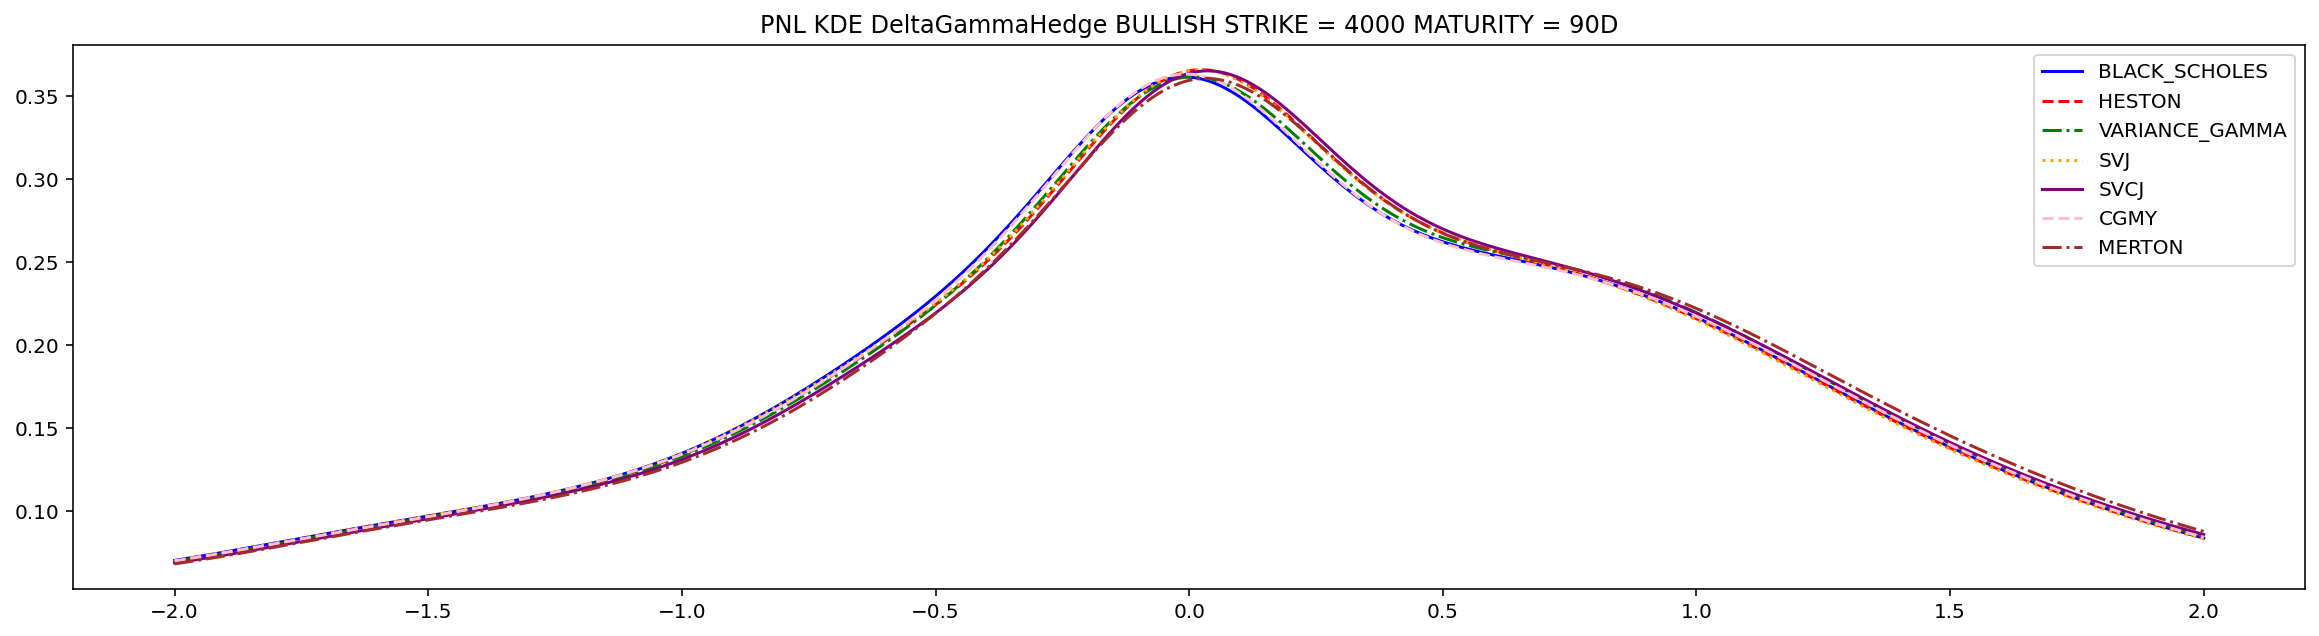

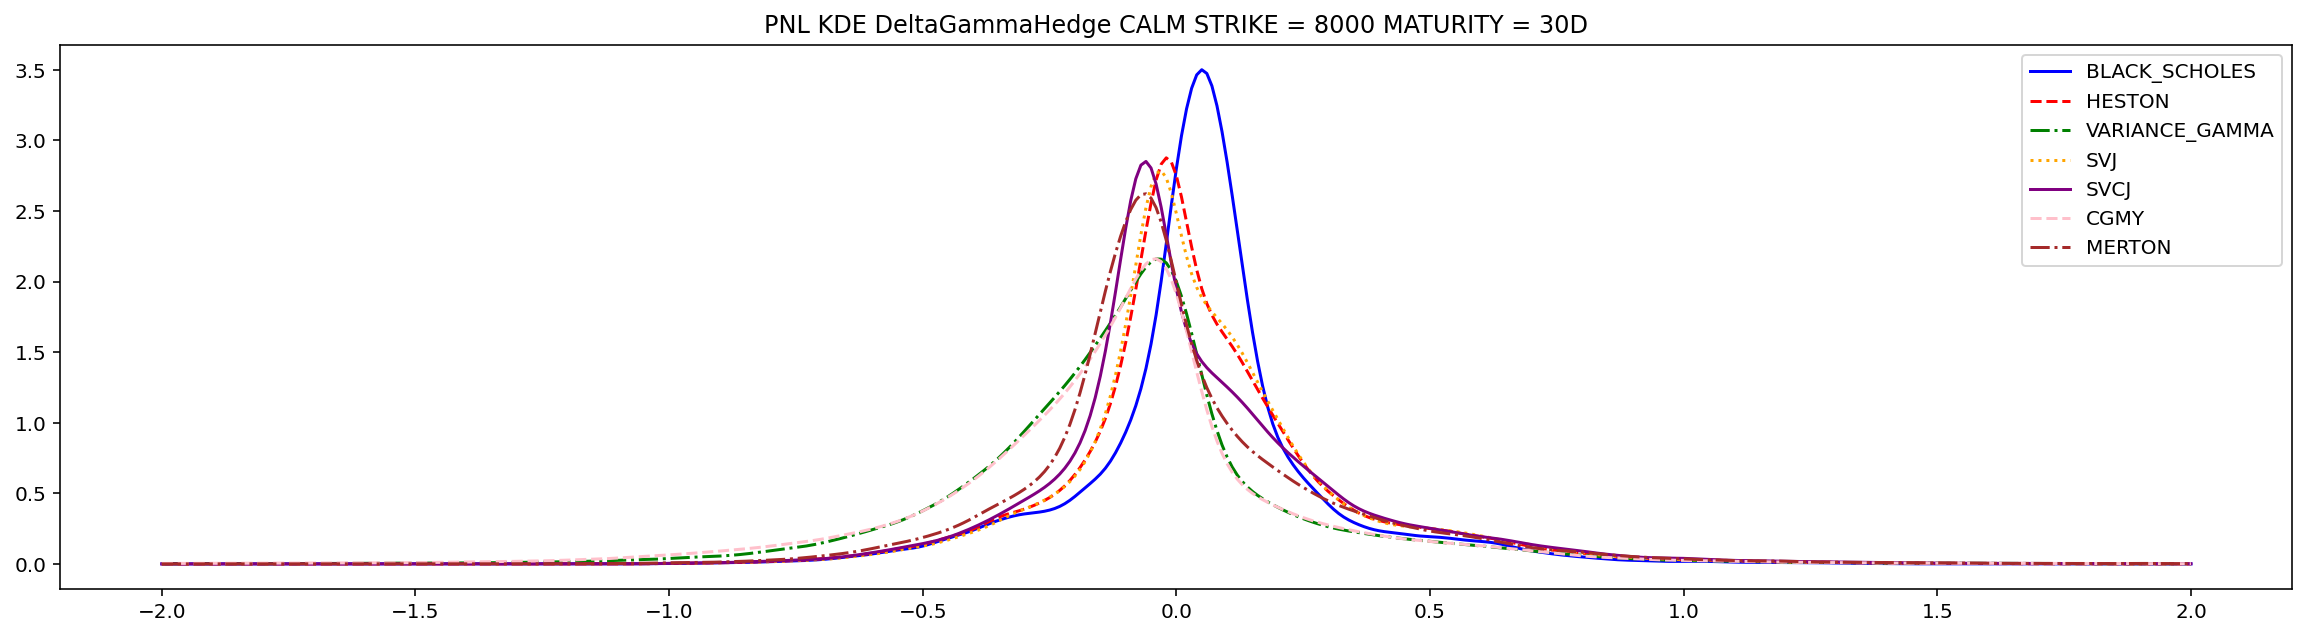

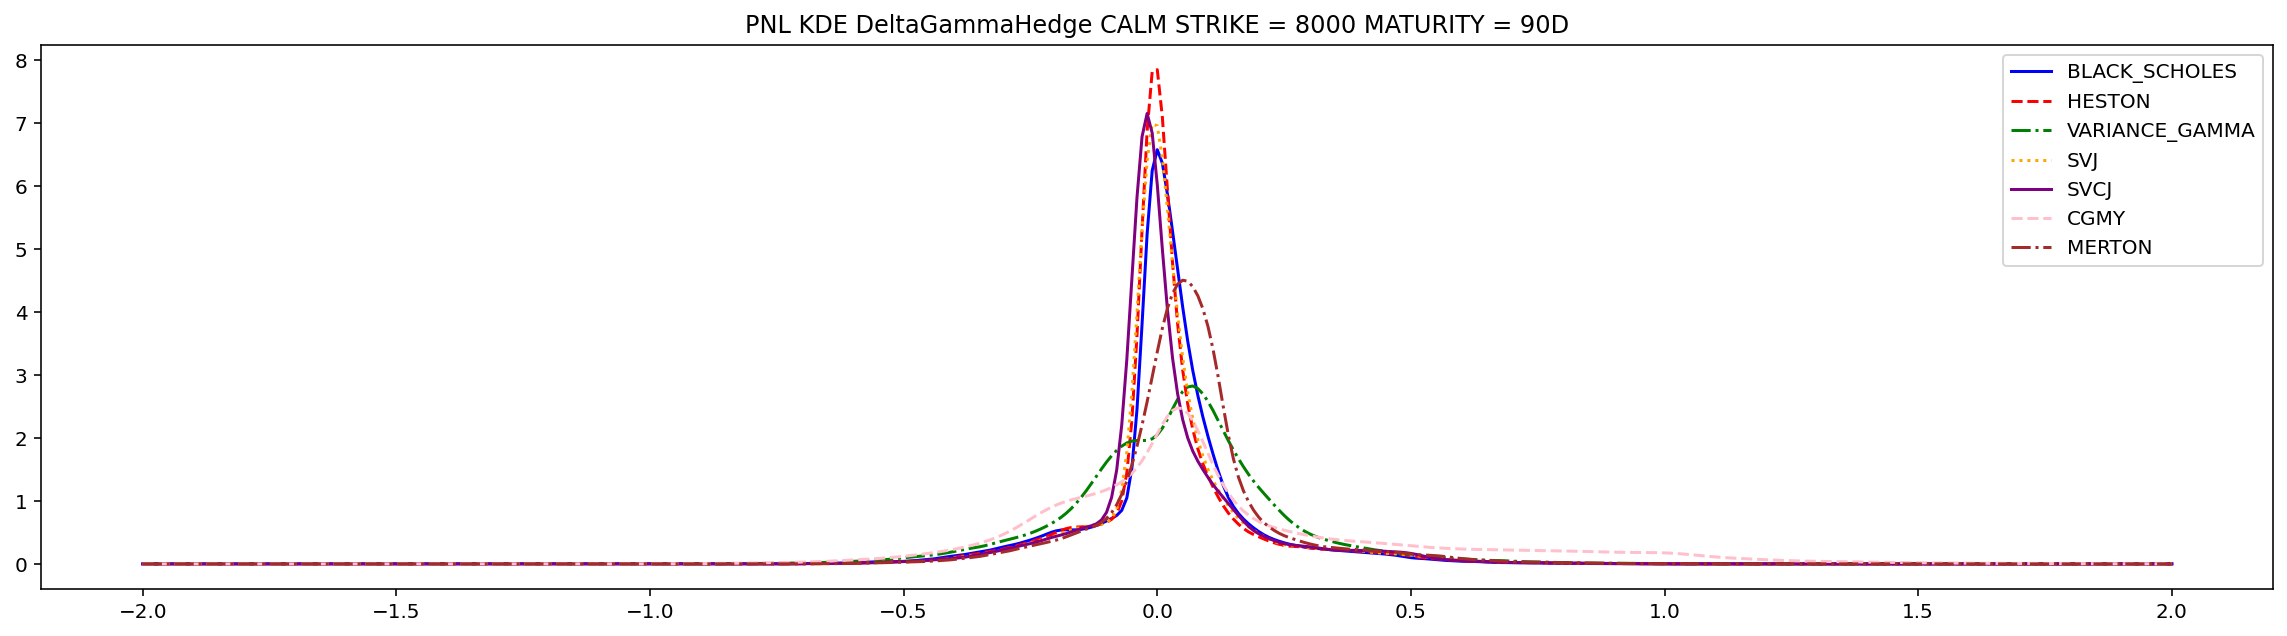

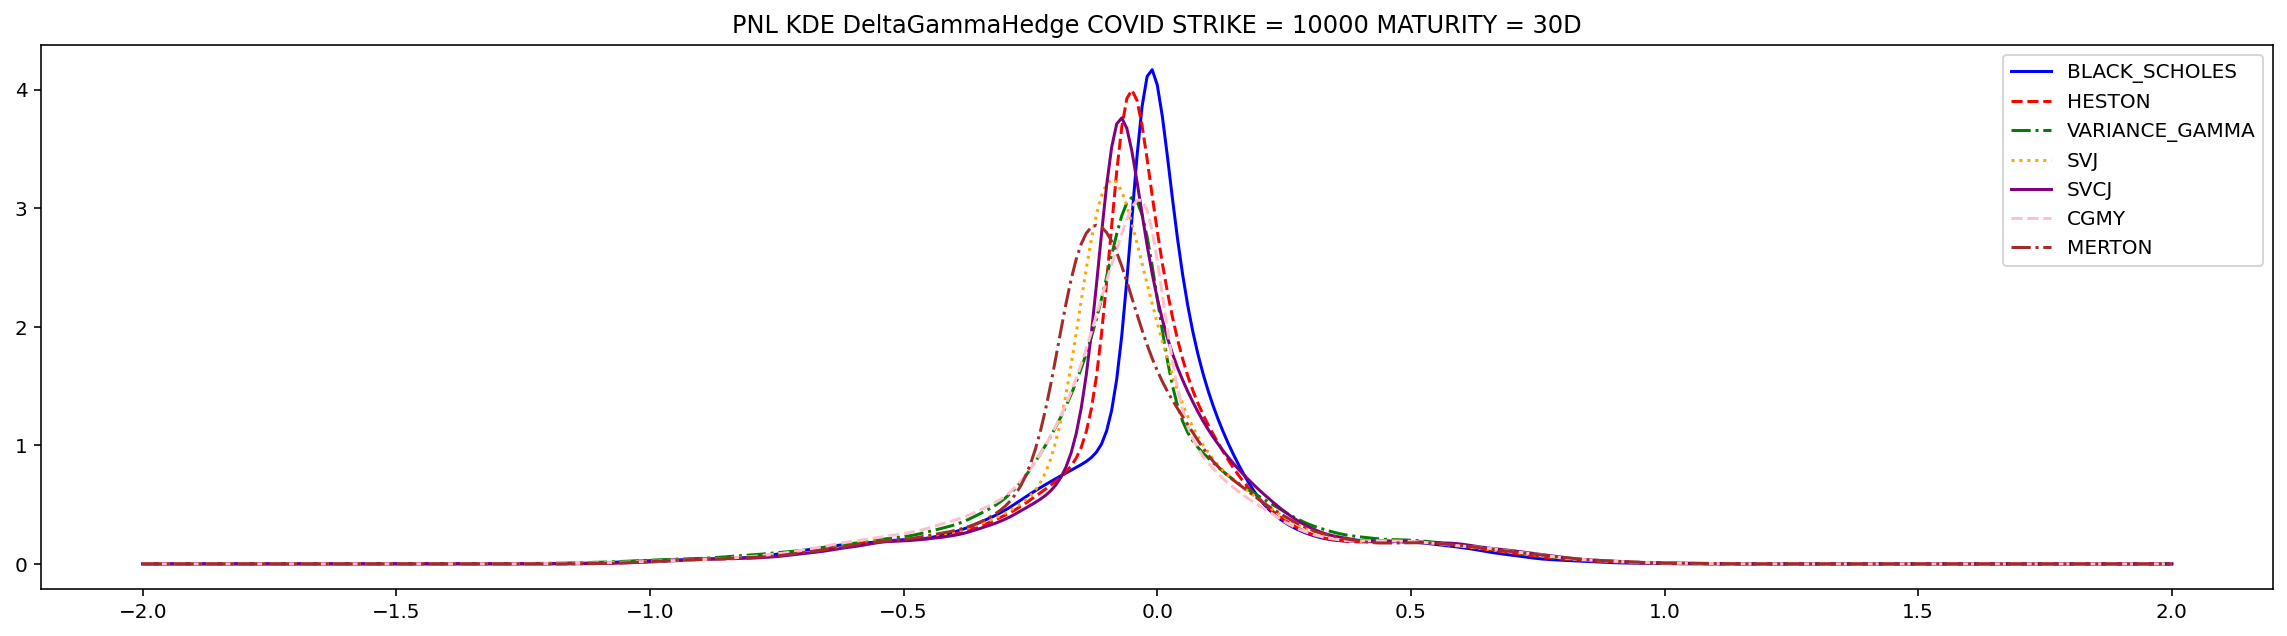

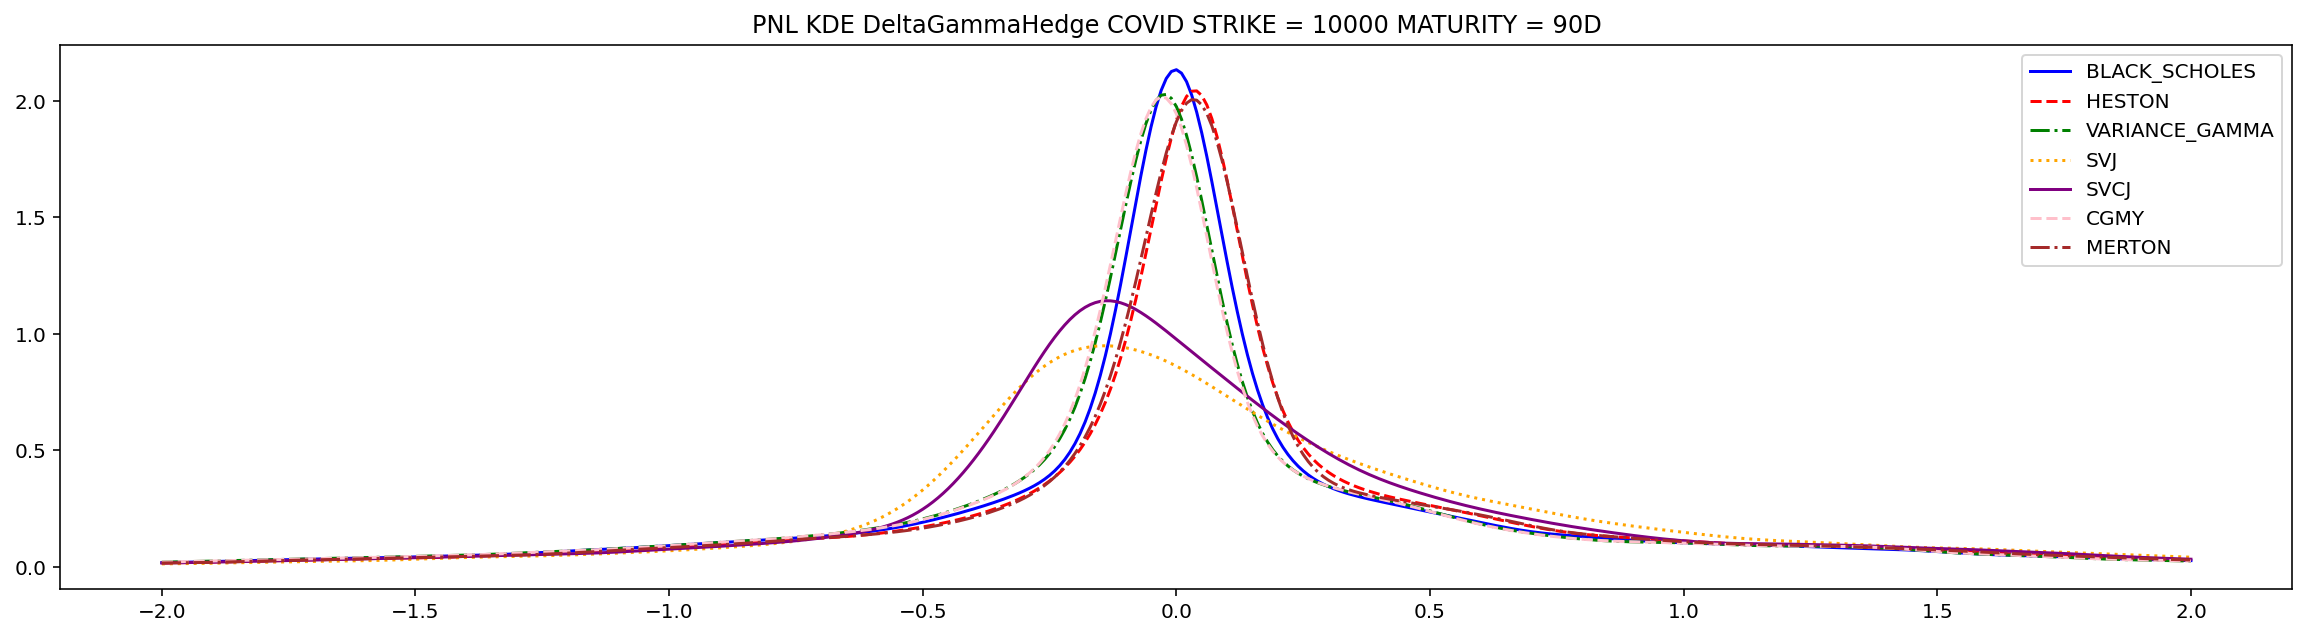

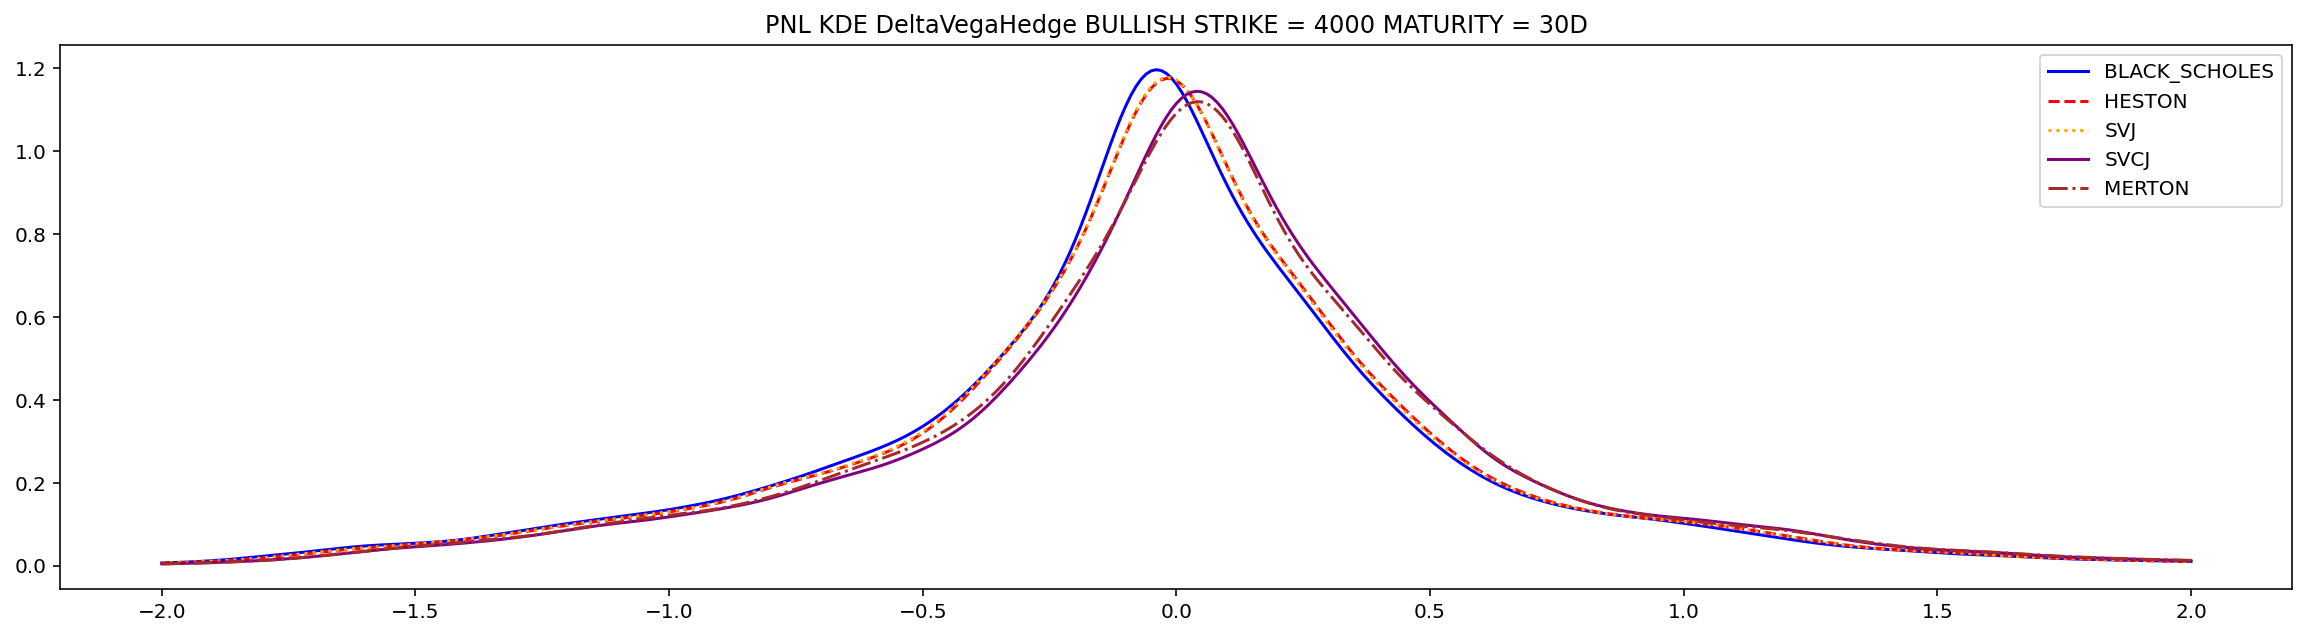

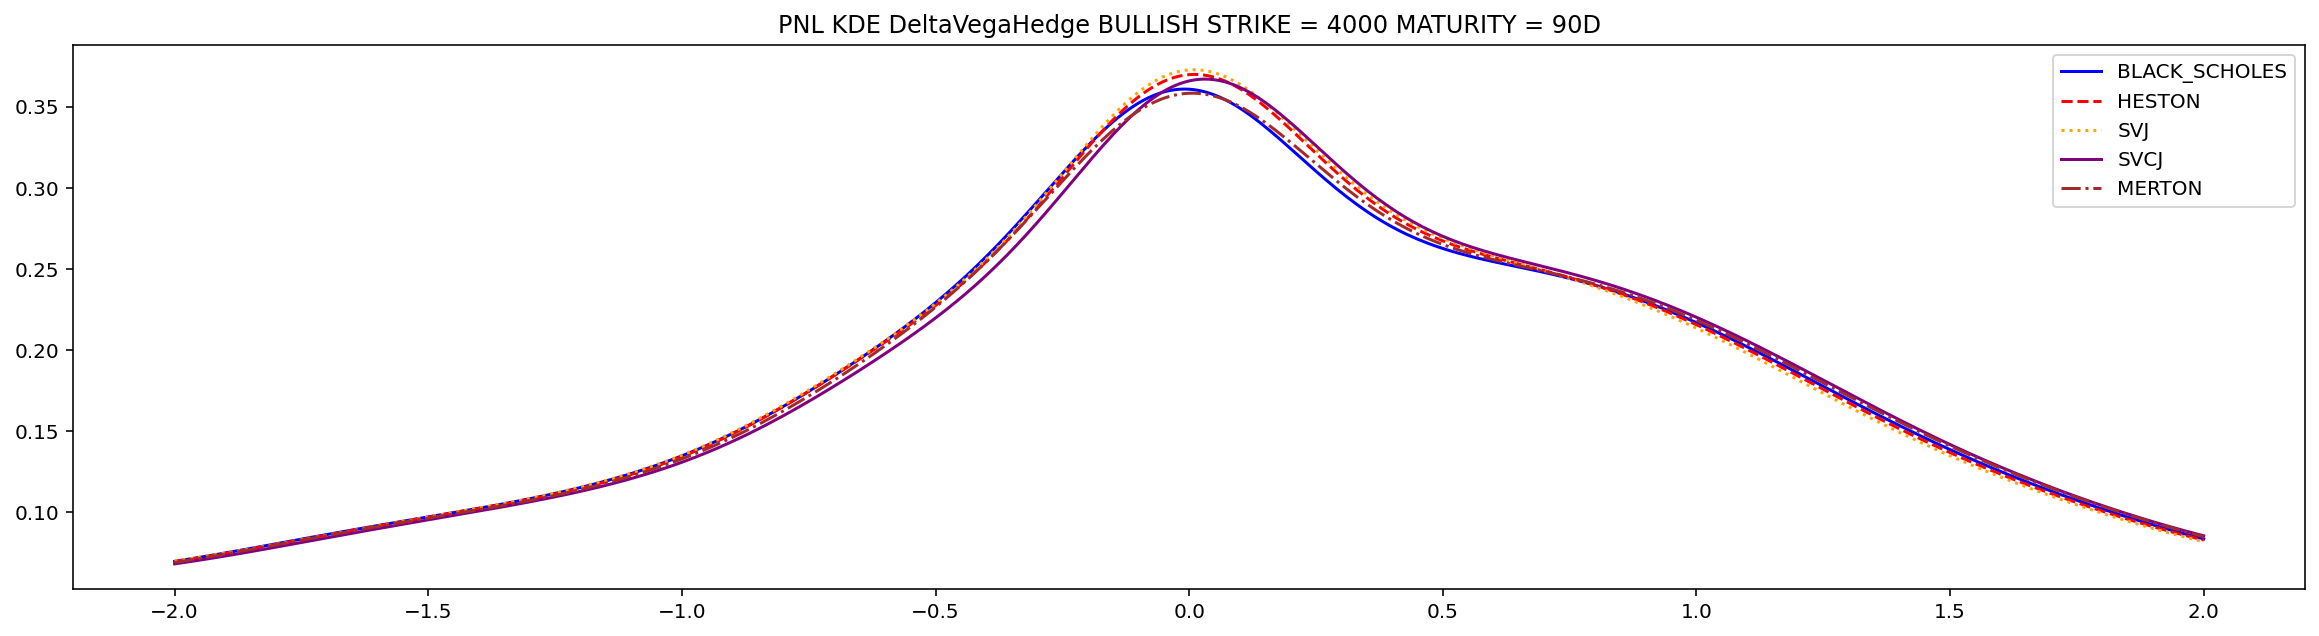

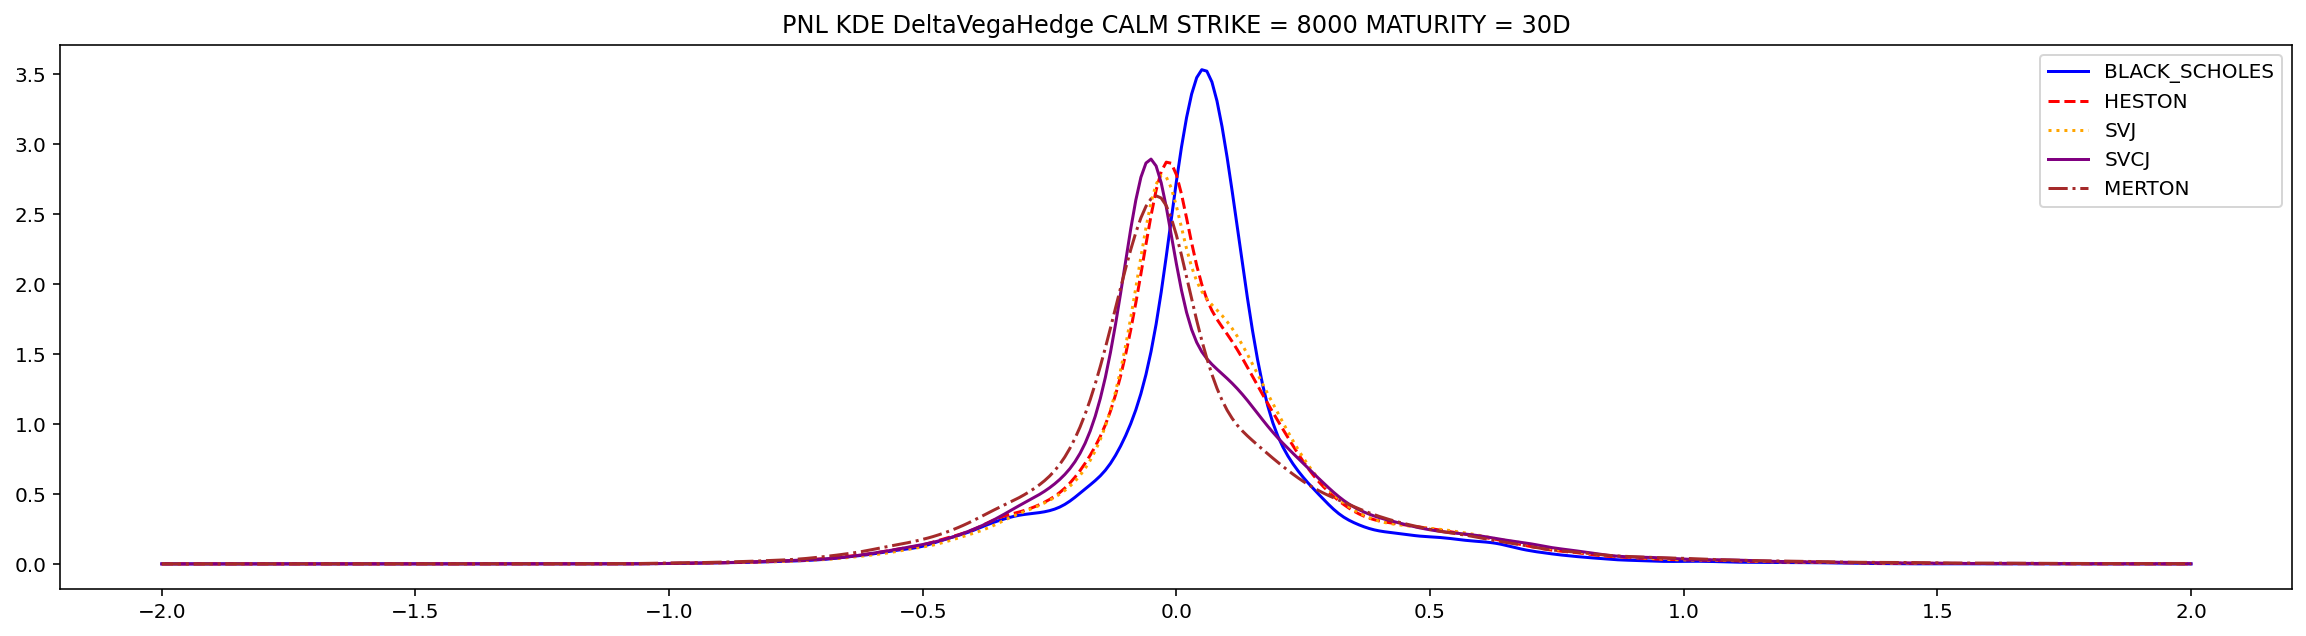

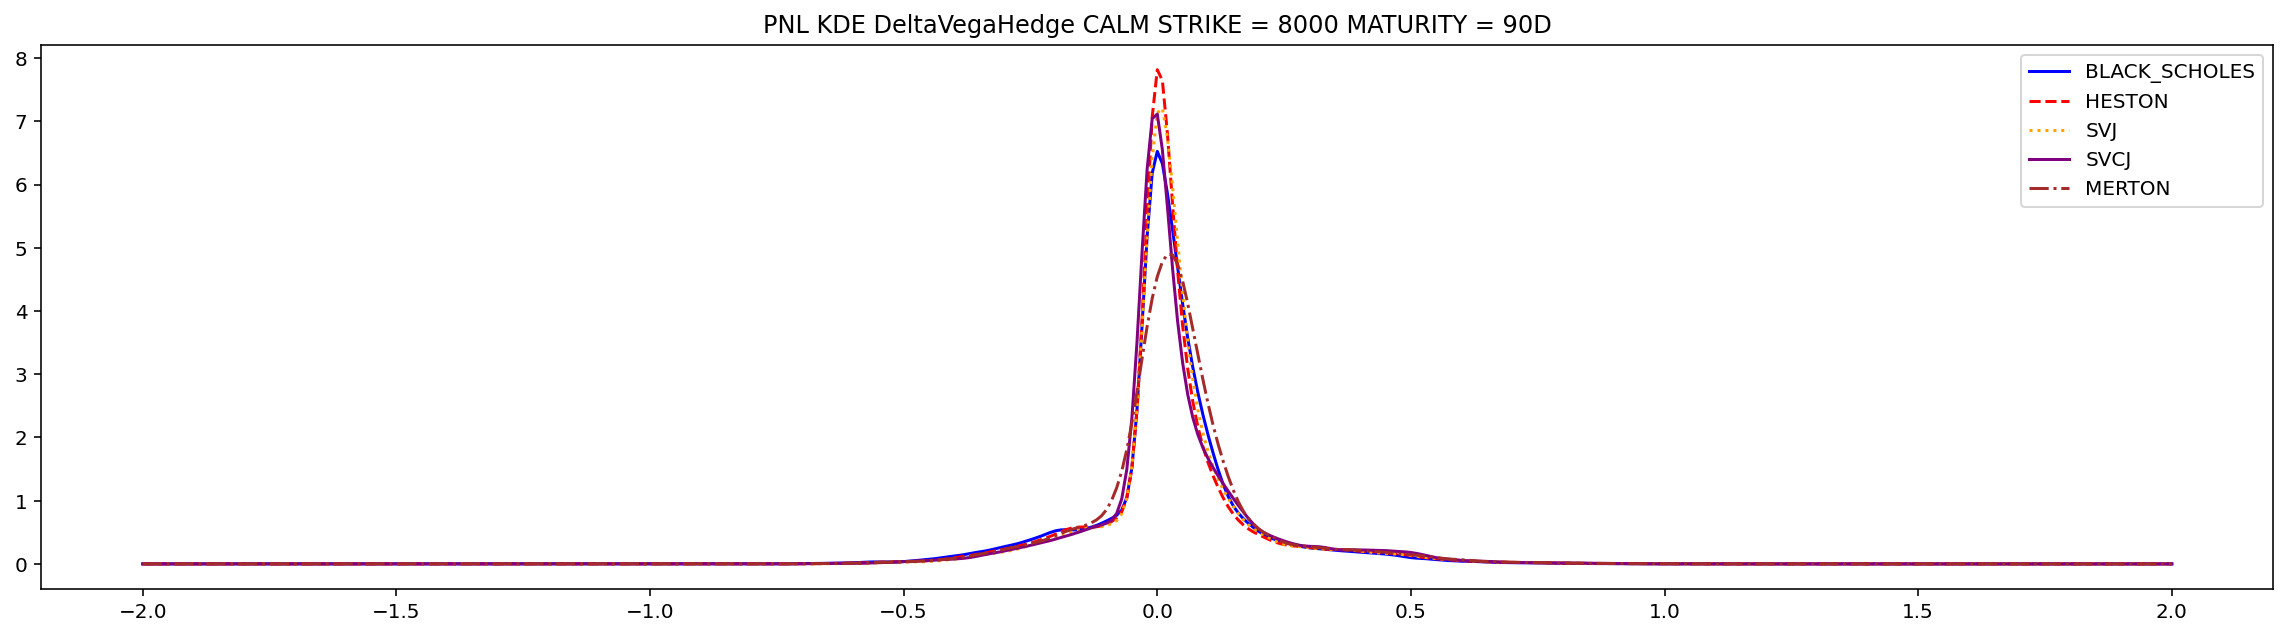

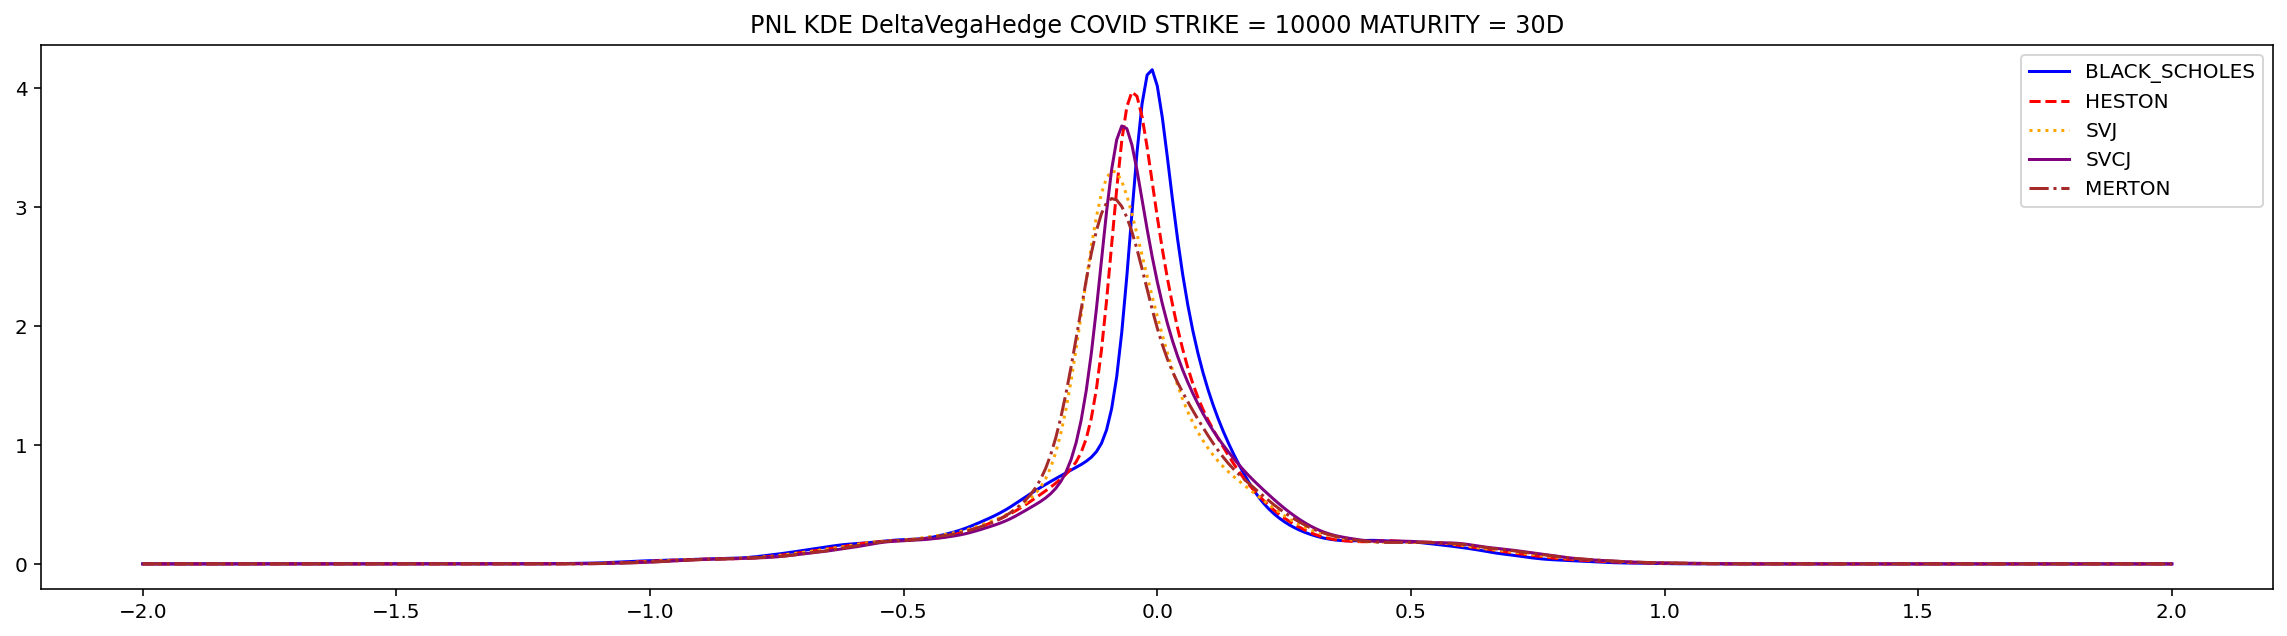

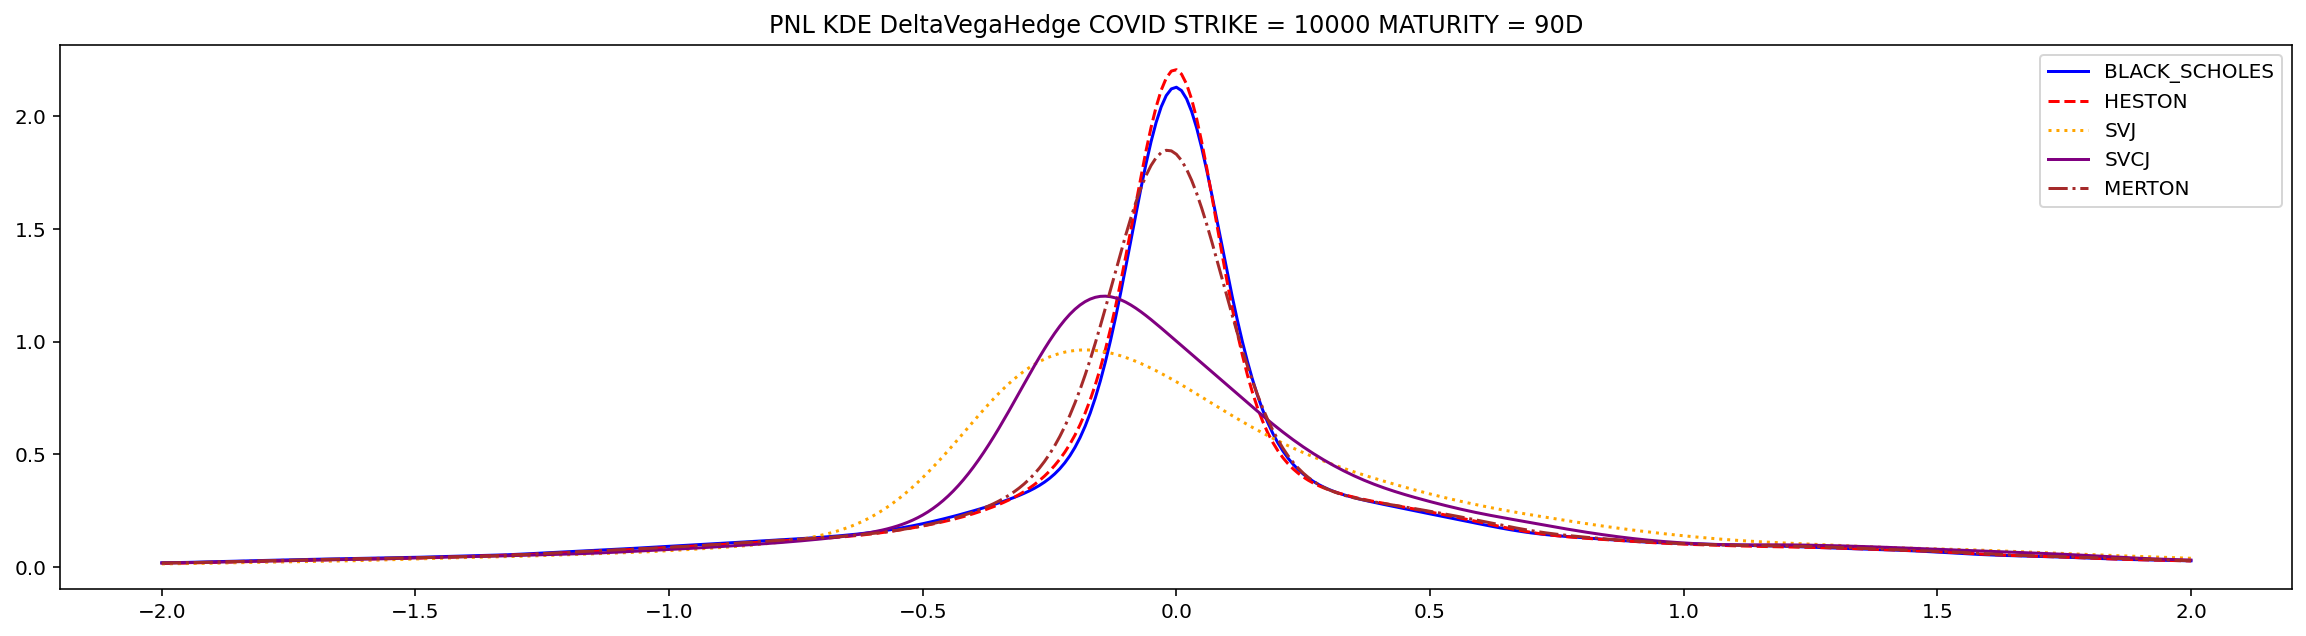

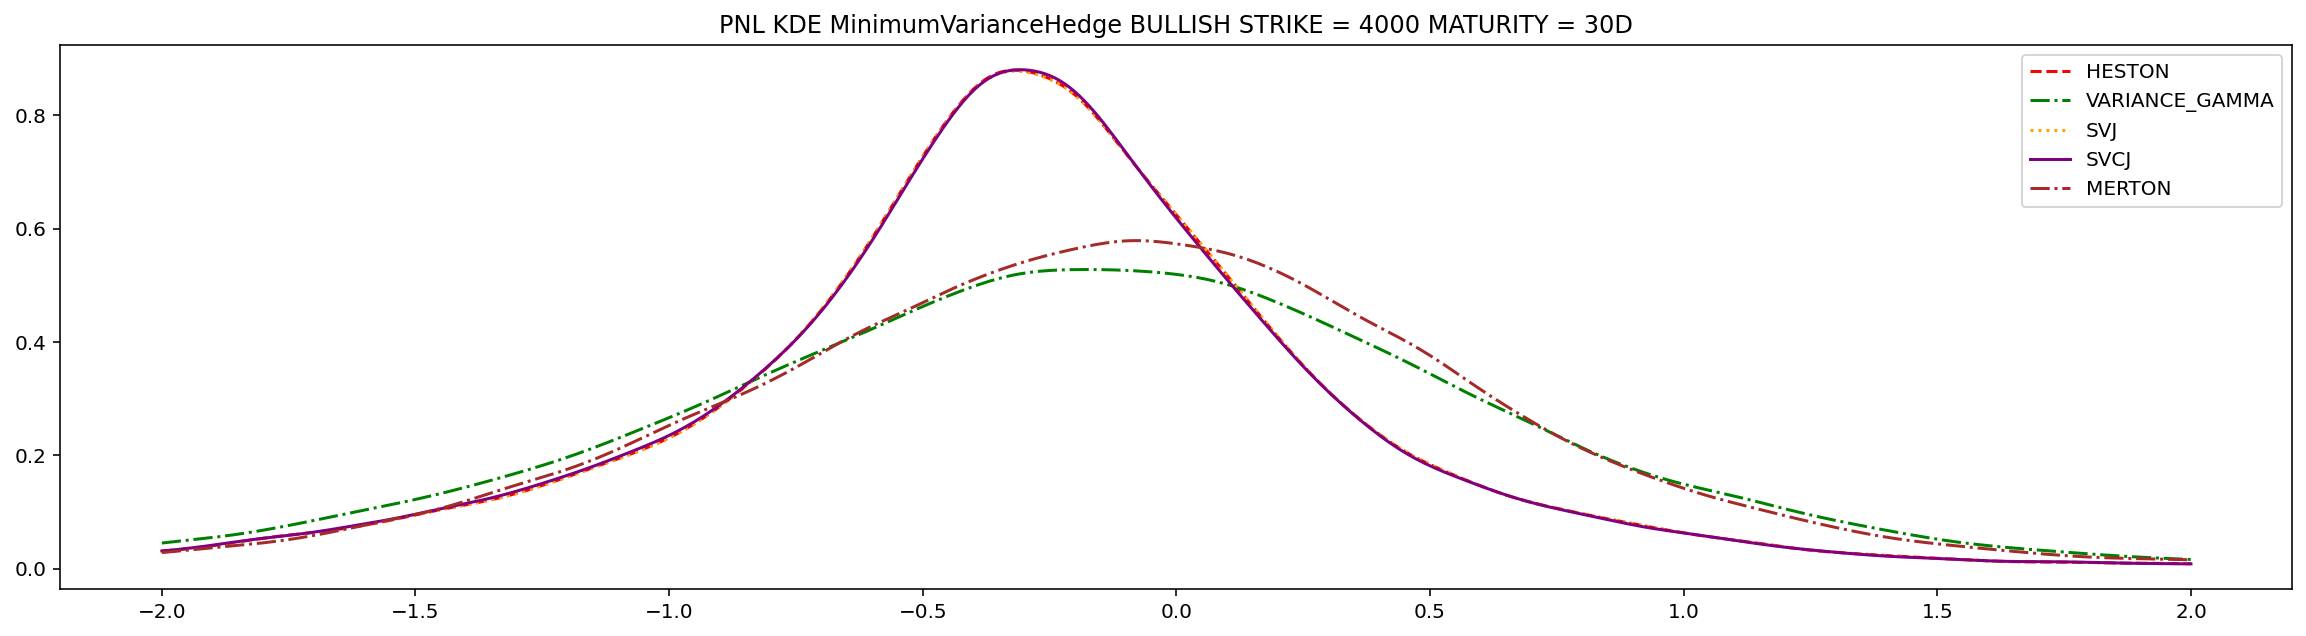

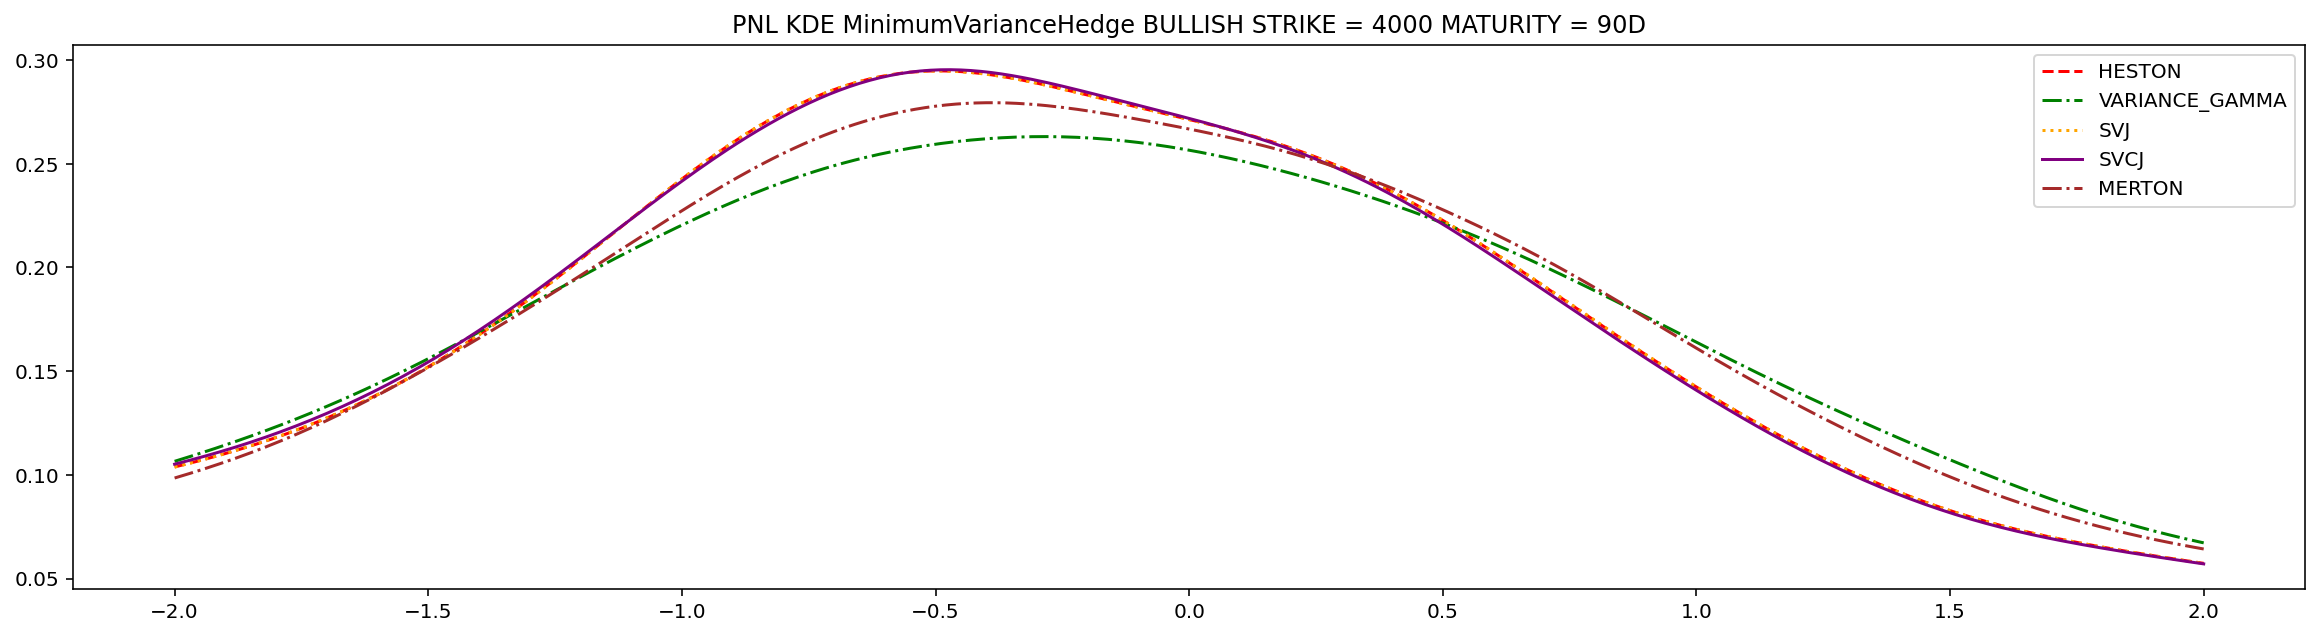

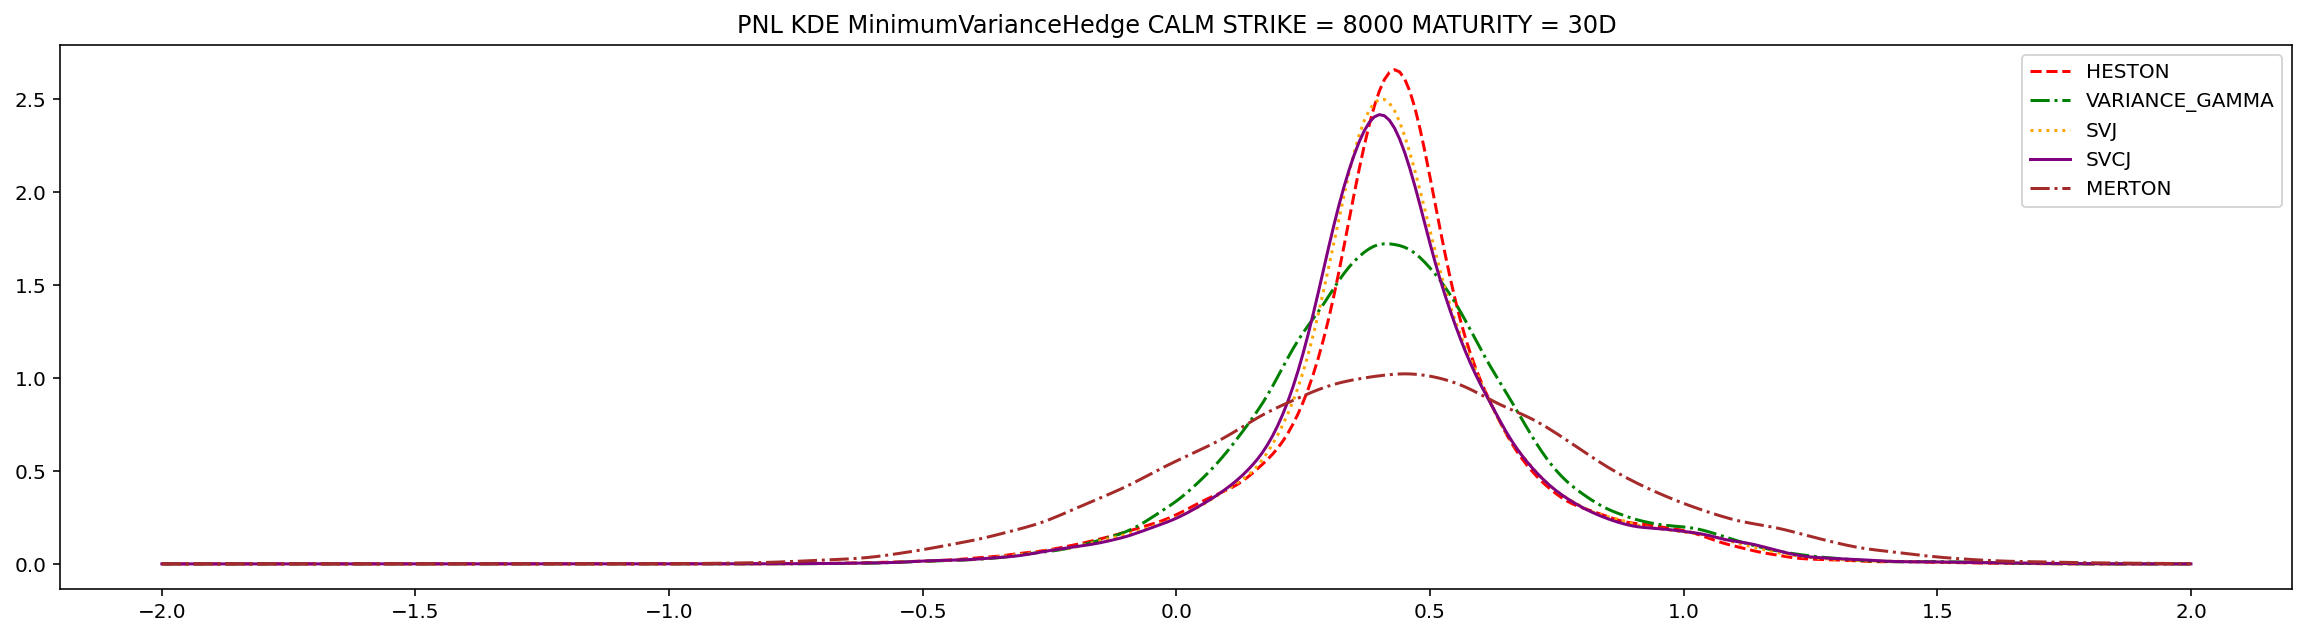

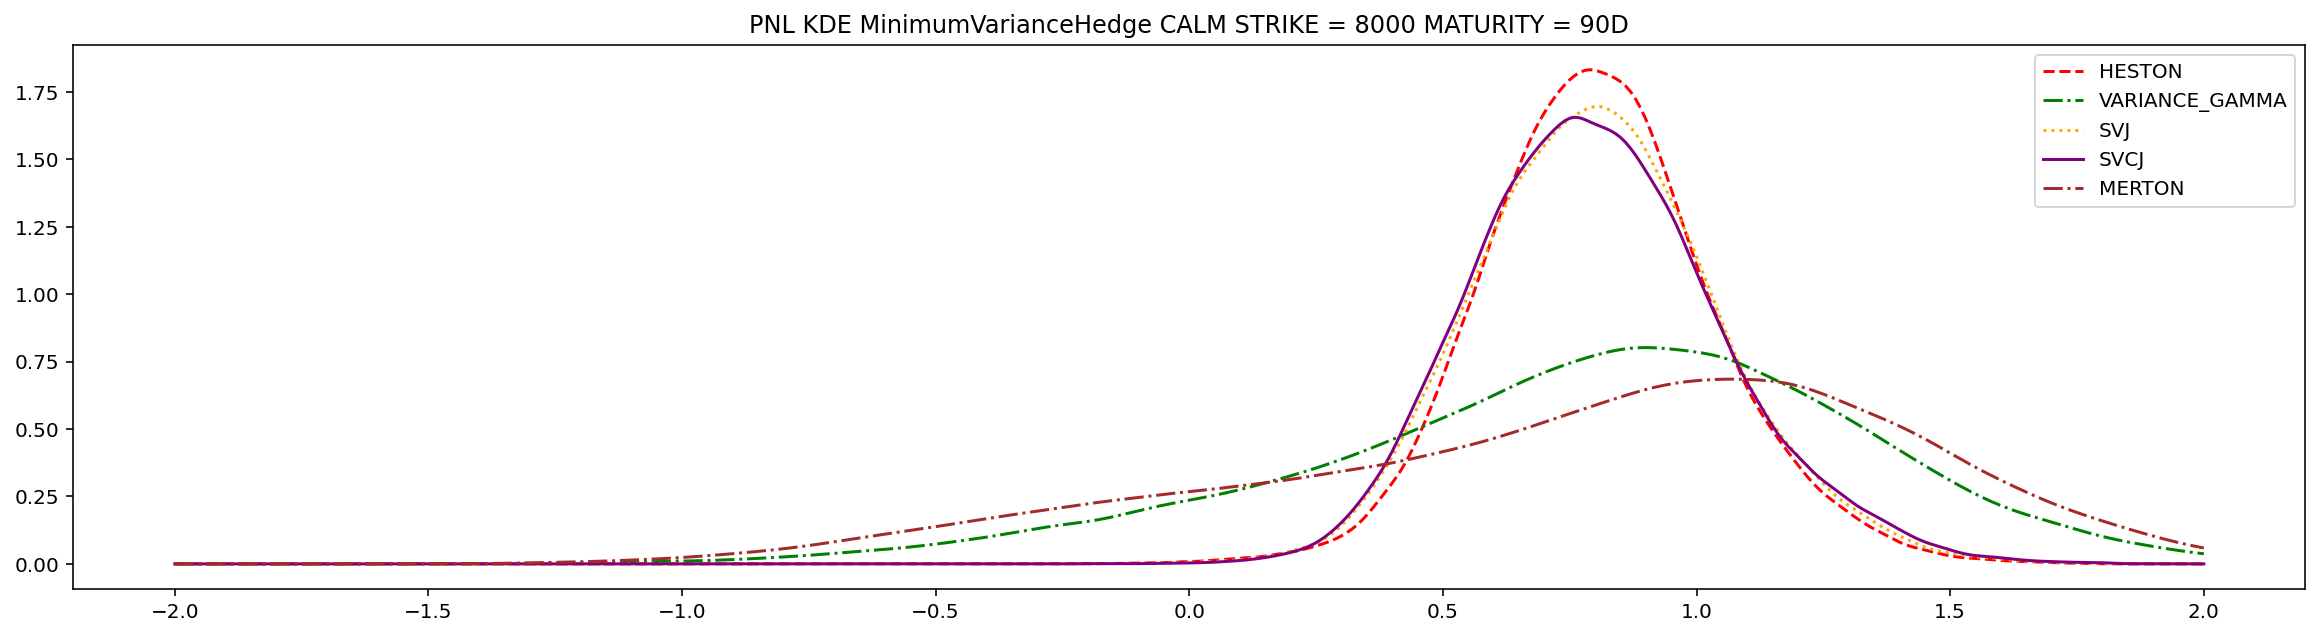

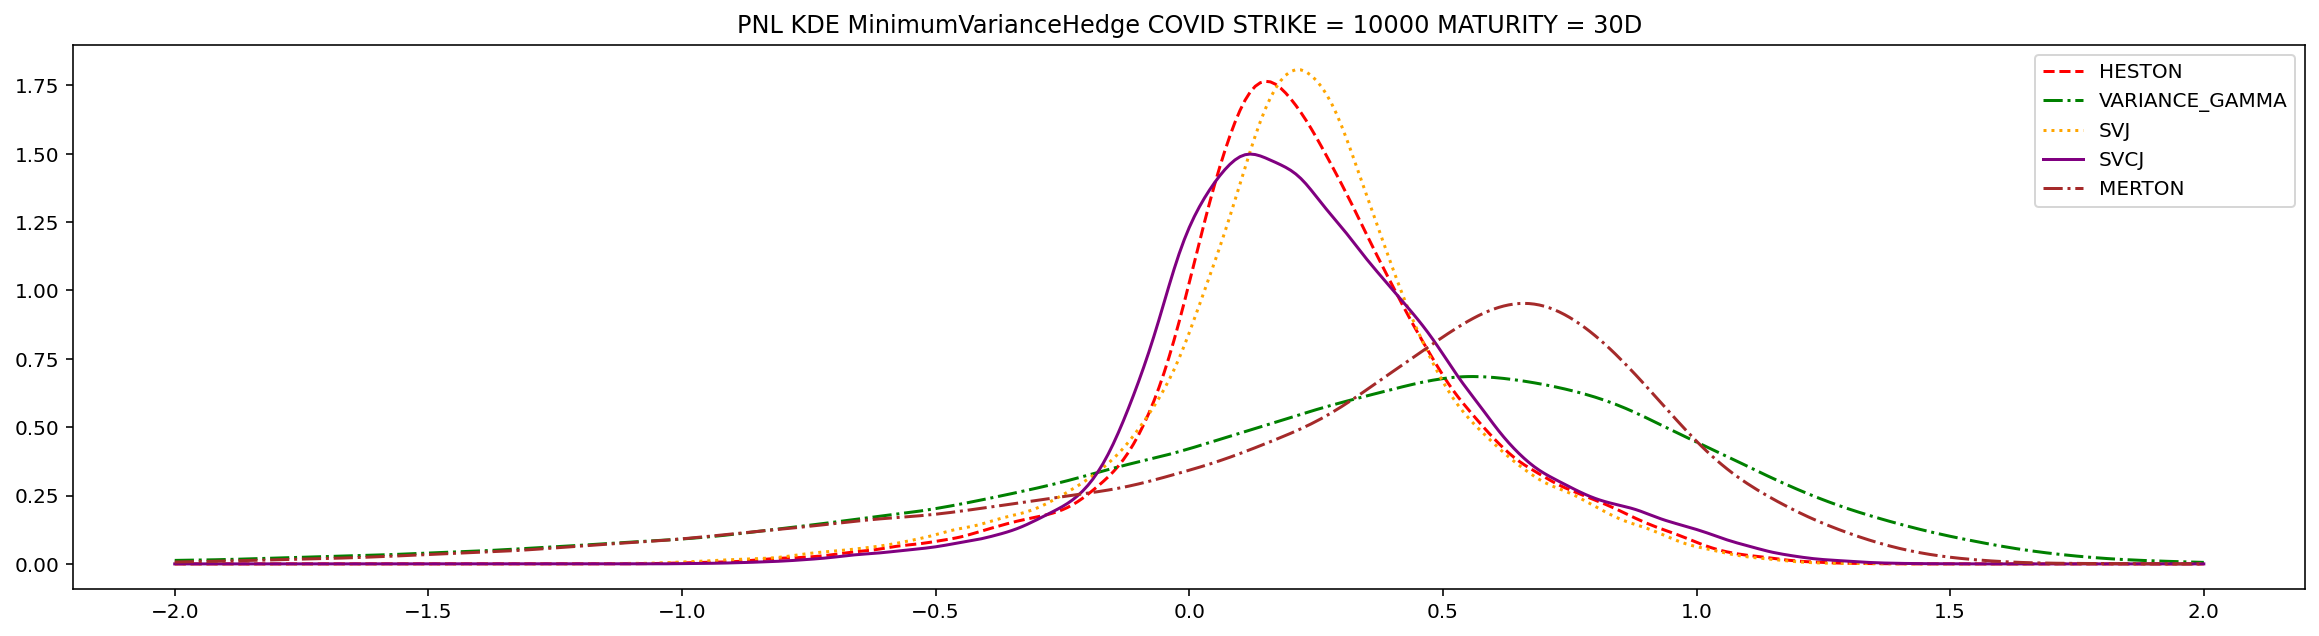

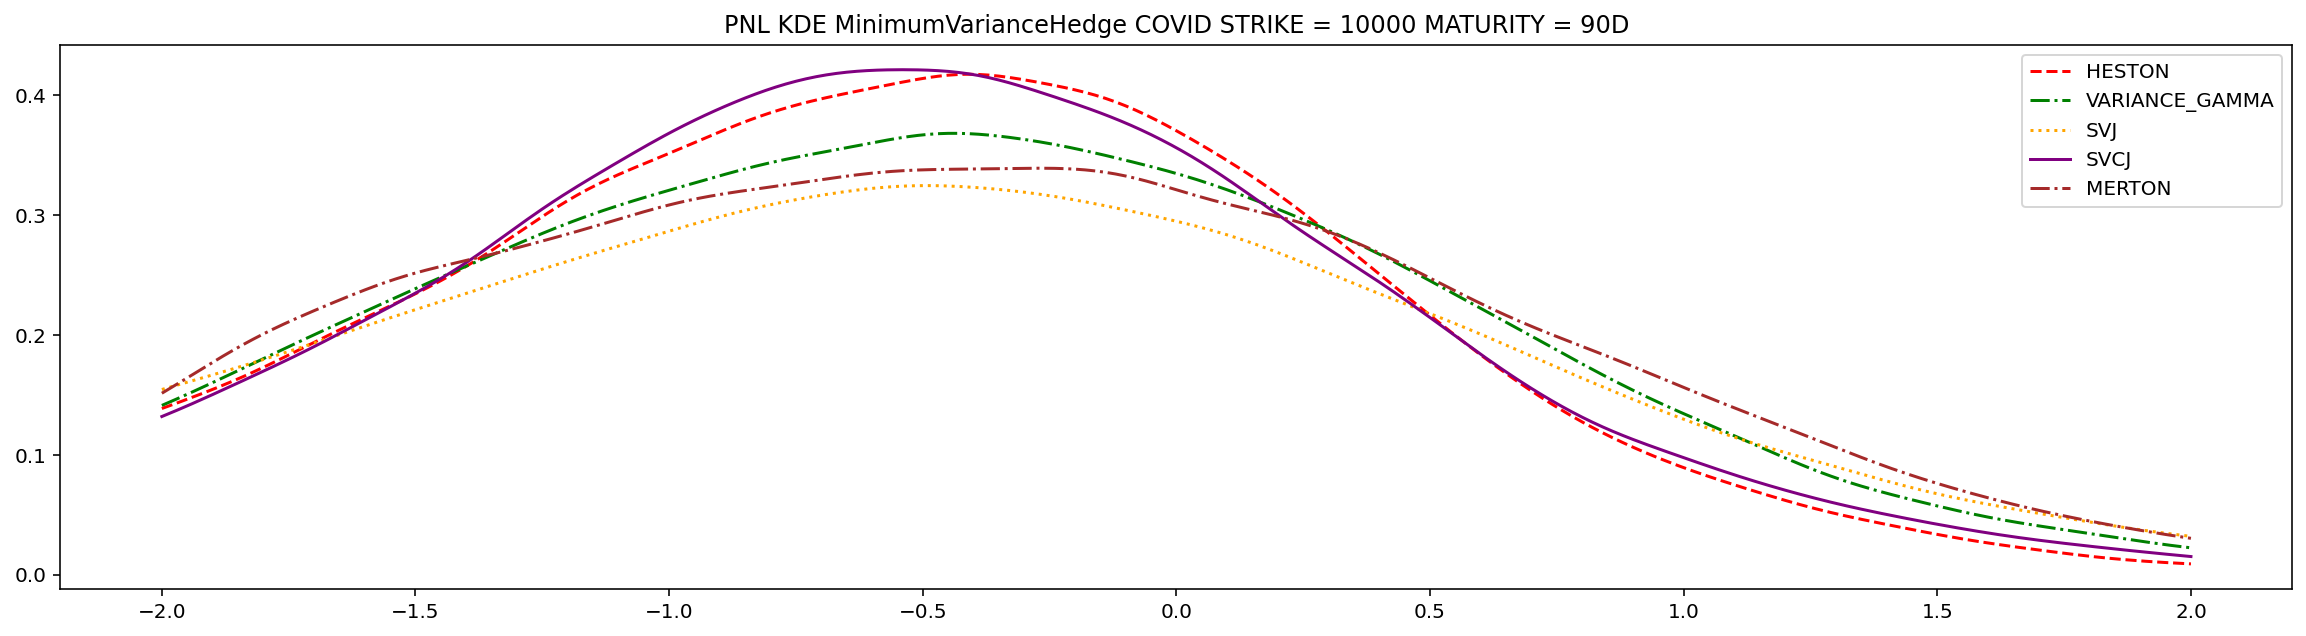

In [9]:
for paths in 'SVCJ', 'KDE':
    for hedge in 'DeltaHedge', 'DeltaGammaHedge', 'DeltaVegaHedge', 'MinimumVarianceHedge',:
        for period, price, ttm, strike in [('BULLISH', 201.92, 30, 4000), ('CALM', 801.19, 30, 8000), ('COVID', 622.51, 30, 10000)]:
            for maturity in 30, 90:
                plot_hedge(paths, models, hedge, period, strike, maturity, price)